# Application of Machine Learning on Air Pollution Forecasting
## Problem Background

Air pollution is contamination of the indoor or outdoor environment by any chemical, physical or biological agent that modifies the natural characteristics of the atmosphere.
According to the World Health Organisation ,more than 7 millions of people dead from air pollution per year.

The specific disease outcomes most strongly linked with exposure to air pollution include stroke, ischaemic heart disease, chronic obstructive pulmonary disease, lung cancer, pneumonia, and cataract (household air pollution only).  

There is suggestive evidence also linking air pollution exposure with increased risk for adverse pregnancy outcomes (i.e. low-birth weight, small for gestational age), other cancers, diabetes, cognitive impairment and neurological diseases. 

Moreover, air pollution also caused a large impact to the environment.Air pollution can accelerate the presence of greenhouse effect leading to more extreme weather effect and climate.

However,reducing air pollution is a long term effort and requires the cooperations of many countries. In order to mitigrate the issue, countries need to set a target every few years to keep track whether they are on the right path. Therefore in this situation, forecasting could be use to predict the future trend. The obtained result can then be used to carried out some caclulation and be set ad the target for the country.

In this experiment,we will attempt to use machine learning and evaluate a forecasting model that has the highest performance in predicting the pollution gases over a interval.


## Problem Statement
How can we make use of machine learning to predict pollution gases over time?

## Install Dependencies

In [11]:
!pip install numpy matplotlib pandas seaborn pmdarima scikit-learn==1.0.2 yellowbrick phik statsmodels pyampute xgboost imblearn missingno tqdm mlxtend category-encoders

## Import Libraries

In [12]:
# Utility
from os import path
from os.path import exists # We use this to check if a file exists
from tqdm import tqdm # Use this to track how much time each iter of a for loop takes
import warnings # Statsmodels likes to throw out warnings. Some of them are important, some are not
from statsmodels.tools.sm_exceptions import *
from collections import defaultdict 
from statsmodels.api import load # load serialized models


# Statistical Analysis
## General
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm

## Time Series
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt

## Model Validation
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error


# Graphical Plots
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

sns.set()
plt.rcParams['figure.figsize'] = (13, 8)

## Data Ingestion

In [13]:
df=pd.read_csv('train.csv',usecols=[0,1,2,3,4])
df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%Y")
df.set_index("Date", inplace=True)
df

,T,RH,Gas,Value
Date,,,,
2016-03-15,12.020833,54.883334,CO,1053.200000
2016-03-16,9.833333,64.069791,CO,995.250000
2016-03-17,11.292708,51.107292,CO,1025.250000
2016-03-18,12.866319,51.530903,CO,1064.444444
2016-03-19,16.016667,48.843750,CO,1088.741667
...,...,...,...,...
2017-02-01,5.267708,39.614930,O3,553.180556
2017-02-02,-55.515972,-24.010417,O3,343.500000
2017-02-03,-14.272917,28.563542,O3,334.458333


In [14]:
data=pd.concat([pd.pivot(df, values="Value", columns="Gas"),df[["T", "RH"]].groupby(df.index).mean()],axis=1)
data

,CO,HC,NO2,O3,T,RH
Date,,,,,,
2016-03-15,1053.200000,729.800000,933.800000,876.833333,12.020833,54.883334
2016-03-16,995.250000,681.441667,1021.750000,708.025000,9.833333,64.069791
2016-03-17,1025.250000,806.583333,881.375000,867.375000,11.292708,51.107292
2016-03-18,1064.444444,794.258333,794.527778,996.625000,12.866319,51.530903
2016-03-19,1088.741667,755.083333,800.883333,987.341667,16.016667,48.843750
...,...,...,...,...,...,...
2017-02-01,729.422222,562.650000,797.647222,553.180556,5.267708,39.614930
2017-02-02,474.291667,347.480556,508.180556,343.500000,-55.515972,-24.010417
2017-02-03,615.700000,414.475000,819.733333,334.458333,-14.272917,28.563542


## Data Exploration

In [15]:
max(data.index)

Timestamp('2017-02-05 00:00:00')

In [16]:
(data.index == data.asfreq("D").index).all()

True

### Data Structure

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 328 entries, 2016-03-15 to 2017-02-05
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CO      328 non-null    float64
 1   HC      328 non-null    float64
 2   NO2     328 non-null    float64
 3   O3      328 non-null    float64
 4   T       328 non-null    float64
 5   RH      328 non-null    float64
dtypes: float64(6)
memory usage: 17.9 KB


### Descriptive Statistic

In [18]:
data.describe()

,CO,HC,NO2,O3,T,RH
count,328.000000,328.000000,328.000000,328.000000,328.000000,328.000000
mean,840.583477,729.588974,650.087974,780.614931,11.634917,39.873729
std,204.831525,190.472814,193.658229,261.846007,37.084233,43.267370
min,-160.000000,-160.000000,-160.000000,-160.000000,-200.000000,-200.000000
25%,779.191667,662.795833,566.095833,639.850000,12.387760,36.348177
50%,864.141667,753.681944,659.325000,794.893056,18.832292,46.078993
75%,946.431250,847.712500,754.351389,944.608333,25.557118,57.932292
max,1210.566667,1084.083333,1342.950000,1436.233333,32.997917,81.104167


### Invalid Data

In [19]:
print(str(len(data[(data < 0.00).any(axis=1)])) + " rows of invalid data found")
data[(data < 0.00).any(axis=1)]

22 rows of invalid data found


,CO,HC,NO2,O3,T,RH
Date,,,,,,
2016-04-06,850.991667,687.247222,596.386111,789.052778,-11.426042,19.742014
2016-04-14,-114.133333,-122.766667,-124.466667,-114.958333,-191.164583,-188.839583
2016-05-30,598.225000,569.850000,623.550000,557.075000,-23.920833,-24.786458
2016-05-31,489.027778,530.961111,480.750000,514.877778,-57.951736,-61.500694
2016-06-24,385.402778,326.963889,362.972222,305.705556,-68.069792,-58.296875
2016-06-25,-160.000000,-160.000000,-160.000000,-160.000000,-200.000000,-200.000000
2016-06-26,606.991667,630.991667,560.566667,519.941667,-12.148958,-5.416667
2016-08-14,652.894444,566.805556,486.658333,590.861111,-9.852431,9.186111
2016-08-31,48.866667,14.841667,82.016667,-0.975000,-144.072917,-138.672917


In [20]:
# temp=data.iloc[:, [0,1,2,3,5]].copy()
# temp[data.iloc[:, [0,1,2,3,5]]<0]=np.nan
# data.iloc[:, [0,1,2,3,5]]=temp

# data['T'][data['T'] < -60] = np.nan
# data

### Missing Data

In [21]:
pd.DataFrame(data.isna().sum().sort_values(ascending=False),columns=['Number of missing data'])

,Number of missing data
CO,0
HC,0
NO2,0
O3,0
T,0
RH,0


In [22]:
data[data.isnull().any(axis=1)]

,CO,HC,NO2,O3,T,RH
Date,,,,,,


<AxesSubplot:title={'center':'Number of missing value in features'}>

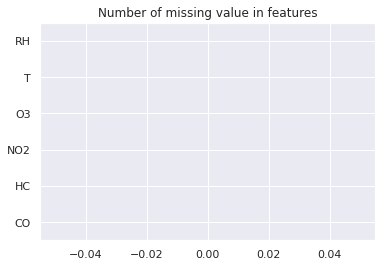

In [23]:
data.isna().sum().sort_values().plot.barh(title='Number of missing value in features')

<AxesSubplot:>

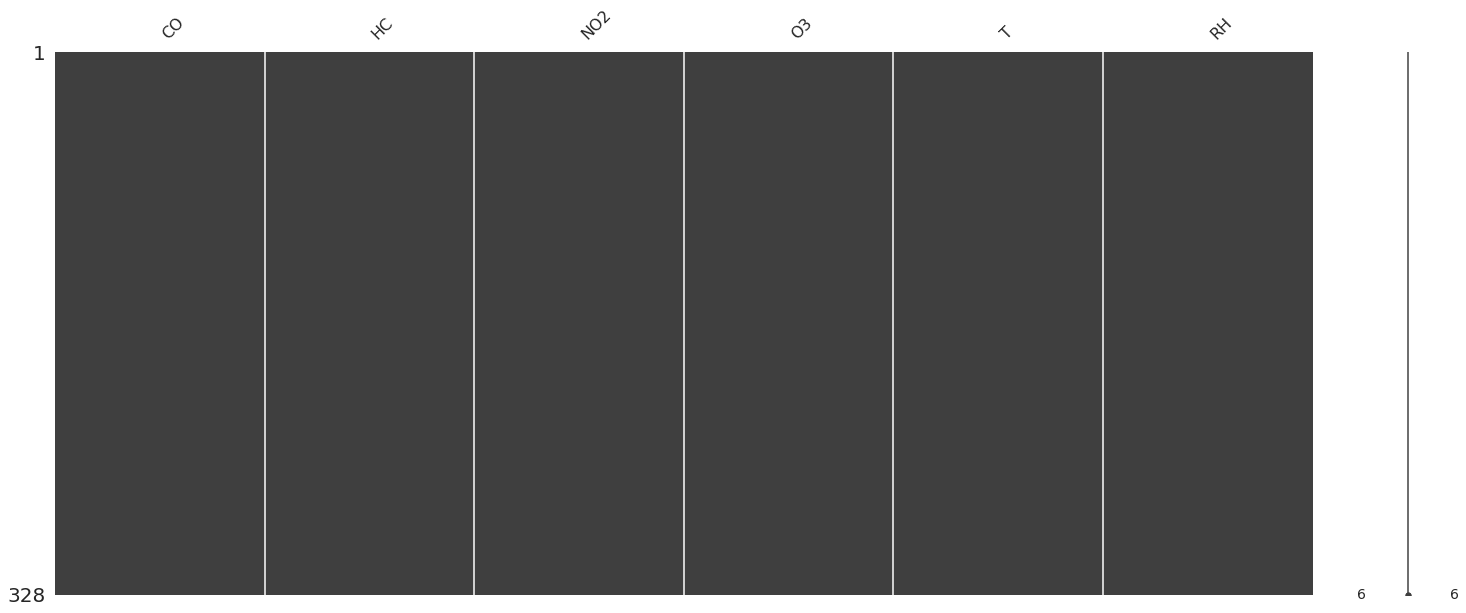

In [24]:
import missingno as msno
msno.matrix(data)

### Outliers

In [25]:
span=7
def outlier_detection(target=None,windows=7,name='My Plot',ax=plt):
    mean = target.ewm(windows).mean()
    std = target.ewm(windows).std()
    std[0] = 0 
    nostd=1.9


    is_outlier = (target > (mean + nostd*std)) | (target < (mean - nostd*std))
    


    ax.plot(target, c = 'b', label = 'Actual Values')
    ax.plot(mean, c = 'r', label = 'Exponentially Weighted Moving Average')
    ax.plot((mean + nostd*std), 'k--', label = 'Prediction Bounds')
    ax.plot((mean - nostd*std), 'k--')
    ax.set_title(name)
    ax.scatter(target[is_outlier].index, target[is_outlier], c = 'r', marker = 'o', s = 120, label = 'Outliers')
    ax.legend()
    return is_outlier

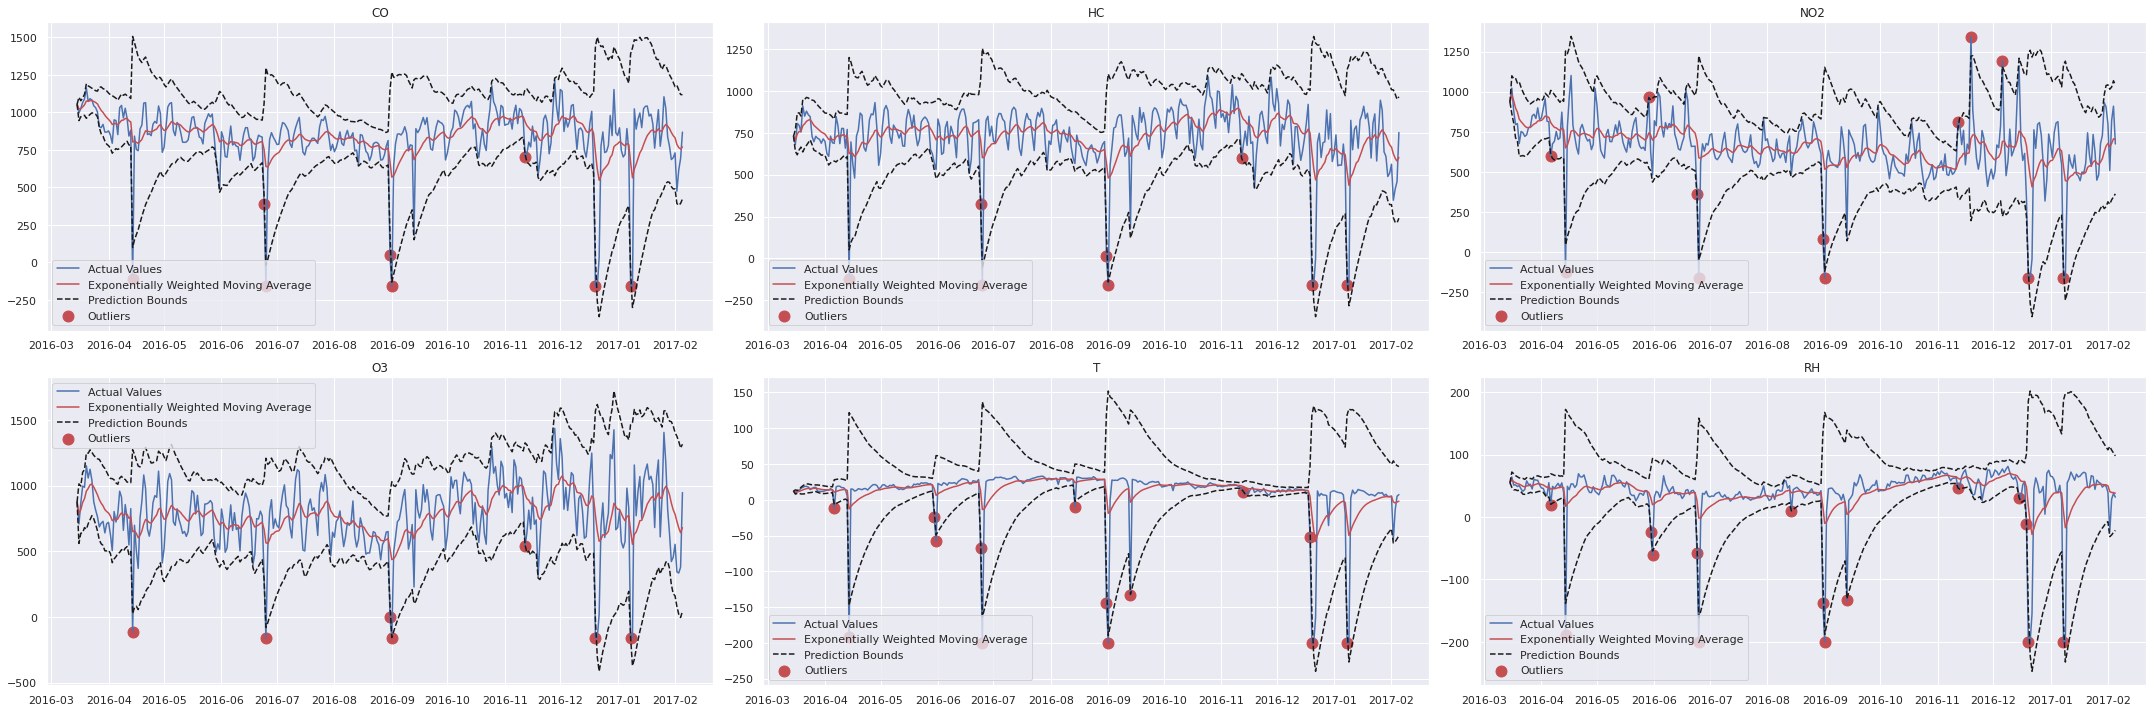

In [26]:
fig, ax = plt.subplots(2, 3, figsize=(30, 10), tight_layout=True)
ax = ax.flatten()
for col,name in enumerate(data.columns):
    outlier_detection(data[name],7,name,ax[col])

### Distribution

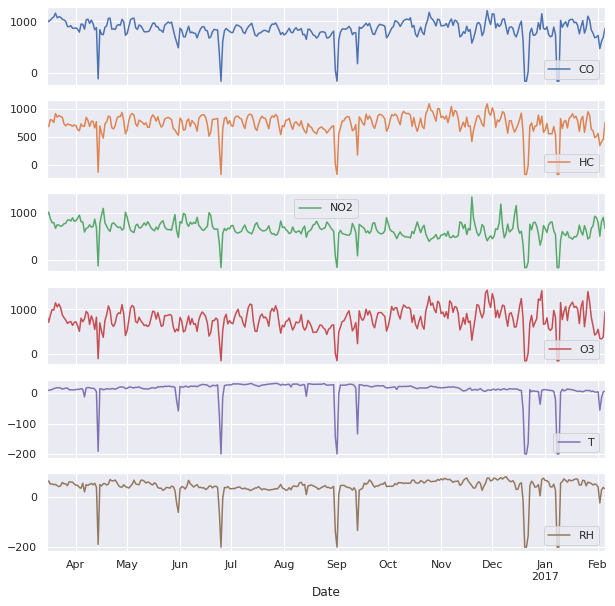

In [27]:
data.plot(subplots=True, figsize=(10, 10))
plt.show()

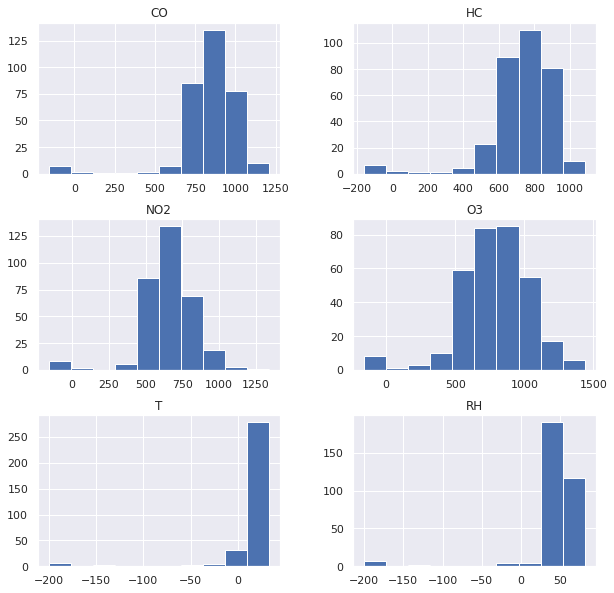

In [28]:
data.hist(figsize=((10,10)))
plt.show()

### Managing Outliers

In [673]:
# nostd=1.9
# def outlierslocation(target):
#     mean = target.ewm(7).mean()
#     std = target.ewm(7).std()
#     std[0] = 0 

#     is_outlier = (target > (mean + nostd*std)) | (target < (mean - nostd*std))
#     return is_outlier

In [31]:
# # for feauture in data.columns:
# #     data[feauture][outlierslocation(data[feauture])]=np.nan
cdata=data

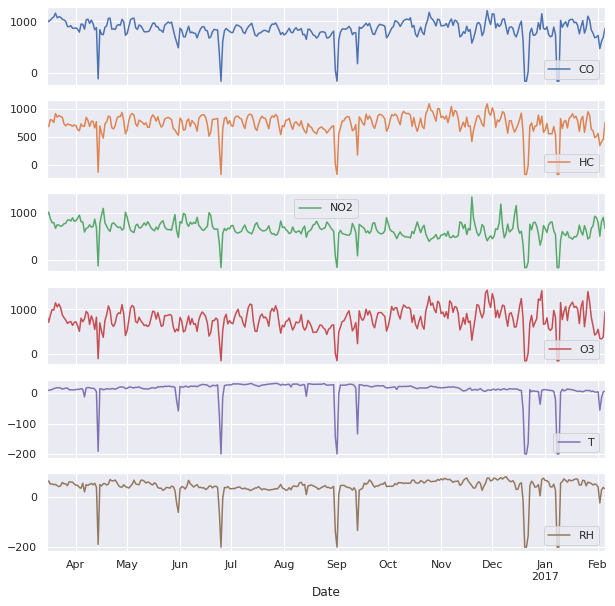

In [32]:
cdata.plot(subplots=True, figsize=(10, 10))
plt.show()

### Seasonal and Trend decomposition using Loess

In [33]:
def strength(stl=None,element='Unknown element',record=pd.DataFrame({'Name':[],'Seasonality':[],'Trend':[]})):
    trend=max(0,1-(stl.resid.var())/(stl.trend+stl.resid).var())
    season=max(0,1-(stl.resid.var())/(stl.seasonal+stl.resid).var())
    print('The trend and seasonality have a strength of '+str(trend)+', '+str(season)+' respectively.')
    record=pd.concat([record,pd.DataFrame({'Name':[element],'Seasonality':[season],'Trend':[trend]})],ignore_index=True)
    return pd.DataFrame({'Name':[element],'Seasonality':[season],'Trend':[trend]}),record
    

In [34]:
from statsmodels.tsa.seasonal import STL
def STLDecomposition(target,):
    stl = STL(target,robust=True)
    res = stl.fit()
    fig = res.plot()
    return res

The trend and seasonality have a strength of 0.2343178064071222, 0.006152148821640613 respectively.


,Name,Seasonality,Trend
0,CO,0.006152,0.234318


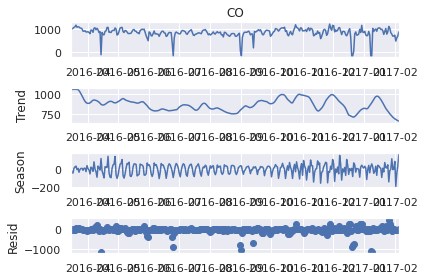

In [35]:
current,record=strength(STLDecomposition(cdata.CO),'CO')
current


The trend and seasonality have a strength of 0.07214286862910746, 0 respectively.


,Name,Seasonality,Trend
0,Temperature,0,0.072143


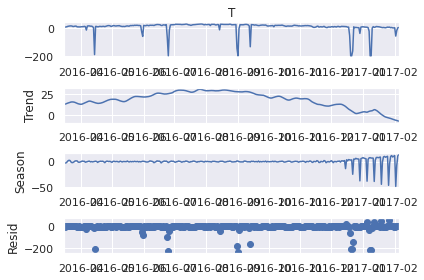

In [36]:
current,record=strength(STLDecomposition(cdata['T']),'Temperature',record)
current


The trend and seasonality have a strength of 0.22432705428697508, 0.04864076779543569 respectively.


,Name,Seasonality,Trend
0,NO2,0.048641,0.224327


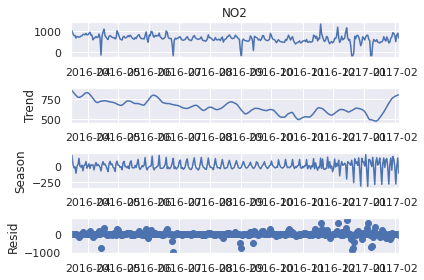

In [37]:
current,record=strength(STLDecomposition(cdata['NO2']),'NO2',record)
current



The trend and seasonality have a strength of 0.08315474712997395, 0.0004326208435508905 respectively.


,Name,Seasonality,Trend
0,Relative Humidity,0.000433,0.083155


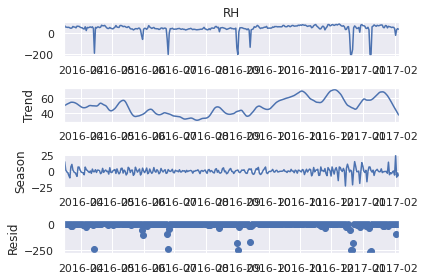

In [38]:
current,record=strength(STLDecomposition(cdata['RH']),'Relative Humidity',record)
current


The trend and seasonality have a strength of 0.29912672414132824, 0.1427559750892914 respectively.


,Name,Seasonality,Trend
0,O3,0.142756,0.299127


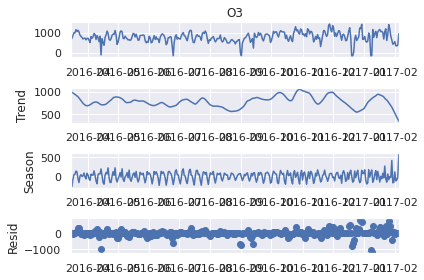

In [39]:

current,record=strength(STLDecomposition(cdata['O3']),'O3',record)
current



The trend and seasonality have a strength of 0.24154529359196897, 0.09162923898139386 respectively.


,Name,Seasonality,Trend
0,HC,0.091629,0.241545


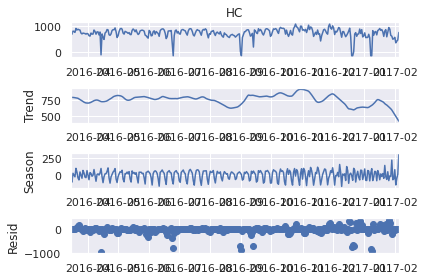

In [40]:

current,record=strength(STLDecomposition(cdata['HC']),'HC',record)
current



### Measuring Trend and Seasonality

In [41]:
record

,Name,Seasonality,Trend
0,CO,0.006152,0.234318
1,Temperature,0.000000,0.072143
2,NO2,0.048641,0.224327
3,Relative Humidity,0.000433,0.083155
4,O3,0.142756,0.299127
5,HC,0.091629,0.241545


## Modelling and Evaluation

In [42]:
import warnings
warnings.filterwarnings("ignore")

In [43]:
def EvaluationCV(data,columns,algorithm=ExponentialSmoothing,name='Unknown',n=5,ari=None,parameter=dict({
    'CO':dict({
    }),
    'NO2':dict({
    }),
    'O3':dict({
    }),
    'HC':dict({
    })
}),exog=None,record=pd.DataFrame({"Component":[],'Train RMSE':[],'Test RMSE':[]})):
    learningcurve=[0,0,0,0]
    learningcurve[0]=[]
    learningcurve[1]=[]
    learningcurve[2]=[]
    learningcurve[3]=[]
    current=pd.DataFrame({"Component":[],'Train RMSE':[],'Test RMSE':[]})
    lasttestrmse=[]
    lasttrainrmse=[]
    if ari==False:
        fig, ax = plt.subplots(2, 2, figsize=(13, 13))
        ax = ax.flatten()
        axcount=0

    for ind,feature in enumerate(columns):
        testrmse=[]
        trainrmse=[]
        instances=[]
        count=0
        for train_index, test_index in TimeSeriesSplit(n_splits=n).split(data[feature]):
            count=count+1
            if exog:

                model=algorithm(data[feature][train_index],**(parameter[feature]),exog=data[exog].iloc[train_index,0:2]).fit()
                y_pred=model.predict(min(data[feature][test_index].index),max(data[feature][test_index].index),exog=data[exog].iloc[test_index,0:2])
            else:
                model=algorithm(data[feature][train_index],**(parameter[feature])).fit()
                y_pred=model.predict(min(data[feature][test_index].index),max(data[feature][test_index].index))
            if count==n and ari==True:
                model.plot_diagnostics(figsize=((8,5)))
                lasttestrmse.append(mean_squared_error(data[feature][test_index], y_pred, squared=False))
                lasttrainrmse.append(mean_squared_error(data[feature][train_index], model.predict(min(data[feature][train_index].index),max(data[feature][train_index].index)), squared=False))
            elif count==n:
                model.resid.plot(ax=ax[axcount])
                ax[axcount].set_title('Residuel plot for '+feature)
                axcount=axcount+1
                lasttestrmse.append(mean_squared_error(data[feature][test_index], y_pred, squared=False))
                lasttrainrmse.append(mean_squared_error(data[feature][train_index], model.predict(min(data[feature][train_index].index),max(data[feature][train_index].index)), squared=False))
            instances.append(len(train_index))
            testrmse.append(mean_squared_error(data[feature][test_index], y_pred, squared=False))
            trainrmse.append(mean_squared_error(data[feature][train_index], model.predict(min(data[feature][train_index].index),max(data[feature][train_index].index)), squared=False))
        learningcurve[ind].append(instances)
        learningcurve[ind].append(trainrmse)
        learningcurve[ind].append(testrmse)
        current=pd.concat([record,current,pd.DataFrame({"Component":[name+' on '+feature],'Train RMSE':[sum(trainrmse)/len(trainrmse)],'Test RMSE':[sum(testrmse)/len(testrmse)]})])
    lastprediction=pd.DataFrame({'Feature':columns,'Last Train RMSE':lasttrainrmse,'Last Test RMSE':lasttestrmse})
    return current,record,lastprediction,learningcurve


### Exponential Smoothing

In [46]:
parameter=dict({
    'CO':dict({
#         'seasonal':'add',
        'seasonal_periods':7
    }),
    'NO2':dict({
#           'trend':'mul',
#         'seasonal':'add',
         'seasonal_periods':7
    }),
    'O3':dict({

#         'seasonal':'mul',
         'seasonal_periods':7
    }),
    'HC':dict({
#           'trend':'mul',
#         'seasonal':'mul',
         'seasonal_periods':7
    })
})

,Feature,Last Train RMSE,Last Test RMSE
0,CO,155.135974,334.491905
1,NO2,157.435206,291.545902
2,O3,197.605031,394.713038
3,HC,152.579607,308.309872


,Component,Train RMSE,Test RMSE
0,Exponential Smoothing on CO,160.307528,202.151841
0,Exponential Smoothing on NO2,157.249229,186.353098
0,Exponential Smoothing on O3,199.415166,283.978463
0,Exponential Smoothing on HC,151.269315,190.317802


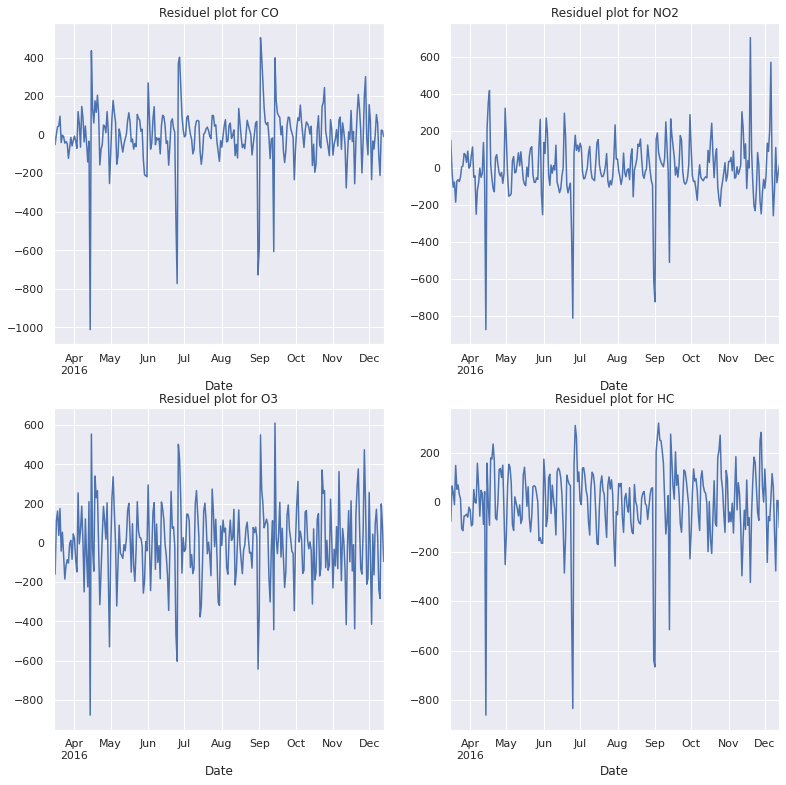

In [47]:
current,record,lastprediction,lr=EvaluationCV(cdata,['CO','NO2','O3','HC'],ExponentialSmoothing,'Exponential Smoothing',5,False,parameter)
display(lastprediction)
current

,Feature,Last Train RMSE,Last Test RMSE
0,CO,155.135974,334.491905
1,NO2,157.435206,291.545902
2,O3,197.605031,394.713038
3,HC,152.579607,308.309872


,Component,Train RMSE,Test RMSE
0,Exponential Smoothing on CO,160.307528,202.151841
0,Exponential Smoothing on NO2,157.249229,186.353098
0,Exponential Smoothing on O3,199.415166,283.978463
0,Exponential Smoothing on HC,151.269315,190.317802


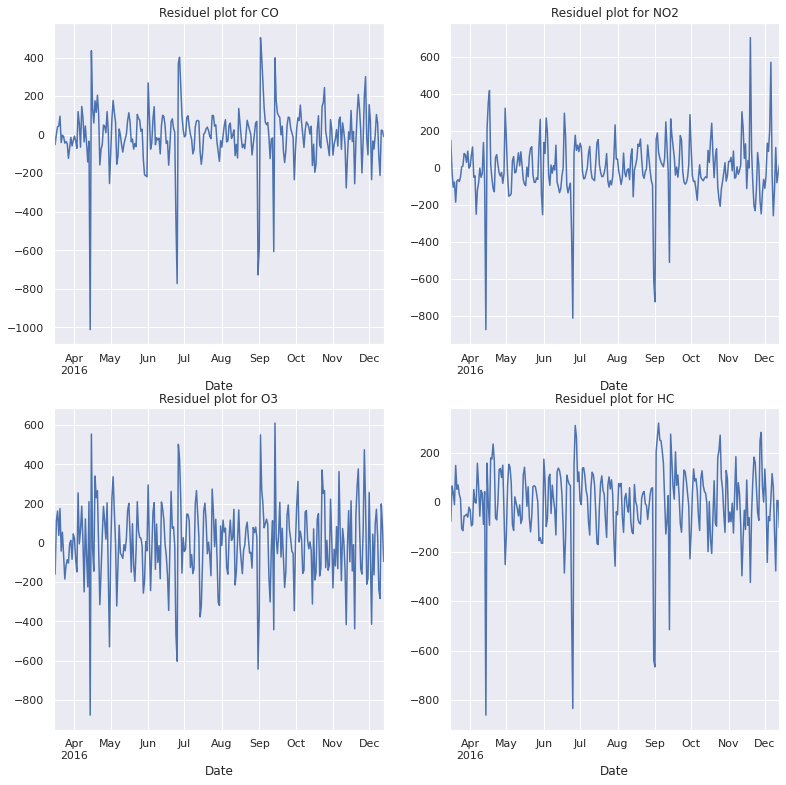

In [48]:
current,record,lastprediction,lr=EvaluationCV(cdata,['CO','NO2','O3','HC'],ExponentialSmoothing,'Exponential Smoothing',5,False,parameter)
display(lastprediction)
current

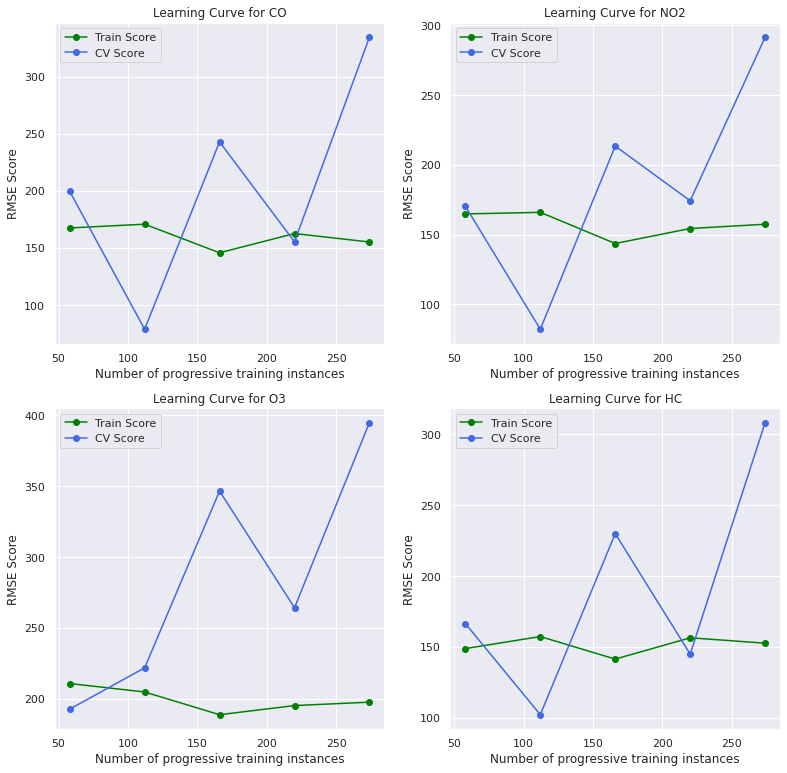

In [49]:
fig, ax = plt.subplots(2, 2, figsize=(13, 13))
ax = ax.flatten()
for ind,feature in enumerate(['CO','NO2','O3','HC']):
    ax[ind].plot(lr[ind][0],lr[ind][1],label='Train Score',color='green',marker='o')
    ax[ind].plot(lr[ind][0],lr[ind][2],label='CV Score',color='royalblue',marker='o')
    ax[ind].set_title('Learning Curve for '+feature)
    ax[ind].set_xlabel('Number of progressive training instances')
    ax[ind].set_ylabel('RMSE Score')
    ax[ind].legend()

### ARIMA

#### Test for Stationary

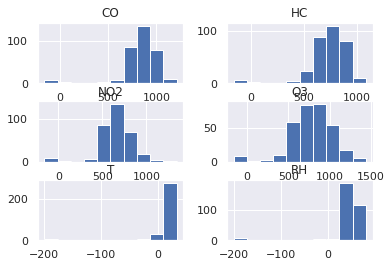

In [54]:
cdata.hist()
plt.show()

In [55]:
def adftest(df, significance_level = 0.05):
    for feature in df.columns:
        print('-----------'+feature+'-------------')
        print(f"Test for Stationarity: {significance_level}\nH0: It is non-stationary \nH1: It is stationary")
        test_statistic, pvalue, usedlag,*w, = adfuller(df[feature])
        print(f"p-value: {pvalue:.3f}")
        print(f"Used Lag: {usedlag}")
        if pvalue < significance_level:
            print("Since the p-values of "+str(pvalue)+"is <a=0.05.There is sufficient evidence to reject H0 that the data is non-stationary.")
        else:
            print("Since the p-values of "+str(pvalue)+"is >a=0.05. There is insufficient evidence to reject H0 that the data is non-stationary.")
        print('----------------------------------')

In [56]:
adftest(cdata)

-----------CO-------------
Test for Stationarity: 0.05
H0: It is non-stationary 
H1: It is stationary
p-value: 0.000
Used Lag: 1
Since the p-values of 2.6870035539955553e-16is <a=0.05.There is sufficient evidence to reject H0 that the data is non-stationary.
----------------------------------
-----------HC-------------
Test for Stationarity: 0.05
H0: It is non-stationary 
H1: It is stationary
p-value: 0.000
Used Lag: 1
Since the p-values of 1.2969233046266435e-16is <a=0.05.There is sufficient evidence to reject H0 that the data is non-stationary.
----------------------------------
-----------NO2-------------
Test for Stationarity: 0.05
H0: It is non-stationary 
H1: It is stationary
p-value: 0.000
Used Lag: 1
Since the p-values of 1.3789238914806102e-17is <a=0.05.There is sufficient evidence to reject H0 that the data is non-stationary.
----------------------------------
-----------O3-------------
Test for Stationarity: 0.05
H0: It is non-stationary 
H1: It is stationary
p-value: 0.000


#### Selecting the Order of the ARIMA Model

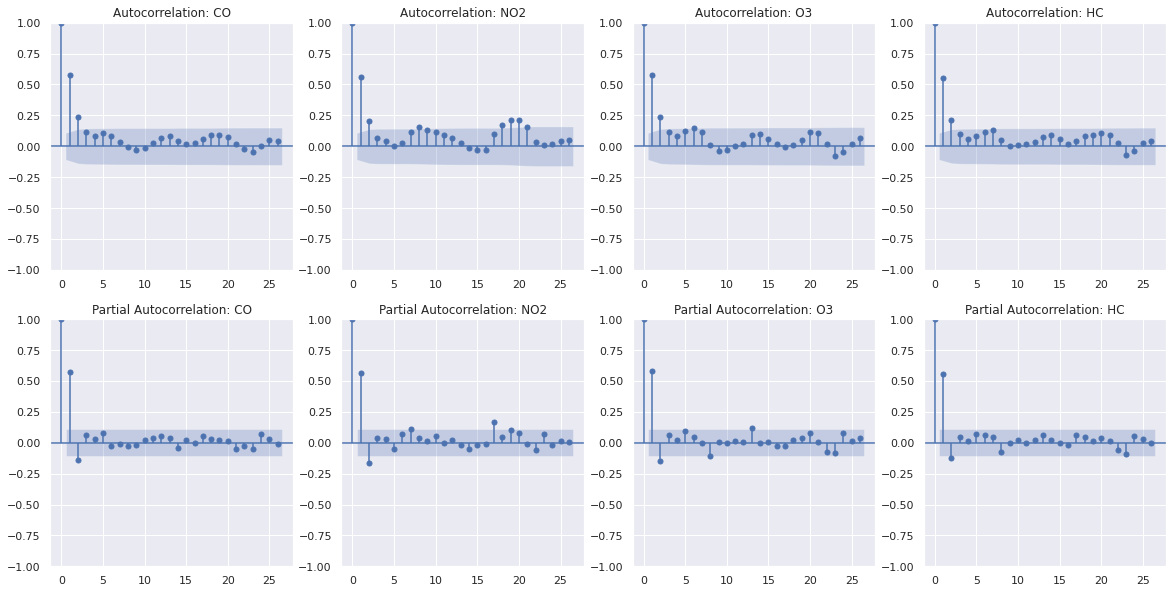

In [57]:
fig, ax = plt.subplots(2, 4, figsize=(20, 10))

for i, plot in enumerate([plot_acf, plot_pacf],0):
    for j, gas in enumerate(['CO','NO2','O3','HC'], 0):
        
        plot(cdata[gas], ax=ax[i,j])
        ax[i,j].set_title(ax[i,j].title._text + ': ' + gas)
    

In [58]:
pd.DataFrame({'Name':['CO','NO2','O3','HC'],'Order':['(1,0,2)','(2,0,2)','(2,0,2)','(1,0,2)']})

,Name,Order
0,CO,"(1,0,2)"
1,NO2,"(2,0,2)"
2,O3,"(2,0,2)"
3,HC,"(1,0,2)"


In [59]:
from pmdarima.arima import auto_arima
def arimamodel(timeseriesarray, exogenous=cdata[['T','RH']]):
    autoarima_model = auto_arima(timeseriesarray, 
                              start_p=0, # auto-regressive (AR)
                              start_q=0, # moving average
                              test="adf", # ADF Augmented Dickey-Fuller test.
                            max_d=4, max_p=4,max_q=4,stationary=True,
                                     exogenous=exogenous,max_order=None
)
    return autoarima_model



In [60]:
current=pd.DataFrame({'Name':[],'Order':[]})
for feature in ['CO','NO2','O3','HC']:
    arima_model = arimamodel(cdata[feature])
    parameter = arima_model.get_params().get('order')
    now=pd.DataFrame({'Name':[feature],'Order':[parameter]})
    current=pd.concat([current,now])
current

,Name,Order
0,CO,"(0, 0, 3)"
0,NO2,"(1, 0, 3)"
0,O3,"(0, 0, 2)"
0,HC,"(2, 0, 0)"


,Feature,Last Train RMSE,Last Test RMSE
0,CO,69.49550,101.50284
1,NO2,104.94032,154.57842
2,O3,140.23904,251.65767
3,HC,84.98875,122.66472


,Component,Train RMSE,Test RMSE
0,ARIMA on CO,66.46117,123.25631
0,ARIMA on NO2,88.35335,148.04473
0,ARIMA on O3,131.95594,218.10398
0,ARIMA on HC,75.08477,118.21494


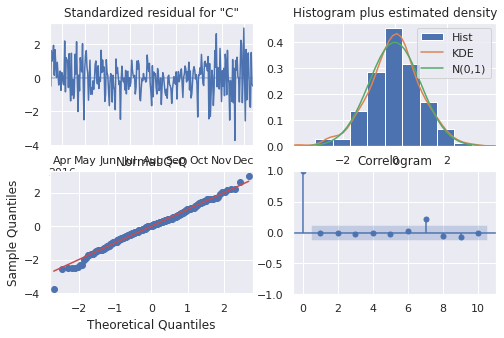

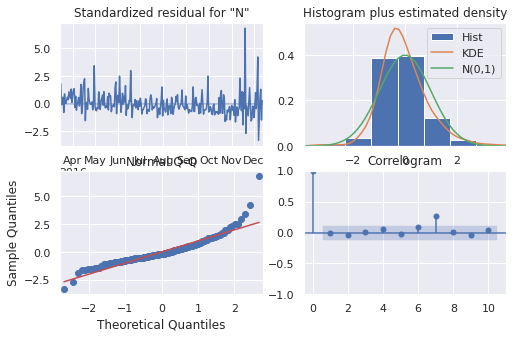

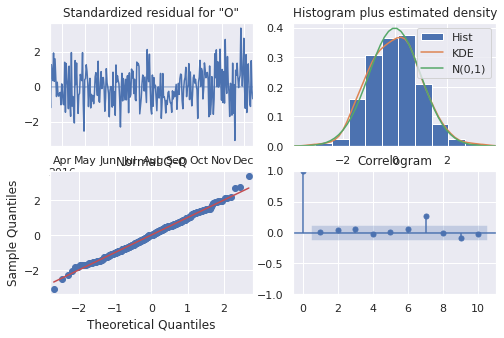

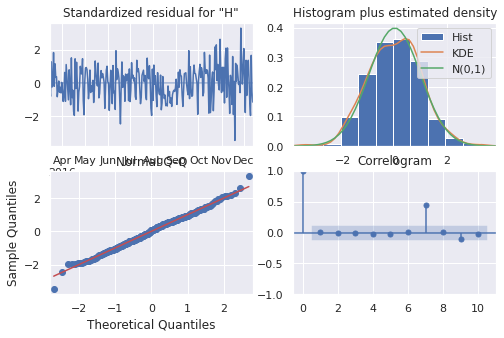

In [252]:
pd.options.display.float_format = '{:.5f}'.format
parameter=dict({
    'CO':dict({
        'order':(1, 0, 2),
    }),
    'NO2':dict({
        'order':(0, 0, 3),
        
    }),
    'O3':dict({

        'order':(0, 0, 2),

    }),
    'HC':dict({
        'order':(1, 0, 2)
    })
})


parameter=dict({
    'CO':dict({
        'order':(1, 0, 2),
    }),
    'NO2':dict({
        'order':(2, 0, 2),
        
    }),
    'O3':dict({

        'order':(0, 0, 2),

    }),
    'HC':dict({
        'order':(1, 0, 2)
    })
})
current,record,lastprediction,lr=EvaluationCV(cdata,['CO','NO2','O3','HC'],ARIMA,'ARIMA',5,True,parameter,['T','RH'])
display(lastprediction)
current

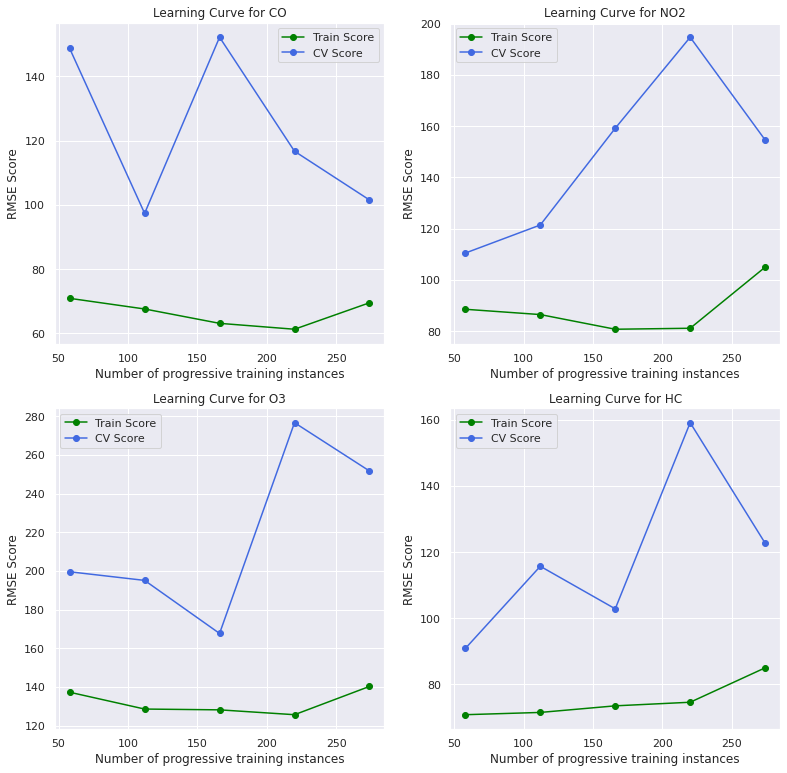

In [253]:
fig, ax = plt.subplots(2, 2, figsize=(13, 13))
ax = ax.flatten()
for ind,feature in enumerate(['CO','NO2','O3','HC']):
    ax[ind].plot(lr[ind][0],lr[ind][1],label='Train Score',color='green',marker='o')
    ax[ind].plot(lr[ind][0],lr[ind][2],label='CV Score',color='royalblue',marker='o')
    ax[ind].set_title('Learning Curve for '+feature)
    ax[ind].set_xlabel('Number of progressive training instances')
    ax[ind].set_ylabel('RMSE Score')
    ax[ind].legend()

In [134]:
def HanGridSearchCV(odata,ft,arimax=True):
    bestresult=300
    finalaccuracy=300
    nick=500
    data=odata[ft].copy()
    for P in np.arange(0,5):
        for Q in np.arange(0,6):
            order = (P,0,Q)
            temp=[]
            count=0
            for train_index, test_index in TimeSeriesSplit(n_splits=5).split(data):
                count=count+1
                model=ARIMA(data[train_index],order=order,exog=odata[['T','RH']].iloc[train_index,0:2]).fit()
                y_pred=model.predict(min(data[test_index].index),max(data[test_index].index),exog=odata[['T','RH']].iloc[test_index,0:2])
                temp.append(mean_squared_error(data[test_index], y_pred, squared=False))

            if (temp[4])<finalaccuracy:
                bestresult=(P,0,Q)
                finalaccuracy=temp[4]
                nick=sum(temp)/len(temp)
    return bestresult,finalaccuracy,nick
bestresult,finalaccuracy,nick=HanGridSearchCV(cdata,'NO2')
finalaccuracy

154.34033413429472

In [149]:
bestresult

(0, 0, 3)

### SARIMAX

#### Seasonal Order

In [87]:
slag = [i*7 for i in range(13)]
slag

[0, 7, 14, 21, 28, 35, 42, 49, 56, 63, 70, 77, 84]

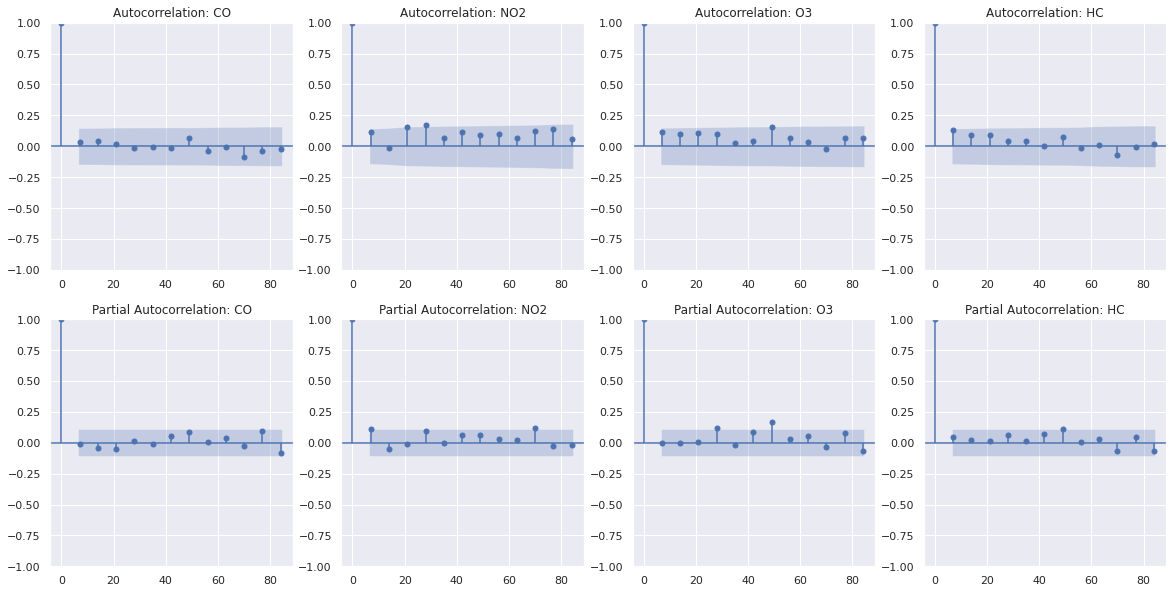

In [88]:
fig, ax = plt.subplots(2, 4, figsize=(20, 10))

for i, plot in enumerate([plot_acf, plot_pacf],0):
    for j, gas in enumerate(['CO','NO2','O3','HC'], 0):
        
        plot(cdata[gas], ax=ax[i,j], lags=slag)
        ax[i,j].set_title(ax[i,j].title._text + ': ' + gas)

In [529]:
pd.DataFrame({'Name':['CO','NO2','O3','HC'],'Seasonal Order':['(0,0,0,7)','(0,0,0,7)','(0,0,0,7)','(0,0,0,7)']})

,Name,Seasonal Order
0,CO,"(0,0,0,7)"
1,NO2,"(0,0,1,7)"
2,O3,"(0,0,1,7)"
3,HC,"(0,0,1,7)"


In [89]:
from pmdarima.arima import auto_arima
def sarimamodel(timeseriesarray, exogenous=cdata[['T','RH']]):
    autoarima_model = auto_arima(timeseriesarray, 
                              start_p=0, # auto-regressive (AR)
                              start_q=0, # moving average
                              test="adf", # ADF Augmented Dickey-Fuller test.
                            max_d=4, max_p=4,max_q=4,stationary=True,max_P=7,max_Q=7,start_P=0,start_Q=0,
                                     exogenous=exogenous,max_order=20,seasonal=True,m=7,n_jobs=-1
)
    return autoarima_model

current=pd.DataFrame({'Name':[],'Order':[]})
for feature in ['CO','NO2','O3','HC']:
    sarima_model = sarimamodel(cdata[feature])
    print( sarima_model.summary())
    parameter = sarima_model.get_params()

    now=pd.DataFrame({'Name':[feature],'Order':[str(parameter['order'])+str(parameter['seasonal_order'])]})
    current=pd.concat([current,now])
current

                                       SARIMAX Results                                        
Dep. Variable:                                      y   No. Observations:                  328
Model:             SARIMAX(1, 0, 0)x(1, 0, [1, 2], 7)   Log Likelihood               -1862.414
Date:                                Fri, 08 Jul 2022   AIC                           3740.827
Time:                                        12:59:19   BIC                           3771.172
Sample:                                    03-15-2016   HQIC                          3752.934
                                         - 02-05-2017                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     36.7663     23.564      1.560      0.119      -9.418      82.951
T  

,Name,Order
0,CO,"(1, 0, 0)(1, 0, 2, 7)"
0,NO2,"(1, 0, 0)(1, 0, 1, 7)"
0,O3,"(2, 0, 2)(1, 0, 1, 7)"
0,HC,"(1, 0, 0)(2, 0, 1, 7)"


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.81208D+00    |proj g|=  6.78548D-02

At iterate    5    f=  6.75112D+00    |proj g|=  1.50921D-02

At iterate   10    f=  6.57804D+00    |proj g|=  5.09885D-02

At iterate   15    f=  6.40548D+00    |proj g|=  8.58225D-03

At iterate   20    f=  6.38887D+00    |proj g|=  2.40577D-02

At iterate   25    f=  6.31790D+00    |proj g|=  4.39932D-02

At iterate   30    f=  5.90407D+00    |proj g|=  9.44066D-02

At iterate   35    f=  5.80436D+00    |proj g|=  1.69643D-02

At iterate   40    f=  5.80002D+00    |proj g|=  3.36237D-03

At iterate   45    f=  5.79915D+00    |proj g|=  1.13514D-03

At iterate   50    f=  5.79907D+00    |proj g|=  2.92141D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  6.45394D+00    |proj g|=  6.28823D-02

At iterate   15    f=  6.43507D+00    |proj g|=  3.94699D-03

At iterate   20    f=  6.41113D+00    |proj g|=  3.51732D-02

At iterate   25    f=  5.83732D+00    |proj g|=  1.65621D-01

At iterate   30    f=  5.68291D+00    |proj g|=  2.55763D-03

At iterate   35    f=  5.68285D+00    |proj g|=  1.39981D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     35     52      1     0     0   1.400D-05   5.683D+00
  F =   5.6828456178782814     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   10    f=  6.67750D+00    |proj g|=  4.86257D-02

At iterate   15    f=  6.58317D+00    |proj g|=  2.97052D-02

At iterate   20    f=  6.54341D+00    |proj g|=  1.07295D-02

At iterate   25    f=  6.20606D+00    |proj g|=  4.52934D-01

At iterate   30    f=  5.72519D+00    |proj g|=  7.53474D-02

At iterate   35    f=  5.71712D+00    |proj g|=  2.60106D-04
  ys=-1.024E-01  -gs= 8.047E-04 BFGS update SKIPPED

At iterate   40    f=  5.65490D+00    |proj g|=  8.17967D-02

At iterate   45    f=  5.57442D+00    |proj g|=  3.75485D-03

At iterate   50    f=  5.57396D+00    |proj g|=  1.75379D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  

 This problem is unconstrained.



At iterate   25    f=  5.75874D+00    |proj g|=  1.98995D-01

At iterate   30    f=  5.68750D+00    |proj g|=  3.69126D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     50      1     0     0   1.119D-05   5.688D+00
  F =   5.6875013477926659     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.79036D+00    |proj g|=  1.16816D-01

At iterate    5    f=  6.49819D+00    |proj g|=  1.12020D-02

At iter

 This problem is unconstrained.



At iterate   25    f=  5.76556D+00    |proj g|=  3.58501D-02

At iterate   30    f=  5.76357D+00    |proj g|=  2.95961D-05

At iterate   35    f=  5.76356D+00    |proj g|=  5.07630D-04

At iterate   40    f=  5.76318D+00    |proj g|=  9.82454D-03

At iterate   45    f=  5.75297D+00    |proj g|=  1.35137D-02

At iterate   50    f=  5.75205D+00    |proj g|=  5.76496D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     81      1     0     0   5.765D-04   5.752D+00
  F =   5.7520469868438600     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  6.63173D+00    |proj g|=  1.01647D-02

At iterate   10    f=  6.59976D+00    |proj g|=  2.96640D-02

At iterate   15    f=  6.42155D+00    |proj g|=  3.15902D-02

At iterate   20    f=  6.39425D+00    |proj g|=  1.17969D-02

At iterate   25    f=  6.28309D+00    |proj g|=  1.36182D-01

At iterate   30    f=  6.20118D+00    |proj g|=  1.48147D-02

At iterate   35    f=  6.19981D+00    |proj g|=  2.33913D-03

At iterate   40    f=  6.19959D+00    |proj g|=  5.91805D-04

At iterate   45    f=  6.19950D+00    |proj g|=  1.31813D-03
  ys=-2.549E-02  -gs= 2.132E-04 BFGS update SKIPPED

At iterate   50    f=  6.19301D+00    |proj g|=  1.10294D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final 

 This problem is unconstrained.



At iterate    5    f=  6.63141D+00    |proj g|=  1.95308D-02

At iterate   10    f=  6.46056D+00    |proj g|=  4.31277D-02

At iterate   15    f=  6.41171D+00    |proj g|=  5.20274D-03

At iterate   20    f=  6.36835D+00    |proj g|=  7.77319D-02

At iterate   25    f=  6.33010D+00    |proj g|=  5.53123D-03

At iterate   30    f=  6.25983D+00    |proj g|=  2.16106D-02

At iterate   35    f=  5.96100D+00    |proj g|=  5.74628D-02

At iterate   40    f=  5.93672D+00    |proj g|=  2.64712D-03

At iterate   45    f=  5.93450D+00    |proj g|=  1.05862D-02

At iterate   50    f=  5.93238D+00    |proj g|=  9.55616D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   40    f=  5.98160D+00    |proj g|=  9.71650D-03
  ys=-9.642E-02  -gs= 1.476E-02 BFGS update SKIPPED

At iterate   45    f=  5.84164D+00    |proj g|=  1.99027D-02

At iterate   50    f=  5.84051D+00    |proj g|=  1.77379D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     71      1     1     0   1.774D-03   5.841D+00
  F =   5.8405069316512552     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0  

 This problem is unconstrained.



At iterate   15    f=  6.27339D+00    |proj g|=  2.84118D-02

At iterate   20    f=  5.98654D+00    |proj g|=  8.93846D-02

At iterate   25    f=  5.86528D+00    |proj g|=  9.62437D-03

At iterate   30    f=  5.84559D+00    |proj g|=  5.65600D-02

At iterate   35    f=  5.81013D+00    |proj g|=  2.07859D-02

At iterate   40    f=  5.80754D+00    |proj g|=  1.02575D-02

At iterate   45    f=  5.80419D+00    |proj g|=  6.14640D-03

At iterate   50    f=  5.80371D+00    |proj g|=  3.45405D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     62      1     0     0   3.454D-03   5.804D+00
  F =   5.80371323591

 This problem is unconstrained.



At iterate   25    f=  6.31814D+00    |proj g|=  1.65869D-02

At iterate   30    f=  6.10852D+00    |proj g|=  2.08898D-01

At iterate   35    f=  6.07210D+00    |proj g|=  8.06450D-04

At iterate   40    f=  6.07178D+00    |proj g|=  1.18411D-02

At iterate   45    f=  6.06588D+00    |proj g|=  2.54273D-02

At iterate   50    f=  6.06216D+00    |proj g|=  2.38736D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     60      1     0     0   2.387D-03   6.062D+00
  F =   6.0621585877961541     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  6.82545D+00    |proj g|=  1.02862D-02

At iterate   10    f=  6.64364D+00    |proj g|=  1.91220D-02

At iterate   15    f=  6.62786D+00    |proj g|=  5.20965D-02

At iterate   20    f=  6.60017D+00    |proj g|=  3.20112D-02

At iterate   25    f=  6.59498D+00    |proj g|=  1.78501D-02

At iterate   30    f=  6.48967D+00    |proj g|=  9.04158D-02

At iterate   35    f=  6.33827D+00    |proj g|=  3.75880D-03

At iterate   40    f=  6.33821D+00    |proj g|=  2.34154D-04

At iterate   45    f=  6.33802D+00    |proj g|=  1.17763D-02

At iterate   50    f=  6.32288D+00    |proj g|=  3.44070D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.74615D+00    |proj g|=  1.97179D+00

At iterate    5    f=  6.79035D+00    |proj g|=  9.70621D-02

At iterate   10    f=  6.76914D+00    |proj g|=  2.82312D-02

At iterate   15    f=  6.59950D+00    |proj g|=  1.73607D-02

At iterate   20    f=  6.58377D+00    |proj g|=  8.99382D-03

At iterate   25    f=  6.57675D+00    |proj g|=  4.17383D-03

At iterate   30    f=  6.53220D+00    |proj g|=  4.53499D-02


 This problem is unconstrained.



At iterate   35    f=  6.51065D+00    |proj g|=  1.57493D-02

At iterate   40    f=  6.37586D+00    |proj g|=  1.34220D-01

At iterate   45    f=  6.28265D+00    |proj g|=  2.61821D-03

At iterate   50    f=  6.27955D+00    |proj g|=  4.94499D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     61      1     0     0   4.945D-03   6.280D+00
  F =   6.2795462370266151     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   15    f=  6.61465D+00    |proj g|=  6.51665D-02

At iterate   20    f=  6.58358D+00    |proj g|=  3.09766D-03

At iterate   25    f=  6.56996D+00    |proj g|=  3.50169D-02

At iterate   30    f=  6.49160D+00    |proj g|=  1.10959D-02

At iterate   35    f=  6.45553D+00    |proj g|=  5.97969D-02

At iterate   40    f=  6.38675D+00    |proj g|=  8.64898D-03

At iterate   45    f=  6.38529D+00    |proj g|=  2.53996D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     49     62      1     0     0   3.654D-05   6.385D+00
  F =   6.3852785806513070     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  6.74706D+00    |proj g|=  1.60736D-02

At iterate   10    f=  6.64643D+00    |proj g|=  2.14577D-01

At iterate   15    f=  6.49135D+00    |proj g|=  1.59991D-02

At iterate   20    f=  6.48644D+00    |proj g|=  7.79252D-03

At iterate   25    f=  6.22692D+00    |proj g|=  9.44977D-02

At iterate   30    f=  5.89027D+00    |proj g|=  2.17313D-02

At iterate   35    f=  5.88340D+00    |proj g|=  1.90729D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     37     50      1     0     0   1.010D-05   5.883D+00
  F =   5.8833950588238242     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   20    f=  6.10698D+00    |proj g|=  3.04892D-01

At iterate   25    f=  5.80556D+00    |proj g|=  1.06739D-02

At iterate   30    f=  5.80494D+00    |proj g|=  2.33210D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     31     47      1     0     0   9.583D-06   5.805D+00
  F =   5.8049357396338275     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.89871D+00    |proj g|=  1.86211D-01


 This problem is unconstrained.



At iterate    5    f=  6.64239D+00    |proj g|=  1.25658D-02

At iterate   10    f=  6.55595D+00    |proj g|=  1.45141D-01

At iterate   15    f=  6.44376D+00    |proj g|=  7.60739D-03

At iterate   20    f=  6.42950D+00    |proj g|=  2.82579D-02

At iterate   25    f=  6.06957D+00    |proj g|=  2.92428D-01

At iterate   30    f=  5.77842D+00    |proj g|=  1.02046D-02

At iterate   35    f=  5.76814D+00    |proj g|=  2.11869D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     38     49      1     0     0   2.891D-05   5.768D+00
  F =   5.7681397112512718     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  6.53605D+00    |proj g|=  9.06603D-03

At iterate   10    f=  6.37850D+00    |proj g|=  3.93783D-03

At iterate   15    f=  6.36455D+00    |proj g|=  3.89645D-02

At iterate   20    f=  6.07732D+00    |proj g|=  1.62618D-01

At iterate   25    f=  5.98916D+00    |proj g|=  1.44905D-02

At iterate   30    f=  5.91646D+00    |proj g|=  1.26582D-01

At iterate   35    f=  5.89022D+00    |proj g|=  2.32610D-03

At iterate   40    f=  5.89013D+00    |proj g|=  5.56471D-04

At iterate   45    f=  5.88975D+00    |proj g|=  1.21582D-02

At iterate   50    f=  5.88928D+00    |proj g|=  2.47176D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

,Feature,Last Train RMSE,Last Test RMSE
0,CO,89.86304,101.19735
1,NO2,114.81389,165.86569
2,O3,150.88806,257.89221
3,HC,90.03614,133.42299


,Component,Train RMSE,Test RMSE
0,SARIMAX on CO,106.65033,106.52771
0,SARIMAX on NO2,125.30030,167.80547
0,SARIMAX on O3,162.31195,241.41474
0,SARIMAX on HC,95.45927,117.31122


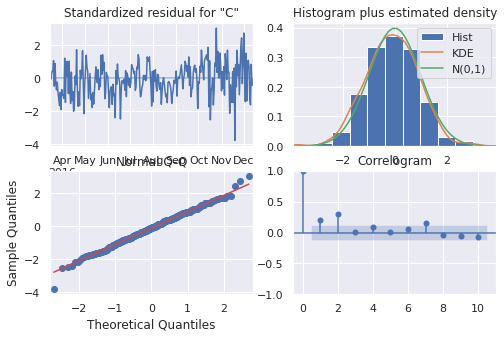

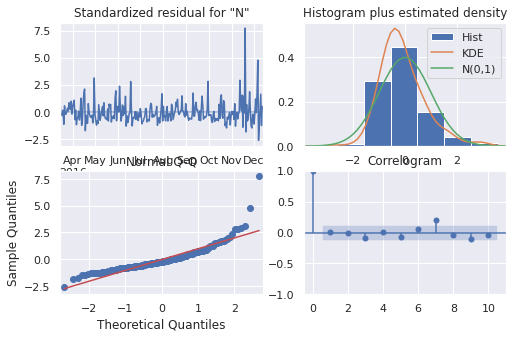

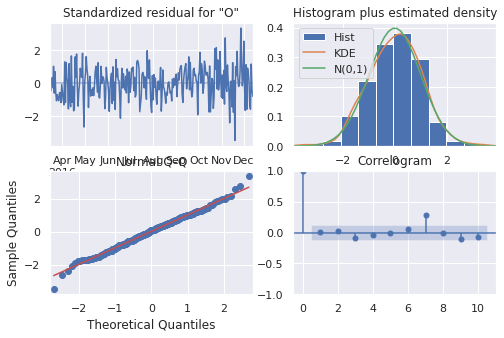

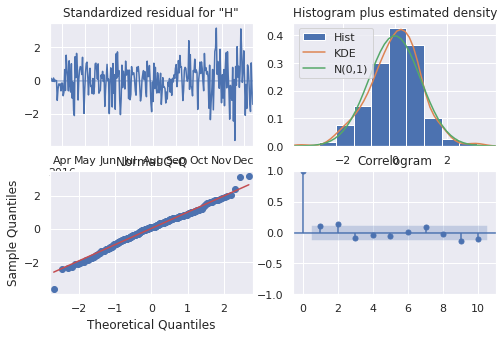

In [254]:


parameter=dict({
    'CO':dict({
        'order':(1, 0, 2),
        'seasonal_order':(0, 0, 0, 7),
        'initialization':'approximate_diffuse'
    }),
    'NO2':dict({
        'order':(2, 0, 2),
        'seasonal_order':(0, 0, 0, 7),
        'initialization':'approximate_diffuse',
#            'trend':'ct'
    }),
    'O3':dict({
        'order':(2, 0, 2),
        'seasonal_order':(0, 0, 0, 7),
        'initialization':'approximate_diffuse',

    }),
    'HC':dict({
        'order':(1, 0, 2),
        'seasonal_order':(0, 0, 1, 7),
        'initialization':'approximate_diffuse',
#         'trend':'ct'
    })
})






current,record,lastprediction,lr=EvaluationCV(cdata,['CO','NO2','O3','HC'],SARIMAX,'SARIMAX',5,True,parameter,['T','RH'])
display(lastprediction)
current

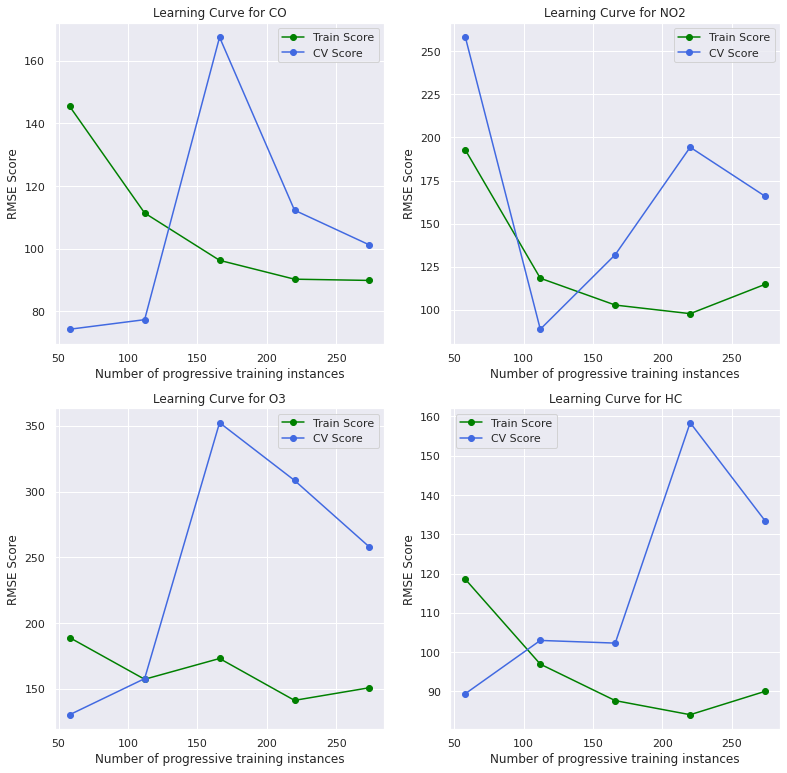

In [255]:
fig, ax = plt.subplots(2, 2, figsize=(13, 13))
ax = ax.flatten()
for ind,feature in enumerate(['CO','NO2','O3','HC']):
    ax[ind].plot(lr[ind][0],lr[ind][1],label='Train Score',color='green',marker='o')
    ax[ind].plot(lr[ind][0],lr[ind][2],label='CV Score',color='royalblue',marker='o')
    ax[ind].set_title('Learning Curve for '+feature)
    ax[ind].set_xlabel('Number of progressive training instances')
    ax[ind].set_ylabel('RMSE Score')
    ax[ind].legend()

In [176]:
def HanGridSearchCV(odata,col,arimax=True):
    re=[]
    fa=[]
    nickel=[]
    seaor=[]
    for i in col:
        
        bestresult=300
        finalaccuracy=300
        seas=500
        nick=500
        data=odata[i].copy()
        for p in np.arange(0,4):
            for q in np.arange(0,4):
                for P in np.arange(0,4):
                    for Q in np.arange(0,4):
                        order=(p,0,q)
                        seaorder = (P,0,Q,7)
                        temp=[]
                        count=0
                        for train_index, test_index in TimeSeriesSplit(n_splits=5).split(data):
                            count=count+1
                            model=SARIMAX(data[train_index],order=order,seasonal_order=seaorder,initialization='approximate_diffuse',exog=odata[['T','RH']].iloc[train_index,0:2]).fit(disp=1)
                            y_pred=model.predict(min(data[test_index].index),max(data[test_index].index),exog=odata[['T','RH']].iloc[test_index,0:2])
                            temp.append(mean_squared_error(data[test_index], y_pred, squared=False))

                        if (temp[4])<finalaccuracy:
                            bestresult=(p,0,q)
                            seas=(P,0,Q,7)
                            seas=str(seas)
                            bestresult=str(bestresult)
                            finalaccuracy=temp[4]
                            nick=sum(temp)/len(temp)
        re.append(bestresult)
        fa.append(finalaccuracy)
        nickel.append(nick)
        seaor.append(seas)
    return re,fa,nickel,seaor
bestresult,finalaccuracy,nick,sea=HanGridSearchCV(cdata,['CO','NO2','O3','HC'])


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.53773D+00    |proj g|=  4.72448D-04

At iterate    1    f=  8.26691D+00    |proj g|=  2.05315D-02

At iterate    2    f=  8.19167D+00    |proj g|=  3.32437D-02

At iterate    3    f=  8.01668D+00    |proj g|=  6.12631D-02

At iterate    4    f=  7.88173D+00    |proj g|=  1.05104D-01

At iterate    5    f=  7.29025D+00    |proj g|=  1.08584D-01
  ys=-7.942E-02  -gs= 8.214E-01 BFGS update SKIPPED

At iterate    6    f=  7.26761D+00    |proj g|=  8.99700D-02

At iterate    7    f=  7.09484D+00    |proj g|=  6.12086D-02

At iterate    8    f=  7.06147D+00    |proj g|=  1.82297D-02

At iterate    9    f=  7.04298D+00    |proj g|=  7.10787D-03

At iterate   10    f=  7.03680D+00    |proj g|=  1.30473D-02

At iterate   11    f=  7.03495D+00    |proj g|=  7.92500D-03

At iterate   12    f=  7.03380D+00  

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.61842D+00    |proj g|=  1.64187D-04

At iterate    1    f=  9.61514D+00    |proj g|=  1.64968D-04

At iterate    2    f=  9.56993D+00    |proj g|=  1.98989D-03

At iterate    3    f=  9.49722D+00    |proj g|=  4.76693D-03

At iterate    4    f=  9.38022D+00    |proj g|=  1.61110D-02

At iterate    5    f=  8.93858D+00    |proj g|=  1.27446D-02

At iterate    6    f=  8.81429D+00    |proj g|=  1.08275D-02

At iterate    7    f=  8.69147D+00    |proj g|=  8.55004D-03

At iterate    8    f=  8.59668D+00    |proj g|=  1.05269D-02

At iterate    9    f=  8.37164D+00    |proj g|=  2.31569D-02

At iterate   10    f=  8.20330D+00    |proj g|=  6.05502D-02

At iterate   11    f=  8.02877D+00    |proj g|=  8.03742D-03

At iterate   12    f=  7.58438D+00    |proj g|=  5.45200D-02

At iterate   13    f=  7.5

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.13006D+00    |proj g|=  1.58185D-01

At iterate    1    f=  7.10714D+00    |proj g|=  1.82205D-02

At iterate    2    f=  7.10673D+00    |proj g|=  8.92651D-03

At iterate    3    f=  7.10653D+00    |proj g|=  9.11451D-03

At iterate    4    f=  7.10563D+00    |proj g|=  1.34770D-02

At iterate    5    f=  7.10508D+00    |proj g|=  1.09140D-02

At iterate    6    f=  7.10428D+00    |proj g|=  6.52217D-03

At iterate    7    f=  7.10276D+00    |proj g|=  1.00168D-02

At iterate    8    f=  7.10141D+00    |proj g|=  1.92458D-02

At iterate    9    f=  7.09997D+00    |proj g|=  1.99068D-02

At iterate   10    f=  7.09919D+00    |proj g|=  4.07490D-03

At iterate   11    f=  7.09910D+00    |proj g|=  6.23284D-04

At iterate   12    f=  7.09910D+00    |proj g|=  5.17830D-04

At iterate   13    f=  7.0

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    3    f=  7.39087D+00    |proj g|=  8.54661D-02

At iterate    4    f=  7.37780D+00    |proj g|=  1.00862D-01

At iterate    5    f=  7.36857D+00    |proj g|=  5.31187D-02

At iterate    6    f=  7.36679D+00    |proj g|=  1.65032D-02

At iterate    7    f=  7.36657D+00    |proj g|=  1.74576D-03

At iterate    8    f=  7.36656D+00    |proj g|=  1.63411D-03

At iterate    9    f=  7.36653D+00    |proj g|=  3.79510D-03

At iterate   10    f=  7.36648D+00    |proj g|=  8.02999D-03

At iterate   11    f=  7.36633D+00    |proj g|=  1.45386D-02

At iterate   12    f=  7.36597D+00    |proj g|=  2.36663D-02

At iterate   13    f=  7.36520D+00    |proj g|=  3.35302D-02

At iterate   14    f=  7.36397D+00    |proj g|=  3.67348D-02

At iterate   15    f=  7.36357D+00    |proj g|=  2.30364D-02

At iterate   16    f=  7.36250D+00    |proj g|=  1.38427D-02

At iterate   17    f=  7.36233D+00    |proj g|=  4.68959D-03

At iterate   18    f=  7.36230D+00    |proj g|=  7.25460D-04

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   12    f=  7.33926D+00    |proj g|=  3.06211D-02

At iterate   13    f=  7.33754D+00    |proj g|=  1.83804D-02

At iterate   14    f=  7.33700D+00    |proj g|=  5.95853D-03

At iterate   15    f=  7.33690D+00    |proj g|=  1.99773D-03

At iterate   16    f=  7.33690D+00    |proj g|=  9.93780D-04

At iterate   17    f=  7.33689D+00    |proj g|=  6.96839D-04

At iterate   18    f=  7.33688D+00    |proj g|=  1.75690D-03

At iterate   19    f=  7.33683D+00    |proj g|=  4.59228D-03

At iterate   20    f=  7.33671D+00    |proj g|=  9.20562D-03

At iterate   21    f=  7.33640D+00    |proj g|=  1.64753D-02

At iterate   22    f=  7.33562D+00    |proj g|=  2.74631D-02

At iterate   23    f=  7.33375D+00    |proj g|=  4.34845D-02

At iterate   24    f=  7.32983D+00    |proj g|=  6.26795D-02

At iterate   25    f=  7.32369D+00    |proj g|=  7.64581D-02

At iterate   26    f=  7.31752D+00    |proj g|=  5.67180D-02

At iterate   27    f=  7.31512D+00    |proj g|=  5.56776D-02

At iter

 This problem is unconstrained.



At iterate   20    f=  7.21215D+00    |proj g|=  2.23869D-02

At iterate   21    f=  7.20836D+00    |proj g|=  3.31700D-02

At iterate   22    f=  7.19897D+00    |proj g|=  1.92778D-02

At iterate   23    f=  7.18868D+00    |proj g|=  1.11127D-02

At iterate   24    f=  7.18747D+00    |proj g|=  3.25947D-03

At iterate   25    f=  7.18738D+00    |proj g|=  1.35765D-03

At iterate   26    f=  7.18734D+00    |proj g|=  1.05911D-03

At iterate   27    f=  7.18725D+00    |proj g|=  1.39878D-03

At iterate   28    f=  7.18714D+00    |proj g|=  9.68889D-04

At iterate   29    f=  7.18701D+00    |proj g|=  2.14136D-03

At iterate   30    f=  7.18697D+00    |proj g|=  1.23010D-03

At iterate   31    f=  7.18693D+00    |proj g|=  1.17547D-03

At iterate   32    f=  7.18691D+00    |proj g|=  8.29270D-04

At iterate   33    f=  7.18688D+00    |proj g|=  6.42042D-04

At iterate   34    f=  7.18685D+00    |proj g|=  6.87767D-04

At iterate   35    f=  7.18683D+00    |proj g|=  9.05191D-04

At iter

 This problem is unconstrained.



At iterate   11    f=  7.38943D+00    |proj g|=  3.33581D-02

At iterate   12    f=  7.38639D+00    |proj g|=  5.58833D-02

At iterate   13    f=  7.37950D+00    |proj g|=  8.31326D-02

At iterate   14    f=  7.36529D+00    |proj g|=  9.98828D-02

At iterate   15    f=  7.35518D+00    |proj g|=  1.00844D-01

At iterate   16    f=  7.34213D+00    |proj g|=  6.83380D-02

At iterate   17    f=  7.33112D+00    |proj g|=  4.73781D-02

At iterate   18    f=  7.32463D+00    |proj g|=  1.41997D-02

At iterate   19    f=  7.32396D+00    |proj g|=  3.11617D-03

At iterate   20    f=  7.32353D+00    |proj g|=  1.25768D-03

At iterate   21    f=  7.32346D+00    |proj g|=  1.25867D-03

At iterate   22    f=  7.32286D+00    |proj g|=  7.87550D-03

At iterate   23    f=  7.32237D+00    |proj g|=  1.12651D-02

At iterate   24    f=  7.31985D+00    |proj g|=  1.90937D-02

At iterate   25    f=  7.24597D+00    |proj g|=  5.82410D-02

At iterate   26    f=  7.22904D+00    |proj g|=  8.10429D-02

At iter

 This problem is unconstrained.



At iterate    1    f=  7.42379D+00    |proj g|=  6.61971D-02

At iterate    2    f=  7.42103D+00    |proj g|=  2.90885D-02

At iterate    3    f=  7.41893D+00    |proj g|=  2.71845D-02

At iterate    4    f=  7.41582D+00    |proj g|=  5.53769D-02

At iterate    5    f=  7.40538D+00    |proj g|=  1.23991D-01

At iterate    6    f=  7.38551D+00    |proj g|=  1.86550D-01

At iterate    7    f=  7.35821D+00    |proj g|=  1.84904D-01

At iterate    8    f=  7.35770D+00    |proj g|=  1.19314D-01

At iterate    9    f=  7.33926D+00    |proj g|=  6.26079D-02

At iterate   10    f=  7.33632D+00    |proj g|=  1.28408D-02

At iterate   11    f=  7.33556D+00    |proj g|=  5.63548D-03

At iterate   12    f=  7.33495D+00    |proj g|=  8.93922D-03

At iterate   13    f=  7.33449D+00    |proj g|=  1.50663D-02

At iterate   14    f=  7.33296D+00    |proj g|=  2.52031D-02

At iterate   15    f=  7.32839D+00    |proj g|=  2.97800D-02

At iterate   16    f=  7.31734D+00    |proj g|=  8.28532D-02

At iter

 This problem is unconstrained.



At iterate   22    f=  7.23689D+00    |proj g|=  1.34056D-02

At iterate   23    f=  7.23607D+00    |proj g|=  1.31806D-02

At iterate   24    f=  7.23334D+00    |proj g|=  2.72903D-02

At iterate   25    f=  7.23231D+00    |proj g|=  2.34165D-02

At iterate   26    f=  7.23145D+00    |proj g|=  9.70674D-03

At iterate   27    f=  7.23118D+00    |proj g|=  1.48876D-03

At iterate   28    f=  7.23115D+00    |proj g|=  1.48556D-03

At iterate   29    f=  7.23095D+00    |proj g|=  2.69442D-03

At iterate   30    f=  7.23010D+00    |proj g|=  7.36717D-03

At iterate   31    f=  7.22702D+00    |proj g|=  1.89671D-02

At iterate   32    f=  7.21901D+00    |proj g|=  3.63375D-02

At iterate   33    f=  7.19460D+00    |proj g|=  5.98337D-02

At iterate   34    f=  7.15923D+00    |proj g|=  7.38685D-02

At iterate   35    f=  7.13057D+00    |proj g|=  7.48614D-02

At iterate   36    f=  7.07051D+00    |proj g|=  1.71462D-01

At iterate   37    f=  7.05602D+00    |proj g|=  2.87977D-01

At iter

 This problem is unconstrained.



At iterate    7    f=  7.24231D+00    |proj g|=  1.20087D-01

At iterate    8    f=  7.23431D+00    |proj g|=  5.09074D-02

At iterate    9    f=  7.23209D+00    |proj g|=  1.43941D-02

At iterate   10    f=  7.23161D+00    |proj g|=  4.84941D-03

At iterate   11    f=  7.23149D+00    |proj g|=  4.78522D-03

At iterate   12    f=  7.23114D+00    |proj g|=  9.06416D-03

At iterate   13    f=  7.23030D+00    |proj g|=  1.70661D-02

At iterate   14    f=  7.22796D+00    |proj g|=  2.60694D-02

At iterate   15    f=  7.22037D+00    |proj g|=  5.20389D-02

At iterate   16    f=  7.21292D+00    |proj g|=  9.07895D-02

At iterate   17    f=  7.20612D+00    |proj g|=  1.19094D-01

At iterate   18    f=  7.19571D+00    |proj g|=  7.96241D-02

At iterate   19    f=  7.19009D+00    |proj g|=  3.56847D-02

At iterate   20    f=  7.18895D+00    |proj g|=  1.46931D-02

At iterate   21    f=  7.18862D+00    |proj g|=  1.41216D-02

At iterate   22    f=  7.18818D+00    |proj g|=  1.39232D-02

At iter

 This problem is unconstrained.



At iterate   14    f=  7.32561D+00    |proj g|=  5.63944D-03

At iterate   15    f=  7.32529D+00    |proj g|=  4.26446D-03

At iterate   16    f=  7.32500D+00    |proj g|=  2.43344D-03

At iterate   17    f=  7.32496D+00    |proj g|=  2.00857D-03

At iterate   18    f=  7.32495D+00    |proj g|=  2.09834D-04

At iterate   19    f=  7.32495D+00    |proj g|=  1.27657D-04

At iterate   20    f=  7.32495D+00    |proj g|=  1.28131D-04

At iterate   21    f=  7.32495D+00    |proj g|=  1.45914D-04

At iterate   22    f=  7.32495D+00    |proj g|=  3.28210D-04

At iterate   23    f=  7.32494D+00    |proj g|=  6.43597D-04

At iterate   24    f=  7.32493D+00    |proj g|=  1.18391D-03

At iterate   25    f=  7.32491D+00    |proj g|=  1.75416D-03

At iterate   26    f=  7.32485D+00    |proj g|=  4.24203D-03

At iterate   27    f=  7.32477D+00    |proj g|=  4.05772D-03

At iterate   28    f=  7.32457D+00    |proj g|=  3.49890D-03

At iterate   29    f=  7.32455D+00    |proj g|=  3.55018D-03

At iter

 This problem is unconstrained.



At iterate    2    f=  7.48531D+00    |proj g|=  2.15911D-02

At iterate    3    f=  7.48438D+00    |proj g|=  1.48104D-02

At iterate    4    f=  7.48205D+00    |proj g|=  1.85880D-02

At iterate    5    f=  7.47902D+00    |proj g|=  3.71034D-02

At iterate    6    f=  7.47355D+00    |proj g|=  4.60450D-02

At iterate    7    f=  7.47002D+00    |proj g|=  2.73101D-02

At iterate    8    f=  7.46899D+00    |proj g|=  4.14676D-03

At iterate    9    f=  7.46890D+00    |proj g|=  4.12583D-03

At iterate   10    f=  7.46882D+00    |proj g|=  6.97950D-03

At iterate   11    f=  7.46854D+00    |proj g|=  1.30043D-02

At iterate   12    f=  7.46791D+00    |proj g|=  2.12754D-02

At iterate   13    f=  7.46625D+00    |proj g|=  3.38045D-02

At iterate   14    f=  7.46244D+00    |proj g|=  5.17026D-02

At iterate   15    f=  7.45431D+00    |proj g|=  6.80247D-02

At iterate   16    f=  7.43957D+00    |proj g|=  7.45335D-02

At iterate   17    f=  7.43791D+00    |proj g|=  8.70162D-02

At iter

 This problem is unconstrained.



At iterate    2    f=  7.45586D+00    |proj g|=  2.82031D-02

At iterate    3    f=  7.45244D+00    |proj g|=  3.06609D-02

At iterate    4    f=  7.44861D+00    |proj g|=  5.84377D-02

At iterate    5    f=  7.43385D+00    |proj g|=  1.13424D-01

At iterate    6    f=  7.40710D+00    |proj g|=  1.48961D-01

At iterate    7    f=  7.38587D+00    |proj g|=  9.73460D-02

At iterate    8    f=  7.38159D+00    |proj g|=  8.43935D-02

At iterate    9    f=  7.37552D+00    |proj g|=  4.05269D-02

At iterate   10    f=  7.37320D+00    |proj g|=  3.49645D-03

At iterate   11    f=  7.37310D+00    |proj g|=  3.81748D-03

At iterate   12    f=  7.37265D+00    |proj g|=  4.31800D-03

At iterate   13    f=  7.37076D+00    |proj g|=  1.19686D-02

At iterate   14    f=  7.36711D+00    |proj g|=  2.33366D-02

At iterate   15    f=  7.35855D+00    |proj g|=  5.36847D-02

At iterate   16    f=  7.34237D+00    |proj g|=  3.82935D-02

At iterate   17    f=  7.32672D+00    |proj g|=  7.02594D-02

At iter

 This problem is unconstrained.



At iterate    9    f=  7.33830D+00    |proj g|=  4.67117D-03

At iterate   10    f=  7.33818D+00    |proj g|=  6.11823D-03

At iterate   11    f=  7.33784D+00    |proj g|=  1.29069D-02

At iterate   12    f=  7.33702D+00    |proj g|=  2.20910D-02

At iterate   13    f=  7.33487D+00    |proj g|=  3.44589D-02

At iterate   14    f=  7.32936D+00    |proj g|=  4.69302D-02

At iterate   15    f=  7.31400D+00    |proj g|=  4.78465D-02

At iterate   16    f=  7.31296D+00    |proj g|=  3.96437D-02

At iterate   17    f=  7.29152D+00    |proj g|=  5.91676D-02

At iterate   18    f=  7.28214D+00    |proj g|=  6.42701D-02

At iterate   19    f=  7.28055D+00    |proj g|=  2.38953D-02

At iterate   20    f=  7.27705D+00    |proj g|=  2.62807D-02

At iterate   21    f=  7.27505D+00    |proj g|=  2.26526D-02

At iterate   22    f=  7.27303D+00    |proj g|=  1.91021D-02

At iterate   23    f=  7.26402D+00    |proj g|=  3.51416D-02

At iterate   24    f=  7.25904D+00    |proj g|=  2.76442D-02

At iter

 This problem is unconstrained.



At iterate    9    f=  7.23792D+00    |proj g|=  4.37032D-03

At iterate   10    f=  7.23782D+00    |proj g|=  4.75656D-03

At iterate   11    f=  7.23771D+00    |proj g|=  4.80073D-03

At iterate   12    f=  7.23732D+00    |proj g|=  9.77944D-03

At iterate   13    f=  7.23627D+00    |proj g|=  1.75463D-02

At iterate   14    f=  7.23363D+00    |proj g|=  2.78279D-02

At iterate   15    f=  7.22772D+00    |proj g|=  3.56199D-02

At iterate   16    f=  7.22194D+00    |proj g|=  3.42786D-02

At iterate   17    f=  7.21743D+00    |proj g|=  2.42987D-02

At iterate   18    f=  7.21563D+00    |proj g|=  2.16208D-02

At iterate   19    f=  7.21311D+00    |proj g|=  5.26074D-02

At iterate   20    f=  7.21083D+00    |proj g|=  2.23904D-02

At iterate   21    f=  7.20875D+00    |proj g|=  2.26059D-02

At iterate   22    f=  7.20621D+00    |proj g|=  2.87329D-02

At iterate   23    f=  7.20448D+00    |proj g|=  4.26918D-02

At iterate   24    f=  7.20186D+00    |proj g|=  2.64220D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.36950D+00    |proj g|=  4.53456D-02

At iterate    1    f=  7.32420D+00    |proj g|=  1.05637D-01

At iterate    2    f=  7.18184D+00    |proj g|=  1.46169D-01

At iterate    3    f=  7.15056D+00    |proj g|=  2.79362D-02

At iterate    4    f=  7.14654D+00    |proj g|=  2.54159D-02

At iterate    5    f=  7.12455D+00    |proj g|=  1.18179D-02

At iterate    6    f=  7.10284D+00    |proj g|=  1.88085D-02

At iterate    7    f=  7.03958D+00    |proj g|=  2.89468D-02

At iterate    8    f=  6.97437D+00    |proj g|=  2.54850D-02

At iterate    9    f=  6.92838D+00    |proj g|=  2.41232D-03

At iterate   10    f=  6.92715D+00    |proj g|=  2.41303D-03

At iterate   11    f=  6.92583D+00    |proj g|=  4.55961D-03

At iterate   12    f=  6.92209D+00    |proj g|=  9.61591D-03

At iterate   13    f=  6.9

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   14    f=  6.60757D+00    |proj g|=  8.83505D-02

At iterate   15    f=  6.51296D+00    |proj g|=  1.63837D-01

At iterate   16    f=  6.36605D+00    |proj g|=  2.57053D-01

At iterate   17    f=  6.26512D+00    |proj g|=  2.50852D-01

At iterate   18    f=  6.23149D+00    |proj g|=  1.44784D-01

At iterate   19    f=  6.13468D+00    |proj g|=  1.80851D-02

At iterate   20    f=  6.12467D+00    |proj g|=  2.74550D-02

At iterate   21    f=  6.11805D+00    |proj g|=  5.02976D-03

At iterate   22    f=  6.11768D+00    |proj g|=  1.78004D-03

At iterate   23    f=  6.11766D+00    |proj g|=  8.65569D-05

At iterate   24    f=  6.11766D+00    |proj g|=  2.12217D-05

At iterate   25    f=  6.11766D+00    |proj g|=  3.97335D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   14    f=  6.33801D+00    |proj g|=  1.20174D-01

At iterate   15    f=  6.29814D+00    |proj g|=  9.17888D-02

At iterate   16    f=  6.26803D+00    |proj g|=  5.28190D-02

At iterate   17    f=  6.25642D+00    |proj g|=  8.46633D-03

At iterate   18    f=  6.25592D+00    |proj g|=  4.34760D-03

At iterate   19    f=  6.25585D+00    |proj g|=  5.91554D-04

At iterate   20    f=  6.25585D+00    |proj g|=  9.49916D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     30      1     0     0   9.499D-06   6.256D+00
  F =   6.2558469191624431     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    2    f=  7.33361D+00    |proj g|=  3.47783D-02

At iterate    3    f=  7.32055D+00    |proj g|=  6.32979D-02

At iterate    4    f=  7.30083D+00    |proj g|=  1.31489D-01

At iterate    5    f=  7.27896D+00    |proj g|=  1.55776D-01

At iterate    6    f=  7.25793D+00    |proj g|=  9.22479D-02

At iterate    7    f=  7.24955D+00    |proj g|=  4.44293D-02

At iterate    8    f=  7.22808D+00    |proj g|=  2.42111D-02

At iterate    9    f=  7.19338D+00    |proj g|=  1.89746D-02

At iterate   10    f=  7.15010D+00    |proj g|=  2.38282D-02

At iterate   11    f=  7.05609D+00    |proj g|=  2.27867D-02

At iterate   12    f=  7.03573D+00    |proj g|=  4.11146D-02

At iterate   13    f=  6.98038D+00    |proj g|=  2.91169D-02

At iterate   14    f=  6.96261D+00    |proj g|=  2.46616D-02

At iterate   15    f=  6.94818D+00    |proj g|=  2.08863D-02

At iterate   16    f=  6.93870D+00    |proj g|=  1.66693D-02

At iterate   17    f=  6.92968D+00    |proj g|=  1.83073D-02

At iter

 This problem is unconstrained.



At iterate   21    f=  6.45332D+00    |proj g|=  1.57884D-01

At iterate   22    f=  6.31717D+00    |proj g|=  1.97749D-01

At iterate   23    f=  6.23015D+00    |proj g|=  1.24957D-01

At iterate   24    f=  6.16347D+00    |proj g|=  5.06891D-02

At iterate   25    f=  6.10004D+00    |proj g|=  4.46047D-03

At iterate   26    f=  6.09679D+00    |proj g|=  2.05414D-03

At iterate   27    f=  6.09577D+00    |proj g|=  2.27833D-03

At iterate   28    f=  6.04523D+00    |proj g|=  2.25439D-02

At iterate   29    f=  6.04520D+00    |proj g|=  2.28421D-02

At iterate   30    f=  6.01617D+00    |proj g|=  1.62268D-02

At iterate   31    f=  5.98195D+00    |proj g|=  1.09447D-01

At iterate   32    f=  5.97153D+00    |proj g|=  8.50681D-03

At iterate   33    f=  5.96992D+00    |proj g|=  2.53486D-03

At iterate   34    f=  5.96976D+00    |proj g|=  4.46158D-03

At iterate   35    f=  5.96973D+00    |proj g|=  2.99837D-03

At iterate   36    f=  5.96969D+00    |proj g|=  1.03952D-04

At iter

 This problem is unconstrained.



At iterate   21    f=  6.38931D+00    |proj g|=  2.32242D-01

At iterate   22    f=  6.27492D+00    |proj g|=  2.54988D-01

At iterate   23    f=  6.13246D+00    |proj g|=  9.49066D-02

At iterate   24    f=  6.07039D+00    |proj g|=  2.44700D-02

At iterate   25    f=  6.05072D+00    |proj g|=  3.58028D-02

At iterate   26    f=  6.03883D+00    |proj g|=  7.41047D-03

At iterate   27    f=  6.03796D+00    |proj g|=  9.67818D-04

At iterate   28    f=  6.03791D+00    |proj g|=  6.26820D-04

At iterate   29    f=  6.03788D+00    |proj g|=  8.84679D-04

At iterate   30    f=  6.03767D+00    |proj g|=  2.15151D-03

At iterate   31    f=  6.01769D+00    |proj g|=  8.57699D-03
  ys=-1.424E-02  -gs= 2.369E-03 BFGS update SKIPPED

At iterate   32    f=  6.01741D+00    |proj g|=  8.89615D-03

At iterate   33    f=  6.00581D+00    |proj g|=  2.68998D-02

At iterate   34    f=  5.99471D+00    |proj g|=  3.58718D-02

At iterate   35    f=  5.99329D+00    |proj g|=  2.52471D-02

At iterate   36  

 This problem is unconstrained.



At iterate    9    f=  6.82021D+00    |proj g|=  4.21325D-02

At iterate   10    f=  6.74803D+00    |proj g|=  9.80378D-03

At iterate   11    f=  6.74338D+00    |proj g|=  3.04930D-03

At iterate   12    f=  6.74204D+00    |proj g|=  2.85706D-03

At iterate   13    f=  6.73206D+00    |proj g|=  1.12812D-02

At iterate   14    f=  6.71010D+00    |proj g|=  6.95342D-03

At iterate   15    f=  6.67141D+00    |proj g|=  1.03576D-02

At iterate   16    f=  6.53789D+00    |proj g|=  4.89282D-02

At iterate   17    f=  6.34753D+00    |proj g|=  5.35817D-02

At iterate   18    f=  6.21585D+00    |proj g|=  6.03194D-02

At iterate   19    f=  6.16217D+00    |proj g|=  1.34153D-01

At iterate   20    f=  6.09994D+00    |proj g|=  7.36454D-02

At iterate   21    f=  6.05341D+00    |proj g|=  1.44817D-02

At iterate   22    f=  6.04378D+00    |proj g|=  6.71431D-03

At iterate   23    f=  6.04209D+00    |proj g|=  2.49192D-03

At iterate   24    f=  6.04191D+00    |proj g|=  1.09046D-04

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   22    f=  7.19793D+00    |proj g|=  1.53979D-02

At iterate   23    f=  7.19172D+00    |proj g|=  6.61433D-02

At iterate   24    f=  7.18197D+00    |proj g|=  4.04576D-02

At iterate   25    f=  7.17945D+00    |proj g|=  1.04488D-02

At iterate   26    f=  7.17913D+00    |proj g|=  9.99739D-03

At iterate   27    f=  7.17889D+00    |proj g|=  2.62258D-03

At iterate   28    f=  7.17867D+00    |proj g|=  1.06714D-03

At iterate   29    f=  7.17861D+00    |proj g|=  6.84905D-04

At iterate   30    f=  7.17861D+00    |proj g|=  5.10745D-05

At iterate   31    f=  7.17861D+00    |proj g|=  2.19927D-05

At iterate   32    f=  7.17861D+00    |proj g|=  6.04912D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F   

 This problem is unconstrained.



At iterate    4    f=  7.33338D+00    |proj g|=  6.51764D-02

At iterate    5    f=  7.25237D+00    |proj g|=  1.49592D-01

At iterate    6    f=  7.15345D+00    |proj g|=  1.51087D-01

At iterate    7    f=  7.13605D+00    |proj g|=  2.01745D-01

At iterate    8    f=  7.10029D+00    |proj g|=  1.48033D-01

At iterate    9    f=  7.06943D+00    |proj g|=  7.93773D-02

At iterate   10    f=  7.05528D+00    |proj g|=  3.71338D-02

At iterate   11    f=  7.05378D+00    |proj g|=  2.13027D-02

At iterate   12    f=  7.05060D+00    |proj g|=  1.37850D-02

At iterate   13    f=  7.04214D+00    |proj g|=  2.49066D-02

At iterate   14    f=  7.02177D+00    |proj g|=  4.63457D-02

At iterate   15    f=  6.97166D+00    |proj g|=  3.41490D-02

At iterate   16    f=  6.91766D+00    |proj g|=  9.26969D-03

At iterate   17    f=  6.91357D+00    |proj g|=  9.46406D-03

At iterate   18    f=  6.91315D+00    |proj g|=  1.14731D-02

At iterate   19    f=  6.91216D+00    |proj g|=  1.15723D-02

At iter

 This problem is unconstrained.



At iterate    1    f=  7.30402D+00    |proj g|=  1.12331D-01

At iterate    2    f=  7.29563D+00    |proj g|=  6.74542D-02

At iterate    3    f=  7.27763D+00    |proj g|=  7.10488D-02

At iterate    4    f=  7.25896D+00    |proj g|=  1.36630D-01

At iterate    5    f=  7.19069D+00    |proj g|=  2.22471D-01

At iterate    6    f=  7.13732D+00    |proj g|=  1.78406D-01

At iterate    7    f=  7.11483D+00    |proj g|=  1.05291D-01

At iterate    8    f=  7.10288D+00    |proj g|=  3.60194D-02

At iterate    9    f=  7.09948D+00    |proj g|=  3.24961D-02

At iterate   10    f=  7.09310D+00    |proj g|=  2.87001D-02

At iterate   11    f=  7.08927D+00    |proj g|=  3.77530D-02

At iterate   12    f=  7.07010D+00    |proj g|=  6.34211D-02

At iterate   13    f=  7.03238D+00    |proj g|=  6.16758D-02

At iterate   14    f=  6.93331D+00    |proj g|=  7.45817D-02

At iterate   15    f=  6.91771D+00    |proj g|=  7.28437D-02

At iterate   16    f=  6.90339D+00    |proj g|=  5.23852D-02

At iter

 This problem is unconstrained.



At iterate    6    f=  6.95333D+00    |proj g|=  1.56211D-01

At iterate    7    f=  6.93481D+00    |proj g|=  9.34051D-02

At iterate    8    f=  6.92069D+00    |proj g|=  1.58222D-02

At iterate    9    f=  6.91828D+00    |proj g|=  1.64624D-02

At iterate   10    f=  6.91540D+00    |proj g|=  3.71002D-02

At iterate   11    f=  6.90795D+00    |proj g|=  6.73382D-02

At iterate   12    f=  6.89036D+00    |proj g|=  9.59543D-02

At iterate   13    f=  6.84254D+00    |proj g|=  1.03028D-01

At iterate   14    f=  6.83185D+00    |proj g|=  9.58202D-02

At iterate   15    f=  6.76869D+00    |proj g|=  4.69674D-02

At iterate   16    f=  6.76042D+00    |proj g|=  4.20508D-02

At iterate   17    f=  6.75410D+00    |proj g|=  3.00747D-02

At iterate   18    f=  6.74903D+00    |proj g|=  1.89006D-02

At iterate   19    f=  6.74553D+00    |proj g|=  5.07216D-03

At iterate   20    f=  6.74536D+00    |proj g|=  5.38809D-03

At iterate   21    f=  6.74319D+00    |proj g|=  5.86843D-03

At iter

 This problem is unconstrained.



At iterate   30    f=  7.32214D+00    |proj g|=  1.49014D-03

At iterate   31    f=  7.32202D+00    |proj g|=  1.16935D-03

At iterate   32    f=  7.32192D+00    |proj g|=  2.67717D-03

At iterate   33    f=  7.32188D+00    |proj g|=  1.66552D-03

At iterate   34    f=  7.32187D+00    |proj g|=  1.24613D-03

At iterate   35    f=  7.32186D+00    |proj g|=  3.27867D-04

At iterate   36    f=  7.32186D+00    |proj g|=  1.51314D-03

At iterate   37    f=  7.32185D+00    |proj g|=  1.61524D-03

At iterate   38    f=  7.32184D+00    |proj g|=  4.14093D-03

At iterate   39    f=  7.32182D+00    |proj g|=  2.27591D-03

At iterate   40    f=  7.32180D+00    |proj g|=  4.91166D-03

At iterate   41    f=  7.32176D+00    |proj g|=  1.04675D-03

At iterate   42    f=  7.32175D+00    |proj g|=  2.66692D-03

At iterate   43    f=  7.32172D+00    |proj g|=  1.63871D-03

At iterate   44    f=  7.32170D+00    |proj g|=  2.95650D-03

At iterate   45    f=  7.32168D+00    |proj g|=  1.70307D-03

At iter

 This problem is unconstrained.



At iterate    1    f=  7.41740D+00    |proj g|=  5.55822D-02

At iterate    2    f=  7.41306D+00    |proj g|=  3.97095D-02

At iterate    3    f=  7.40302D+00    |proj g|=  3.38423D-02

At iterate    4    f=  7.39320D+00    |proj g|=  4.23109D-02

At iterate    5    f=  7.36660D+00    |proj g|=  7.62899D-02

At iterate    6    f=  7.35885D+00    |proj g|=  6.71866D-02

At iterate    7    f=  7.34673D+00    |proj g|=  4.31112D-02

At iterate    8    f=  7.33645D+00    |proj g|=  2.92848D-02

At iterate    9    f=  7.33239D+00    |proj g|=  2.03834D-02

At iterate   10    f=  7.32814D+00    |proj g|=  2.12003D-02

At iterate   11    f=  7.32211D+00    |proj g|=  3.73361D-02

At iterate   12    f=  7.29400D+00    |proj g|=  4.52438D-02

At iterate   13    f=  7.17847D+00    |proj g|=  6.33904D-02

At iterate   14    f=  7.15853D+00    |proj g|=  5.92638D-02

At iterate   15    f=  7.12195D+00    |proj g|=  3.00609D-02

At iterate   16    f=  7.12089D+00    |proj g|=  3.75232D-02

At iter

 This problem is unconstrained.



At iterate    2    f=  7.38793D+00    |proj g|=  6.17803D-02

At iterate    3    f=  7.37921D+00    |proj g|=  5.72576D-02

At iterate    4    f=  7.36170D+00    |proj g|=  1.09218D-01

At iterate    5    f=  7.31357D+00    |proj g|=  2.00587D-01

At iterate    6    f=  7.24001D+00    |proj g|=  1.65177D-01

At iterate    7    f=  7.22423D+00    |proj g|=  2.34100D-01

At iterate    8    f=  7.18845D+00    |proj g|=  1.24239D-01

At iterate    9    f=  7.13430D+00    |proj g|=  7.92159D-02

At iterate   10    f=  7.12165D+00    |proj g|=  2.97740D-02

At iterate   11    f=  7.11377D+00    |proj g|=  1.84298D-02

At iterate   12    f=  7.11122D+00    |proj g|=  1.87001D-02

At iterate   13    f=  7.10813D+00    |proj g|=  1.94290D-02

At iterate   14    f=  7.09862D+00    |proj g|=  4.75851D-02

At iterate   15    f=  7.08200D+00    |proj g|=  8.04879D-02

At iterate   16    f=  7.03570D+00    |proj g|=  9.41081D-02

At iterate   17    f=  6.99303D+00    |proj g|=  7.12186D-02

At iter

 This problem is unconstrained.



At iterate    8    f=  7.13737D+00    |proj g|=  7.93827D-02

At iterate    9    f=  7.12949D+00    |proj g|=  1.76129D-02

At iterate   10    f=  7.12845D+00    |proj g|=  1.40312D-02

At iterate   11    f=  7.12713D+00    |proj g|=  1.36151D-02

At iterate   12    f=  7.12391D+00    |proj g|=  2.68560D-02

At iterate   13    f=  7.11407D+00    |proj g|=  4.53760D-02

At iterate   14    f=  7.07192D+00    |proj g|=  3.40727D-02

At iterate   15    f=  6.91840D+00    |proj g|=  2.09746D-02

At iterate   16    f=  6.91388D+00    |proj g|=  1.30647D-02

At iterate   17    f=  6.91278D+00    |proj g|=  1.23854D-02

At iterate   18    f=  6.90845D+00    |proj g|=  1.41632D-02

At iterate   19    f=  6.90707D+00    |proj g|=  1.43494D-02

At iterate   20    f=  6.90587D+00    |proj g|=  1.23643D-02

At iterate   21    f=  6.90456D+00    |proj g|=  6.96453D-03

At iterate   22    f=  6.90431D+00    |proj g|=  3.90520D-03

At iterate   23    f=  6.90381D+00    |proj g|=  3.74999D-03

At iter

 This problem is unconstrained.



At iterate    1    f=  7.19939D+00    |proj g|=  8.17281D-02

At iterate    2    f=  7.19201D+00    |proj g|=  7.84008D-02

At iterate    3    f=  7.16990D+00    |proj g|=  7.16932D-02

At iterate    4    f=  7.13798D+00    |proj g|=  1.44256D-01

At iterate    5    f=  7.06191D+00    |proj g|=  1.63841D-01

At iterate    6    f=  7.03324D+00    |proj g|=  2.92819D-01

At iterate    7    f=  6.98468D+00    |proj g|=  1.24791D-01

At iterate    8    f=  6.96572D+00    |proj g|=  6.35874D-02

At iterate    9    f=  6.95788D+00    |proj g|=  1.31571D-02

At iterate   10    f=  6.95706D+00    |proj g|=  1.43195D-02

At iterate   11    f=  6.95484D+00    |proj g|=  1.58600D-02

At iterate   12    f=  6.95012D+00    |proj g|=  3.14622D-02

At iterate   13    f=  6.93906D+00    |proj g|=  4.85598D-02

At iterate   14    f=  6.91219D+00    |proj g|=  6.18483D-02

At iterate   15    f=  6.84243D+00    |proj g|=  5.65232D-02

At iterate   16    f=  6.82542D+00    |proj g|=  5.43432D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   16    f=  7.19536D+00    |proj g|=  3.42352D-03

At iterate   17    f=  7.19534D+00    |proj g|=  5.44222D-03

At iterate   18    f=  7.19529D+00    |proj g|=  7.94508D-03

At iterate   19    f=  7.19521D+00    |proj g|=  9.52222D-03

At iterate   20    f=  7.19511D+00    |proj g|=  8.40505D-03

At iterate   21    f=  7.19509D+00    |proj g|=  6.61036D-03

At iterate   22    f=  7.19506D+00    |proj g|=  2.02925D-03

At iterate   23    f=  7.19505D+00    |proj g|=  1.80454D-04

At iterate   24    f=  7.19505D+00    |proj g|=  7.14002D-05

At iterate   25    f=  7.19505D+00    |proj g|=  3.90847D-05

At iterate   26    f=  7.19505D+00    |proj g|=  1.78972D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F   

 This problem is unconstrained.



At iterate    3    f=  7.14026D+00    |proj g|=  3.79596D-02

At iterate    4    f=  7.12468D+00    |proj g|=  1.58636D-02

At iterate    5    f=  7.12030D+00    |proj g|=  1.95872D-02

At iterate    6    f=  7.11489D+00    |proj g|=  3.27094D-02

At iterate    7    f=  7.09334D+00    |proj g|=  3.71571D-02

At iterate    8    f=  7.01223D+00    |proj g|=  2.67314D-02

At iterate    9    f=  6.94963D+00    |proj g|=  1.51967D-02

At iterate   10    f=  6.94236D+00    |proj g|=  2.41091D-03

At iterate   11    f=  6.94016D+00    |proj g|=  5.68523D-03

At iterate   12    f=  6.93472D+00    |proj g|=  1.35237D-02

At iterate   13    f=  6.72557D+00    |proj g|=  6.22650D-02

At iterate   14    f=  6.68679D+00    |proj g|=  1.06790D-01

At iterate   15    f=  6.38022D+00    |proj g|=  1.37550D-01

At iterate   16    f=  6.30696D+00    |proj g|=  1.56180D-01

At iterate   17    f=  6.29630D+00    |proj g|=  4.04323D-02

At iterate   18    f=  6.22654D+00    |proj g|=  3.24668D-02

At iter

 This problem is unconstrained.



At iterate    9    f=  6.87849D+00    |proj g|=  3.92639D-02

At iterate   10    f=  6.87008D+00    |proj g|=  1.06530D-02

At iterate   11    f=  6.86927D+00    |proj g|=  7.57674D-03

At iterate   12    f=  6.86870D+00    |proj g|=  3.20263D-03

At iterate   13    f=  6.86793D+00    |proj g|=  2.56594D-03

At iterate   14    f=  6.86590D+00    |proj g|=  1.08457D-02

At iterate   15    f=  6.85841D+00    |proj g|=  3.08565D-02

At iterate   16    f=  6.83507D+00    |proj g|=  6.09316D-02

At iterate   17    f=  6.73352D+00    |proj g|=  7.50062D-02

At iterate   18    f=  6.62893D+00    |proj g|=  5.18590D-02

At iterate   19    f=  6.60452D+00    |proj g|=  4.92379D-02

At iterate   20    f=  6.60286D+00    |proj g|=  5.05049D-02

At iterate   21    f=  6.21586D+00    |proj g|=  4.02358D-02

At iterate   22    f=  6.20870D+00    |proj g|=  5.75094D-02

At iterate   23    f=  6.13080D+00    |proj g|=  6.22119D-02

At iterate   24    f=  6.07329D+00    |proj g|=  1.36179D-02

At iter

 This problem is unconstrained.



At iterate    5    f=  6.94146D+00    |proj g|=  1.74943D-02

At iterate    6    f=  6.93062D+00    |proj g|=  4.32922D-02

At iterate    7    f=  6.90467D+00    |proj g|=  7.24769D-02

At iterate    8    f=  6.84794D+00    |proj g|=  8.81442D-02

At iterate    9    f=  6.78594D+00    |proj g|=  6.49731D-02

At iterate   10    f=  6.76539D+00    |proj g|=  4.17067D-02

At iterate   11    f=  6.76064D+00    |proj g|=  2.33920D-02

At iterate   12    f=  6.75836D+00    |proj g|=  5.76649D-03

At iterate   13    f=  6.75792D+00    |proj g|=  2.78094D-03

At iterate   14    f=  6.75771D+00    |proj g|=  3.74824D-03

At iterate   15    f=  6.75742D+00    |proj g|=  6.63061D-03

At iterate   16    f=  6.75654D+00    |proj g|=  1.12414D-02

At iterate   17    f=  6.75436D+00    |proj g|=  1.58461D-02

At iterate   18    f=  6.74697D+00    |proj g|=  1.59909D-02

At iterate   19    f=  6.39163D+00    |proj g|=  8.49431D-02

At iterate   20    f=  6.37872D+00    |proj g|=  1.02167D-01

At iter

 This problem is unconstrained.



At iterate   20    f=  7.19159D+00    |proj g|=  7.67704D-04

At iterate   21    f=  7.19159D+00    |proj g|=  1.33430D-03

At iterate   22    f=  7.19157D+00    |proj g|=  2.45351D-03

At iterate   23    f=  7.19153D+00    |proj g|=  3.08084D-03

At iterate   24    f=  7.19149D+00    |proj g|=  6.11124D-03

At iterate   25    f=  7.19140D+00    |proj g|=  5.42669D-03

At iterate   26    f=  7.19117D+00    |proj g|=  3.54572D-03

At iterate   27    f=  7.19113D+00    |proj g|=  7.10905D-03

At iterate   28    f=  7.19107D+00    |proj g|=  2.89059D-03

At iterate   29    f=  7.19106D+00    |proj g|=  9.08416D-04

At iterate   30    f=  7.19105D+00    |proj g|=  9.55902D-04

At iterate   31    f=  7.19103D+00    |proj g|=  3.08432D-03

At iterate   32    f=  7.19098D+00    |proj g|=  5.11047D-03

At iterate   33    f=  7.19092D+00    |proj g|=  5.78860D-03

At iterate   34    f=  7.19091D+00    |proj g|=  4.88728D-03

At iterate   35    f=  7.19089D+00    |proj g|=  1.92562D-03

At iter

 This problem is unconstrained.



At iterate   12    f=  6.99687D+00    |proj g|=  1.66902D-02

At iterate   13    f=  6.99515D+00    |proj g|=  9.50886D-03

At iterate   14    f=  6.99426D+00    |proj g|=  2.45126D-03

At iterate   15    f=  6.99399D+00    |proj g|=  4.59445D-03

At iterate   16    f=  6.99380D+00    |proj g|=  6.76377D-03

At iterate   17    f=  6.99304D+00    |proj g|=  1.16773D-02

At iterate   18    f=  6.99128D+00    |proj g|=  1.75825D-02

At iterate   19    f=  6.98601D+00    |proj g|=  2.36514D-02

At iterate   20    f=  6.73761D+00    |proj g|=  8.19934D-02

At iterate   21    f=  6.72879D+00    |proj g|=  9.13169D-02

At iterate   22    f=  6.60569D+00    |proj g|=  2.07416D-01

At iterate   23    f=  6.47405D+00    |proj g|=  1.17500D-01

At iterate   24    f=  6.41128D+00    |proj g|=  5.13509D-02

At iterate   25    f=  6.38135D+00    |proj g|=  2.68225D-02

At iterate   26    f=  6.37319D+00    |proj g|=  5.81084D-03

At iterate   27    f=  6.37218D+00    |proj g|=  3.53521D-03

At iter

 This problem is unconstrained.



At iterate    4    f=  7.15589D+00    |proj g|=  1.61104D-01

At iterate    5    f=  7.13590D+00    |proj g|=  1.36214D-01

At iterate    6    f=  7.11466D+00    |proj g|=  7.74089D-02

At iterate    7    f=  7.10225D+00    |proj g|=  1.63772D-02

At iterate    8    f=  7.10045D+00    |proj g|=  1.17242D-02

At iterate    9    f=  7.09876D+00    |proj g|=  1.16237D-02

At iterate   10    f=  7.09369D+00    |proj g|=  1.99098D-02

At iterate   11    f=  7.07861D+00    |proj g|=  3.02481D-02

At iterate   12    f=  7.01912D+00    |proj g|=  3.20448D-02

At iterate   13    f=  6.94654D+00    |proj g|=  1.33723D-02

At iterate   14    f=  6.94409D+00    |proj g|=  1.25841D-02

At iterate   15    f=  6.94044D+00    |proj g|=  1.40415D-02

At iterate   16    f=  6.93830D+00    |proj g|=  1.54965D-02

At iterate   17    f=  6.93617D+00    |proj g|=  1.99038D-02

At iterate   18    f=  6.93071D+00    |proj g|=  1.81897D-02

At iterate   19    f=  6.92904D+00    |proj g|=  4.15367D-03

At iter

 This problem is unconstrained.



At iterate   10    f=  6.93712D+00    |proj g|=  4.79954D-02

At iterate   11    f=  6.87353D+00    |proj g|=  2.65646D-02

At iterate   12    f=  6.86321D+00    |proj g|=  1.39583D-02

At iterate   13    f=  6.85875D+00    |proj g|=  1.05379D-02

At iterate   14    f=  6.85751D+00    |proj g|=  8.13576D-03

At iterate   15    f=  6.85664D+00    |proj g|=  3.12206D-03

At iterate   16    f=  6.85602D+00    |proj g|=  2.60431D-03

At iterate   17    f=  6.85217D+00    |proj g|=  1.02519D-02

At iterate   18    f=  6.84587D+00    |proj g|=  1.74946D-02

At iterate   19    f=  6.82362D+00    |proj g|=  2.57810D-02

At iterate   20    f=  6.67877D+00    |proj g|=  1.18580D-01

At iterate   21    f=  6.62047D+00    |proj g|=  2.32851D-01

At iterate   22    f=  6.45663D+00    |proj g|=  1.99127D-01

At iterate   23    f=  6.31826D+00    |proj g|=  8.57229D-02

At iterate   24    f=  6.25122D+00    |proj g|=  7.29947D-02

At iterate   25    f=  6.23410D+00    |proj g|=  2.00937D-02

At iter

 This problem is unconstrained.



At iterate    4    f=  6.91930D+00    |proj g|=  4.02173D-02

At iterate    5    f=  6.91595D+00    |proj g|=  1.63882D-02

At iterate    6    f=  6.90575D+00    |proj g|=  2.41675D-02

At iterate    7    f=  6.88478D+00    |proj g|=  5.66458D-02

At iterate    8    f=  6.80637D+00    |proj g|=  1.45955D-02

At iterate    9    f=  6.76808D+00    |proj g|=  5.27329D-02

At iterate   10    f=  6.76041D+00    |proj g|=  3.06263D-02

At iterate   11    f=  6.75497D+00    |proj g|=  8.31276D-03

At iterate   12    f=  6.75432D+00    |proj g|=  1.07926D-02

At iterate   13    f=  6.75169D+00    |proj g|=  8.21845D-03

At iterate   14    f=  6.74038D+00    |proj g|=  1.44132D-02

At iterate   15    f=  6.73543D+00    |proj g|=  2.46590D-02

At iterate   16    f=  6.73247D+00    |proj g|=  3.63358D-02

At iterate   17    f=  6.72819D+00    |proj g|=  5.81041D-03

At iterate   18    f=  6.72661D+00    |proj g|=  2.90994D-03

At iterate   19    f=  6.72558D+00    |proj g|=  5.12236D-03

At iter

 This problem is unconstrained.



At iterate   39    f=  7.17803D+00    |proj g|=  9.06425D-04

At iterate   40    f=  7.17799D+00    |proj g|=  1.00219D-03

At iterate   41    f=  7.17794D+00    |proj g|=  1.62329D-03

At iterate   42    f=  7.17792D+00    |proj g|=  1.74995D-03

At iterate   43    f=  7.17789D+00    |proj g|=  6.55684D-04

At iterate   44    f=  7.17788D+00    |proj g|=  2.08138D-03

At iterate   45    f=  7.17786D+00    |proj g|=  1.20755D-03

At iterate   46    f=  7.17784D+00    |proj g|=  3.81454D-04

At iterate   47    f=  7.17783D+00    |proj g|=  4.41434D-04

At iterate   48    f=  7.17783D+00    |proj g|=  2.76167D-04

At iterate   49    f=  7.17783D+00    |proj g|=  1.64659D-04

At iterate   50    f=  7.17783D+00    |proj g|=  5.40997D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized 

 This problem is unconstrained.



At iterate   15    f=  7.06245D+00    |proj g|=  2.48935D-02

At iterate   16    f=  7.04174D+00    |proj g|=  2.48861D-02

At iterate   17    f=  7.03626D+00    |proj g|=  2.41872D-02

At iterate   18    f=  7.02428D+00    |proj g|=  4.70177D-02

At iterate   19    f=  7.01860D+00    |proj g|=  2.19328D-02

At iterate   20    f=  7.01691D+00    |proj g|=  2.07029D-02

At iterate   21    f=  7.01559D+00    |proj g|=  2.36910D-02

At iterate   22    f=  7.01333D+00    |proj g|=  1.08177D-02

At iterate   23    f=  7.01230D+00    |proj g|=  2.98984D-03

At iterate   24    f=  7.01209D+00    |proj g|=  2.25856D-03

At iterate   25    f=  7.01190D+00    |proj g|=  2.63307D-03

At iterate   26    f=  7.01160D+00    |proj g|=  4.75458D-03

At iterate   27    f=  7.01045D+00    |proj g|=  7.85906D-03

At iterate   28    f=  7.00762D+00    |proj g|=  1.14930D-02

At iterate   29    f=  6.99877D+00    |proj g|=  1.84697D-02

At iterate   30    f=  6.97568D+00    |proj g|=  2.87922D-02

At iter

 This problem is unconstrained.



At iterate    5    f=  7.13838D+00    |proj g|=  1.24092D-01

At iterate    6    f=  7.07476D+00    |proj g|=  5.03807D-02

At iterate    7    f=  7.05560D+00    |proj g|=  4.17841D-02

At iterate    8    f=  7.04790D+00    |proj g|=  2.80222D-02

At iterate    9    f=  7.04474D+00    |proj g|=  2.90757D-02

At iterate   10    f=  7.02518D+00    |proj g|=  2.31790D-02

At iterate   11    f=  6.99367D+00    |proj g|=  7.57281D-02

At iterate   12    f=  6.94280D+00    |proj g|=  1.21571D-01

At iterate   13    f=  6.89190D+00    |proj g|=  3.15820D-02

At iterate   14    f=  6.88329D+00    |proj g|=  1.13629D-02

At iterate   15    f=  6.87763D+00    |proj g|=  5.84370D-03

At iterate   16    f=  6.87574D+00    |proj g|=  3.05295D-03

At iterate   17    f=  6.87493D+00    |proj g|=  3.45763D-03

At iterate   18    f=  6.85780D+00    |proj g|=  2.98940D-02

At iterate   19    f=  6.85763D+00    |proj g|=  2.83833D-02

At iterate   20    f=  6.85554D+00    |proj g|=  2.44404D-02

At iter

 This problem is unconstrained.



At iterate   12    f=  6.93474D+00    |proj g|=  2.12621D-02

At iterate   13    f=  6.90210D+00    |proj g|=  3.45884D-02

At iterate   14    f=  6.86496D+00    |proj g|=  2.61921D-02

At iterate   15    f=  6.85932D+00    |proj g|=  1.95714D-02

At iterate   16    f=  6.85860D+00    |proj g|=  1.53342D-02

At iterate   17    f=  6.85598D+00    |proj g|=  1.35626D-02

At iterate   18    f=  6.85437D+00    |proj g|=  4.48222D-03

At iterate   19    f=  6.85367D+00    |proj g|=  3.68298D-03

At iterate   20    f=  6.85330D+00    |proj g|=  5.22232D-03

At iterate   21    f=  6.85163D+00    |proj g|=  7.92950D-03

At iterate   22    f=  6.84612D+00    |proj g|=  1.38065D-02

At iterate   23    f=  6.83195D+00    |proj g|=  2.27748D-02

At iterate   24    f=  6.79475D+00    |proj g|=  4.27655D-02

At iterate   25    f=  6.69976D+00    |proj g|=  9.88373D-02

At iterate   26    f=  6.63270D+00    |proj g|=  1.23858D-01

At iterate   27    f=  6.43960D+00    |proj g|=  2.76606D-01

At iter

 This problem is unconstrained.



At iterate   15    f=  6.77263D+00    |proj g|=  5.45709D-02

At iterate   16    f=  6.76333D+00    |proj g|=  5.86558D-02

At iterate   17    f=  6.75015D+00    |proj g|=  6.46074D-02

At iterate   18    f=  6.71156D+00    |proj g|=  1.47027D-02

At iterate   19    f=  6.70986D+00    |proj g|=  1.37183D-02

At iterate   20    f=  6.70579D+00    |proj g|=  8.76899D-03

At iterate   21    f=  6.70484D+00    |proj g|=  2.97158D-03

At iterate   22    f=  6.70452D+00    |proj g|=  2.97177D-03

At iterate   23    f=  6.70329D+00    |proj g|=  4.45559D-03

At iterate   24    f=  6.70178D+00    |proj g|=  5.18011D-03

At iterate   25    f=  6.69643D+00    |proj g|=  7.71255D-03

At iterate   26    f=  6.67415D+00    |proj g|=  2.03479D-02

At iterate   27    f=  6.60570D+00    |proj g|=  5.13908D-02

At iterate   28    f=  6.49336D+00    |proj g|=  1.49397D-01

At iterate   29    f=  6.18662D+00    |proj g|=  1.18919D-01

At iterate   30    f=  6.16288D+00    |proj g|=  5.54248D-02

At iter

 This problem is unconstrained.



At iterate   27    f=  7.31408D+00    |proj g|=  4.78787D-04

At iterate   28    f=  7.31408D+00    |proj g|=  4.10214D-04

At iterate   29    f=  7.31408D+00    |proj g|=  8.93221D-05

At iterate   30    f=  7.31408D+00    |proj g|=  8.91339D-05

At iterate   31    f=  7.31408D+00    |proj g|=  8.91297D-05

At iterate   32    f=  7.31408D+00    |proj g|=  1.40556D-04

At iterate   33    f=  7.31407D+00    |proj g|=  3.40293D-04

At iterate   34    f=  7.31407D+00    |proj g|=  7.82992D-04

At iterate   35    f=  7.31406D+00    |proj g|=  1.00924D-03

At iterate   36    f=  7.31404D+00    |proj g|=  1.48416D-03

At iterate   37    f=  7.31397D+00    |proj g|=  3.32247D-03

At iterate   38    f=  7.31396D+00    |proj g|=  4.61790D-03

At iterate   39    f=  7.31392D+00    |proj g|=  2.37674D-03

At iterate   40    f=  7.31389D+00    |proj g|=  6.07529D-04

At iterate   41    f=  7.31388D+00    |proj g|=  6.24401D-04

At iterate   42    f=  7.31387D+00    |proj g|=  4.22190D-04

At iter

 This problem is unconstrained.



At iterate   13    f=  7.26971D+00    |proj g|=  5.07758D-02

At iterate   14    f=  7.24334D+00    |proj g|=  4.74709D-02

At iterate   15    f=  7.18312D+00    |proj g|=  4.23684D-02

At iterate   16    f=  7.15333D+00    |proj g|=  3.80342D-02

At iterate   17    f=  7.15039D+00    |proj g|=  2.69109D-02

At iterate   18    f=  7.13545D+00    |proj g|=  2.01986D-02

At iterate   19    f=  7.13165D+00    |proj g|=  2.74317D-02

At iterate   20    f=  7.12600D+00    |proj g|=  2.50746D-02

At iterate   21    f=  7.10919D+00    |proj g|=  1.77074D-02

At iterate   22    f=  7.10244D+00    |proj g|=  1.41728D-02

At iterate   23    f=  7.09744D+00    |proj g|=  2.70436D-02

At iterate   24    f=  7.09393D+00    |proj g|=  1.35271D-02

At iterate   25    f=  7.09167D+00    |proj g|=  5.94896D-03

At iterate   26    f=  7.09131D+00    |proj g|=  4.48422D-03

At iterate   27    f=  7.09114D+00    |proj g|=  2.08949D-03

At iterate   28    f=  7.09105D+00    |proj g|=  2.08875D-03

At iter

 This problem is unconstrained.



At iterate   10    f=  7.13629D+00    |proj g|=  1.30743D-01

At iterate   11    f=  7.11660D+00    |proj g|=  1.02769D-01

At iterate   12    f=  7.09101D+00    |proj g|=  4.85047D-02

At iterate   13    f=  7.08224D+00    |proj g|=  2.71519D-02

At iterate   14    f=  7.07585D+00    |proj g|=  5.34817D-02

At iterate   15    f=  7.07237D+00    |proj g|=  3.40654D-02

At iterate   16    f=  7.06634D+00    |proj g|=  2.77637D-02

At iterate   17    f=  7.05434D+00    |proj g|=  5.17728D-02

At iterate   18    f=  7.03545D+00    |proj g|=  5.63197D-02

At iterate   19    f=  7.01499D+00    |proj g|=  3.22116D-02

At iterate   20    f=  7.00179D+00    |proj g|=  2.38864D-02

At iterate   21    f=  6.96579D+00    |proj g|=  2.12878D-02

At iterate   22    f=  6.95887D+00    |proj g|=  2.08325D-02

At iterate   23    f=  6.95135D+00    |proj g|=  1.86723D-02

At iterate   24    f=  6.94868D+00    |proj g|=  1.77311D-02

At iterate   25    f=  6.94198D+00    |proj g|=  7.46856D-03

At iter

 This problem is unconstrained.



At iterate    8    f=  7.11337D+00    |proj g|=  7.41906D-02

At iterate    9    f=  7.09565D+00    |proj g|=  3.30785D-02

At iterate   10    f=  7.09080D+00    |proj g|=  2.09623D-02

At iterate   11    f=  7.08725D+00    |proj g|=  2.23017D-02

At iterate   12    f=  7.07455D+00    |proj g|=  1.94878D-02

At iterate   13    f=  6.99360D+00    |proj g|=  3.51443D-02

At iterate   14    f=  6.93262D+00    |proj g|=  4.58008D-02

At iterate   15    f=  6.92630D+00    |proj g|=  6.66024D-02

At iterate   16    f=  6.91285D+00    |proj g|=  4.08622D-02

At iterate   17    f=  6.90756D+00    |proj g|=  2.97416D-02

At iterate   18    f=  6.90059D+00    |proj g|=  1.44591D-02

At iterate   19    f=  6.89922D+00    |proj g|=  1.06446D-02

At iterate   20    f=  6.89799D+00    |proj g|=  6.38111D-03

At iterate   21    f=  6.89735D+00    |proj g|=  2.52599D-03

At iterate   22    f=  6.89718D+00    |proj g|=  2.52723D-03

At iterate   23    f=  6.89575D+00    |proj g|=  5.45925D-03

At iter

 This problem is unconstrained.



At iterate    1    f=  7.16828D+00    |proj g|=  8.93751D-02

At iterate    2    f=  7.15662D+00    |proj g|=  8.72498D-02

At iterate    3    f=  7.11313D+00    |proj g|=  1.13828D-01

At iterate    4    f=  7.04875D+00    |proj g|=  1.45593D-01

At iterate    5    f=  6.95662D+00    |proj g|=  1.07158D-01

At iterate    6    f=  6.94002D+00    |proj g|=  6.81907D-02

At iterate    7    f=  6.93070D+00    |proj g|=  3.72912D-02

At iterate    8    f=  6.92047D+00    |proj g|=  3.94239D-02

At iterate    9    f=  6.91750D+00    |proj g|=  4.42396D-02

At iterate   10    f=  6.91456D+00    |proj g|=  3.66894D-02

At iterate   11    f=  6.91036D+00    |proj g|=  3.09965D-02

At iterate   12    f=  6.90336D+00    |proj g|=  5.00550D-02

At iterate   13    f=  6.87887D+00    |proj g|=  7.52634D-02

At iterate   14    f=  6.80300D+00    |proj g|=  6.60942D-02

At iterate   15    f=  6.77774D+00    |proj g|=  3.49992D-02

At iterate   16    f=  6.77322D+00    |proj g|=  2.34311D-02

At iter

 This problem is unconstrained.



At iterate   19    f=  7.30250D+00    |proj g|=  1.10478D-02

At iterate   20    f=  7.30223D+00    |proj g|=  1.56033D-02

At iterate   21    f=  7.30175D+00    |proj g|=  1.99713D-02

At iterate   22    f=  7.30160D+00    |proj g|=  1.18390D-02

At iterate   23    f=  7.30113D+00    |proj g|=  8.72881D-03

At iterate   24    f=  7.30096D+00    |proj g|=  3.35149D-03

At iterate   25    f=  7.30093D+00    |proj g|=  5.46045D-04

At iterate   26    f=  7.30093D+00    |proj g|=  1.30165D-04

At iterate   27    f=  7.30093D+00    |proj g|=  1.02452D-04

At iterate   28    f=  7.30093D+00    |proj g|=  3.15999D-05

At iterate   29    f=  7.30093D+00    |proj g|=  1.61468D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F   

 This problem is unconstrained.



At iterate   14    f=  7.02997D+00    |proj g|=  2.21004D-02

At iterate   15    f=  7.02489D+00    |proj g|=  4.55553D-03

At iterate   16    f=  7.02430D+00    |proj g|=  4.60899D-03

At iterate   17    f=  7.02398D+00    |proj g|=  3.10454D-03

At iterate   18    f=  7.02373D+00    |proj g|=  3.29355D-03

At iterate   19    f=  7.02120D+00    |proj g|=  8.16442D-03

At iterate   20    f=  7.01515D+00    |proj g|=  1.03246D-02

At iterate   21    f=  6.99907D+00    |proj g|=  2.98308D-02

At iterate   22    f=  6.97164D+00    |proj g|=  4.58409D-02

At iterate   23    f=  6.96991D+00    |proj g|=  4.99184D-02

At iterate   24    f=  6.96573D+00    |proj g|=  5.92240D-02

At iterate   25    f=  6.95168D+00    |proj g|=  1.98623D-02

At iterate   26    f=  6.94934D+00    |proj g|=  8.25564D-03

At iterate   27    f=  6.94828D+00    |proj g|=  4.39364D-03

At iterate   28    f=  6.94730D+00    |proj g|=  7.53601D-03

At iterate   29    f=  6.94534D+00    |proj g|=  1.12702D-02

At iter

 This problem is unconstrained.


At iterate   13    f=  6.97870D+00    |proj g|=  9.57341D-03

At iterate   14    f=  6.97699D+00    |proj g|=  1.10045D-02

At iterate   15    f=  6.97586D+00    |proj g|=  1.18290D-02

At iterate   16    f=  6.97468D+00    |proj g|=  1.30749D-02

At iterate   17    f=  6.97216D+00    |proj g|=  2.24954D-02

At iterate   18    f=  6.96567D+00    |proj g|=  3.48476D-02

At iterate   19    f=  6.94649D+00    |proj g|=  4.18665D-02

At iterate   20    f=  6.76585D+00    |proj g|=  4.81818D-02

At iterate   21    f=  6.71339D+00    |proj g|=  1.09686D-01

At iterate   22    f=  6.64366D+00    |proj g|=  9.38660D-02

At iterate   23    f=  6.62839D+00    |proj g|=  1.75100D-02

At iterate   24    f=  6.61966D+00    |proj g|=  1.26114D-02

At iterate   25    f=  6.56222D+00    |proj g|=  1.24905D-02

At iterate   26    f=  6.56129D+00    |proj g|=  1.37098D-02

At iterate   27    f=  6.54910D+00    |proj g|=  1.09527D-02

At iterate   28    f=  6.54729D+00    |proj g|=  6.61445D-03

At itera

 This problem is unconstrained.



At iterate    9    f=  7.03680D+00    |proj g|=  5.76291D-02

At iterate   10    f=  6.92891D+00    |proj g|=  4.70702D-02

At iterate   11    f=  6.92450D+00    |proj g|=  4.53146D-02

At iterate   12    f=  6.91736D+00    |proj g|=  2.35616D-02

At iterate   13    f=  6.91533D+00    |proj g|=  3.39312D-02

At iterate   14    f=  6.91375D+00    |proj g|=  5.47610D-03

At iterate   15    f=  6.91352D+00    |proj g|=  5.60027D-03

At iterate   16    f=  6.91252D+00    |proj g|=  1.16662D-02

At iterate   17    f=  6.90822D+00    |proj g|=  3.27457D-02

At iterate   18    f=  6.89292D+00    |proj g|=  5.16135D-02

At iterate   19    f=  6.89265D+00    |proj g|=  5.04736D-02

At iterate   20    f=  6.88439D+00    |proj g|=  4.27128D-02

At iterate   21    f=  6.86141D+00    |proj g|=  1.60123D-02

At iterate   22    f=  6.85960D+00    |proj g|=  8.39286D-03

At iterate   23    f=  6.85826D+00    |proj g|=  3.50491D-03

At iterate   24    f=  6.85592D+00    |proj g|=  5.18932D-03

At iter

 This problem is unconstrained.



At iterate    5    f=  6.93730D+00    |proj g|=  1.35217D-02

At iterate    6    f=  6.93569D+00    |proj g|=  1.37107D-02

At iterate    7    f=  6.93069D+00    |proj g|=  3.11773D-02

At iterate    8    f=  6.91415D+00    |proj g|=  5.80202D-02

At iterate    9    f=  6.87205D+00    |proj g|=  6.07618D-02

At iterate   10    f=  6.80720D+00    |proj g|=  2.62089D-02

At iterate   11    f=  6.79515D+00    |proj g|=  1.53175D-02

At iterate   12    f=  6.79275D+00    |proj g|=  9.93758D-03

At iterate   13    f=  6.79139D+00    |proj g|=  1.02128D-02

At iterate   14    f=  6.78842D+00    |proj g|=  1.77764D-02

At iterate   15    f=  6.77197D+00    |proj g|=  5.50141D-02

At iterate   16    f=  6.76807D+00    |proj g|=  4.91644D-02

At iterate   17    f=  6.75747D+00    |proj g|=  1.74608D-02

At iterate   18    f=  6.75233D+00    |proj g|=  1.54962D-02

At iterate   19    f=  6.75056D+00    |proj g|=  4.49275D-03

At iterate   20    f=  6.74929D+00    |proj g|=  7.25085D-03

At iter

 This problem is unconstrained.



At iterate   31    f=  7.28837D+00    |proj g|=  2.06737D-02

At iterate   32    f=  7.28803D+00    |proj g|=  4.03368D-02

At iterate   33    f=  7.28704D+00    |proj g|=  2.84580D-02

At iterate   34    f=  7.28601D+00    |proj g|=  6.50436D-03

At iterate   35    f=  7.28585D+00    |proj g|=  2.63832D-03

At iterate   36    f=  7.28577D+00    |proj g|=  3.13865D-03

At iterate   37    f=  7.28570D+00    |proj g|=  4.30640D-03

At iterate   38    f=  7.28561D+00    |proj g|=  3.52912D-03

At iterate   39    f=  7.28554D+00    |proj g|=  4.25180D-03

At iterate   40    f=  7.28551D+00    |proj g|=  1.27122D-04

At iterate   41    f=  7.28551D+00    |proj g|=  1.68003D-04

At iterate   42    f=  7.28551D+00    |proj g|=  9.61743D-05

At iterate   43    f=  7.28551D+00    |proj g|=  7.37492D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.


At iterate    4    f=  7.26988D+00    |proj g|=  5.10971D-02

At iterate    5    f=  7.26625D+00    |proj g|=  1.59675D-02

At iterate    6    f=  7.26454D+00    |proj g|=  3.00445D-02

At iterate    7    f=  7.26256D+00    |proj g|=  4.76969D-02

At iterate    8    f=  7.25514D+00    |proj g|=  8.59491D-02

At iterate    9    f=  7.24325D+00    |proj g|=  1.07115D-01

At iterate   10    f=  7.21630D+00    |proj g|=  1.01329D-01

At iterate   11    f=  7.14040D+00    |proj g|=  4.88278D-02

At iterate   12    f=  7.09107D+00    |proj g|=  2.80070D-02

At iterate   13    f=  7.08891D+00    |proj g|=  2.42378D-02

At iterate   14    f=  7.08251D+00    |proj g|=  2.65460D-02

At iterate   15    f=  7.07769D+00    |proj g|=  3.38540D-02

At iterate   16    f=  7.06806D+00    |proj g|=  2.49382D-02

At iterate   17    f=  7.06003D+00    |proj g|=  2.36824D-02

At iterate   18    f=  7.05022D+00    |proj g|=  4.75781D-02

At iterate   19    f=  7.02624D+00    |proj g|=  2.74208D-02

At itera

 This problem is unconstrained.



At iterate    9    f=  7.09941D+00    |proj g|=  1.73389D-02

At iterate   10    f=  7.09541D+00    |proj g|=  3.57084D-02

At iterate   11    f=  7.08522D+00    |proj g|=  5.80099D-02

At iterate   12    f=  7.05845D+00    |proj g|=  7.57038D-02

At iterate   13    f=  7.04223D+00    |proj g|=  5.54206D-02

At iterate   14    f=  6.99449D+00    |proj g|=  3.28275D-02

At iterate   15    f=  6.98420D+00    |proj g|=  2.78408D-02

At iterate   16    f=  6.98108D+00    |proj g|=  3.34065D-02

At iterate   17    f=  6.97628D+00    |proj g|=  3.00527D-02

At iterate   18    f=  6.97302D+00    |proj g|=  3.76426D-02

At iterate   19    f=  6.96583D+00    |proj g|=  2.04181D-02

At iterate   20    f=  6.96302D+00    |proj g|=  1.01467D-02

At iterate   21    f=  6.96213D+00    |proj g|=  2.39112D-03

At iterate   22    f=  6.96193D+00    |proj g|=  2.39217D-03

At iterate   23    f=  6.96097D+00    |proj g|=  4.22771D-03

At iterate   24    f=  6.95771D+00    |proj g|=  1.01966D-02

At iter

 This problem is unconstrained.



At iterate   10    f=  7.08230D+00    |proj g|=  5.68274D-02

At iterate   11    f=  7.06096D+00    |proj g|=  8.87539D-02

At iterate   12    f=  7.00079D+00    |proj g|=  8.67382D-02

At iterate   13    f=  6.94644D+00    |proj g|=  4.53106D-02

At iterate   14    f=  6.92059D+00    |proj g|=  3.03364D-02

At iterate   15    f=  6.91716D+00    |proj g|=  2.50362D-02

At iterate   16    f=  6.91086D+00    |proj g|=  1.75978D-02

At iterate   17    f=  6.90723D+00    |proj g|=  1.20374D-02

At iterate   18    f=  6.90417D+00    |proj g|=  9.22542D-03

At iterate   19    f=  6.90275D+00    |proj g|=  1.33401D-02

At iterate   20    f=  6.90151D+00    |proj g|=  2.48710D-03

At iterate   21    f=  6.90138D+00    |proj g|=  2.48603D-03

At iterate   22    f=  6.90097D+00    |proj g|=  2.77676D-03

At iterate   23    f=  6.89851D+00    |proj g|=  1.47325D-02

At iterate   24    f=  6.89725D+00    |proj g|=  2.47304D-02

At iterate   25    f=  6.89601D+00    |proj g|=  3.41355D-02

At iter

 This problem is unconstrained.



At iterate    2    f=  7.08238D+00    |proj g|=  1.33767D-01

At iterate    3    f=  6.95332D+00    |proj g|=  1.08280D-01

At iterate    4    f=  6.94761D+00    |proj g|=  7.18642D-02

At iterate    5    f=  6.93340D+00    |proj g|=  3.99972D-02

At iterate    6    f=  6.92983D+00    |proj g|=  3.12292D-02

At iterate    7    f=  6.92751D+00    |proj g|=  1.78376D-02

At iterate    8    f=  6.92337D+00    |proj g|=  1.36765D-02

At iterate    9    f=  6.92010D+00    |proj g|=  2.55291D-02

At iterate   10    f=  6.91099D+00    |proj g|=  4.96089D-02

At iterate   11    f=  6.89395D+00    |proj g|=  6.42271D-02

At iterate   12    f=  6.85011D+00    |proj g|=  1.03620D-01

At iterate   13    f=  6.81142D+00    |proj g|=  6.15777D-02

At iterate   14    f=  6.79117D+00    |proj g|=  3.60044D-02

At iterate   15    f=  6.78551D+00    |proj g|=  1.56530D-02

At iterate   16    f=  6.78326D+00    |proj g|=  1.79975D-02

At iterate   17    f=  6.78104D+00    |proj g|=  2.70137D-02

At iter

 This problem is unconstrained.



At iterate    1    f=  7.32936D+00    |proj g|=  2.47795D-02

At iterate    2    f=  7.32870D+00    |proj g|=  2.05675D-02

At iterate    3    f=  7.32819D+00    |proj g|=  1.80895D-02

At iterate    4    f=  7.32587D+00    |proj g|=  1.10479D-02

At iterate    5    f=  7.32567D+00    |proj g|=  1.77707D-02

At iterate    6    f=  7.32495D+00    |proj g|=  6.60960D-03

At iterate    7    f=  7.32438D+00    |proj g|=  7.03618D-03

At iterate    8    f=  7.32239D+00    |proj g|=  1.60809D-02

At iterate    9    f=  7.31974D+00    |proj g|=  2.30998D-02

At iterate   10    f=  7.31576D+00    |proj g|=  2.36591D-02

At iterate   11    f=  7.30688D+00    |proj g|=  2.74697D-02

At iterate   12    f=  7.30384D+00    |proj g|=  3.16057D-02

At iterate   13    f=  7.30024D+00    |proj g|=  1.35679D-02

At iterate   14    f=  7.29927D+00    |proj g|=  1.21509D-02

At iterate   15    f=  7.29900D+00    |proj g|=  2.24939D-03

At iterate   16    f=  7.29899D+00    |proj g|=  3.50345D-03

At iter

 This problem is unconstrained.



At iterate   17    f=  7.08805D+00    |proj g|=  3.22170D-02

At iterate   18    f=  7.08288D+00    |proj g|=  3.84495D-02

At iterate   19    f=  7.07459D+00    |proj g|=  5.04566D-02

At iterate   20    f=  7.07068D+00    |proj g|=  5.73920D-02

At iterate   21    f=  7.05960D+00    |proj g|=  4.77757D-02

At iterate   22    f=  7.04193D+00    |proj g|=  4.64455D-02

At iterate   23    f=  7.03510D+00    |proj g|=  1.35661D-02

At iterate   24    f=  7.02999D+00    |proj g|=  1.48268D-02

At iterate   25    f=  7.02738D+00    |proj g|=  2.24179D-03

At iterate   26    f=  7.02718D+00    |proj g|=  2.23825D-03

At iterate   27    f=  7.02698D+00    |proj g|=  2.23651D-03

At iterate   28    f=  7.02655D+00    |proj g|=  4.28899D-03

At iterate   29    f=  7.02526D+00    |proj g|=  9.23020D-03

At iterate   30    f=  7.02181D+00    |proj g|=  1.66928D-02

At iterate   31    f=  7.01210D+00    |proj g|=  2.85045D-02

At iterate   32    f=  6.98130D+00    |proj g|=  4.97330D-02

At iter

 This problem is unconstrained.



At iterate    7    f=  7.08733D+00    |proj g|=  2.82677D-02

At iterate    8    f=  7.08227D+00    |proj g|=  1.53131D-02

At iterate    9    f=  7.07972D+00    |proj g|=  1.76641D-02

At iterate   10    f=  7.07450D+00    |proj g|=  4.55245D-02

At iterate   11    f=  7.06801D+00    |proj g|=  7.16709D-02

At iterate   12    f=  7.04857D+00    |proj g|=  7.58745D-02

At iterate   13    f=  7.04367D+00    |proj g|=  6.72611D-02

At iterate   14    f=  7.02998D+00    |proj g|=  1.12658D-01

At iterate   15    f=  6.99967D+00    |proj g|=  9.85492D-02

At iterate   16    f=  6.98041D+00    |proj g|=  4.71457D-02

At iterate   17    f=  6.95269D+00    |proj g|=  6.55051D-02

At iterate   18    f=  6.93927D+00    |proj g|=  5.03664D-02

At iterate   19    f=  6.92440D+00    |proj g|=  3.55289D-02

At iterate   20    f=  6.90959D+00    |proj g|=  2.68548D-02

At iterate   21    f=  6.89602D+00    |proj g|=  2.17300D-02

At iterate   22    f=  6.89254D+00    |proj g|=  1.47830D-02

At iter

 This problem is unconstrained.



At iterate    2    f=  7.28592D+00    |proj g|=  7.80786D-02

At iterate    3    f=  7.27278D+00    |proj g|=  8.19116D-02

At iterate    4    f=  7.19788D+00    |proj g|=  1.59391D-01

At iterate    5    f=  7.12291D+00    |proj g|=  1.09687D-01

At iterate    6    f=  7.11244D+00    |proj g|=  6.05076D-02

At iterate    7    f=  7.10862D+00    |proj g|=  5.91604D-02

At iterate    8    f=  7.09351D+00    |proj g|=  1.79877D-02

At iterate    9    f=  7.09052D+00    |proj g|=  4.46523D-02

At iterate   10    f=  7.08842D+00    |proj g|=  2.95134D-02

At iterate   11    f=  7.08531D+00    |proj g|=  2.40910D-02

At iterate   12    f=  7.06816D+00    |proj g|=  8.88403D-02

At iterate   13    f=  7.05480D+00    |proj g|=  3.86551D-02

At iterate   14    f=  7.03248D+00    |proj g|=  5.29654D-02

At iterate   15    f=  7.02420D+00    |proj g|=  3.25322D-02

At iterate   16    f=  7.01323D+00    |proj g|=  3.67726D-02

At iterate   17    f=  6.97328D+00    |proj g|=  7.12365D-02

At iter

 This problem is unconstrained.


At iterate    2    f=  7.14624D+00    |proj g|=  8.99255D-02

At iterate    3    f=  7.11753D+00    |proj g|=  1.17841D-01

At iterate    4    f=  7.07188D+00    |proj g|=  1.57103D-01

At iterate    5    f=  6.95654D+00    |proj g|=  1.23306D-01

At iterate    6    f=  6.93182D+00    |proj g|=  7.06228D-02

At iterate    7    f=  6.92205D+00    |proj g|=  6.00048D-02

At iterate    8    f=  6.91264D+00    |proj g|=  3.35116D-02

At iterate    9    f=  6.90894D+00    |proj g|=  2.35729D-02

At iterate   10    f=  6.90450D+00    |proj g|=  3.78844D-02

At iterate   11    f=  6.90174D+00    |proj g|=  5.11499D-02

At iterate   12    f=  6.88928D+00    |proj g|=  6.32734D-02

At iterate   13    f=  6.88420D+00    |proj g|=  6.08649D-02

At iterate   14    f=  6.87880D+00    |proj g|=  5.09551D-02

At iterate   15    f=  6.86467D+00    |proj g|=  6.02706D-02

At iterate   16    f=  6.83624D+00    |proj g|=  5.82055D-02

At iterate   17    f=  6.76064D+00    |proj g|=  7.34966D-02

At itera

 This problem is unconstrained.



At iterate   22    f=  7.29622D+00    |proj g|=  2.01075D-02

At iterate   23    f=  7.29571D+00    |proj g|=  1.43220D-02

At iterate   24    f=  7.29538D+00    |proj g|=  3.94227D-03

At iterate   25    f=  7.29526D+00    |proj g|=  3.88280D-03

At iterate   26    f=  7.29517D+00    |proj g|=  2.03860D-03

At iterate   27    f=  7.29515D+00    |proj g|=  1.22074D-03

At iterate   28    f=  7.29515D+00    |proj g|=  5.88125D-04

At iterate   29    f=  7.29514D+00    |proj g|=  4.88163D-04

At iterate   30    f=  7.29514D+00    |proj g|=  5.26219D-04

At iterate   31    f=  7.29514D+00    |proj g|=  1.23994D-03

At iterate   32    f=  7.29512D+00    |proj g|=  1.86556D-03

At iterate   33    f=  7.29510D+00    |proj g|=  3.83567D-03

At iterate   34    f=  7.29503D+00    |proj g|=  5.27295D-03

At iterate   35    f=  7.29482D+00    |proj g|=  8.75424D-03

At iterate   36    f=  7.29433D+00    |proj g|=  9.81939D-03

At iterate   37    f=  7.29310D+00    |proj g|=  2.31927D-02

At iter

 This problem is unconstrained.



At iterate    6    f=  7.35357D+00    |proj g|=  3.61332D-02

At iterate    7    f=  7.34104D+00    |proj g|=  3.40632D-02

At iterate    8    f=  7.33071D+00    |proj g|=  2.69357D-02

At iterate    9    f=  7.32609D+00    |proj g|=  2.27928D-02

At iterate   10    f=  7.31056D+00    |proj g|=  7.20527D-02

At iterate   11    f=  7.27461D+00    |proj g|=  8.44506D-02

At iterate   12    f=  7.27106D+00    |proj g|=  1.32999D-01

At iterate   13    f=  7.26294D+00    |proj g|=  1.39056D-01

At iterate   14    f=  7.25576D+00    |proj g|=  1.29397D-01

At iterate   15    f=  7.23380D+00    |proj g|=  7.29213D-02

At iterate   16    f=  7.22272D+00    |proj g|=  6.32224D-02

At iterate   17    f=  7.21747D+00    |proj g|=  2.81845D-02

At iterate   18    f=  7.21289D+00    |proj g|=  3.67873D-02

At iterate   19    f=  7.20771D+00    |proj g|=  3.46722D-02

At iterate   20    f=  7.19800D+00    |proj g|=  5.82256D-02

At iterate   21    f=  7.16585D+00    |proj g|=  6.20464D-02

At iter

 This problem is unconstrained.



At iterate    9    f=  7.11418D+00    |proj g|=  2.54816D-02

At iterate   10    f=  7.10870D+00    |proj g|=  3.52078D-02

At iterate   11    f=  7.09473D+00    |proj g|=  6.72055D-02

At iterate   12    f=  7.08962D+00    |proj g|=  7.80019D-02

At iterate   13    f=  7.08564D+00    |proj g|=  8.47086D-02

At iterate   14    f=  7.07894D+00    |proj g|=  8.63263D-02

At iterate   15    f=  7.07367D+00    |proj g|=  1.89618D-01

At iterate   16    f=  7.06062D+00    |proj g|=  7.14648D-02

At iterate   17    f=  7.05442D+00    |proj g|=  3.78215D-02

At iterate   18    f=  7.05041D+00    |proj g|=  2.18763D-02

At iterate   19    f=  7.04826D+00    |proj g|=  2.50369D-02

At iterate   20    f=  7.04590D+00    |proj g|=  3.07197D-02

At iterate   21    f=  7.04084D+00    |proj g|=  3.03010D-02

At iterate   22    f=  7.02757D+00    |proj g|=  4.46466D-02

At iterate   23    f=  7.00166D+00    |proj g|=  4.70132D-02

At iterate   24    f=  6.97037D+00    |proj g|=  5.61282D-02

At iter

 This problem is unconstrained.



At iterate    1    f=  7.30236D+00    |proj g|=  7.80633D-02

At iterate    2    f=  7.29442D+00    |proj g|=  7.68121D-02

At iterate    3    f=  7.26568D+00    |proj g|=  9.39261D-02

At iterate    4    f=  7.21768D+00    |proj g|=  1.49041D-01

At iterate    5    f=  7.14320D+00    |proj g|=  1.91983D-01

At iterate    6    f=  7.11567D+00    |proj g|=  2.87499D-02

At iterate    7    f=  7.11444D+00    |proj g|=  2.38238D-02

At iterate    8    f=  7.11265D+00    |proj g|=  3.46212D-02

At iterate    9    f=  7.10793D+00    |proj g|=  5.17542D-02

At iterate   10    f=  7.09802D+00    |proj g|=  4.61982D-02

At iterate   11    f=  7.09554D+00    |proj g|=  7.89932D-02

At iterate   12    f=  7.08747D+00    |proj g|=  1.65366D-01

At iterate   13    f=  7.07691D+00    |proj g|=  3.92197D-02

At iterate   14    f=  7.07403D+00    |proj g|=  3.04199D-02

At iterate   15    f=  7.06934D+00    |proj g|=  2.03182D-02

At iterate   16    f=  7.06716D+00    |proj g|=  2.05867D-02

At iter

 This problem is unconstrained.



At iterate    1    f=  7.16249D+00    |proj g|=  9.21587D-02

At iterate    2    f=  7.14794D+00    |proj g|=  8.90264D-02

At iterate    3    f=  7.10855D+00    |proj g|=  1.05979D-01

At iterate    4    f=  7.01433D+00    |proj g|=  1.43048D-01

At iterate    5    f=  6.99565D+00    |proj g|=  1.20467D-01

At iterate    6    f=  6.95616D+00    |proj g|=  7.57052D-02

At iterate    7    f=  6.94080D+00    |proj g|=  6.68086D-02

At iterate    8    f=  6.93473D+00    |proj g|=  5.50692D-02

At iterate    9    f=  6.91968D+00    |proj g|=  7.96623D-02

At iterate   10    f=  6.91144D+00    |proj g|=  7.91634D-02

At iterate   11    f=  6.90025D+00    |proj g|=  5.30859D-02

At iterate   12    f=  6.89911D+00    |proj g|=  2.81812D-02

At iterate   13    f=  6.89777D+00    |proj g|=  3.03977D-02

At iterate   14    f=  6.89062D+00    |proj g|=  3.26893D-02

At iterate   15    f=  6.88292D+00    |proj g|=  2.90971D-02

At iterate   16    f=  6.85356D+00    |proj g|=  2.27868D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   24    f=  7.01529D+00    |proj g|=  1.11044D-05

At iterate   25    f=  7.01529D+00    |proj g|=  1.68487D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     30      1     0     0   1.685D-07   7.015D+00
  F =   7.0152857746503861     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.21763D+00    |proj g|=  9.07531D-02

At iterate    1    f=  7.20634D+00    |proj g|=  2.75924D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   17    f=  7.06680D+00    |proj g|=  4.78807D-02

At iterate   18    f=  7.06123D+00    |proj g|=  6.40274D-03

At iterate   19    f=  7.06079D+00    |proj g|=  1.21775D-03

At iterate   20    f=  7.06073D+00    |proj g|=  4.30453D-04

At iterate   21    f=  7.06073D+00    |proj g|=  5.78069D-05

At iterate   22    f=  7.06073D+00    |proj g|=  1.38138D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     26      1     0     0   1.381D-06   7.061D+00
  F =   7.0607276850877074     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    8    f=  6.95357D+00    |proj g|=  1.27526D-02

At iterate    9    f=  6.95269D+00    |proj g|=  2.12333D-02

At iterate   10    f=  6.95138D+00    |proj g|=  2.32757D-02

At iterate   11    f=  6.95008D+00    |proj g|=  1.47064D-02

At iterate   12    f=  6.94985D+00    |proj g|=  1.14094D-02

At iterate   13    f=  6.94973D+00    |proj g|=  6.79622D-04

At iterate   14    f=  6.94972D+00    |proj g|=  6.72650D-04

At iterate   15    f=  6.94971D+00    |proj g|=  6.71033D-04

At iterate   16    f=  6.94971D+00    |proj g|=  9.39962D-04

At iterate   17    f=  6.94964D+00    |proj g|=  2.47353D-03

At iterate   18    f=  6.94951D+00    |proj g|=  4.17267D-03

At iterate   19    f=  6.94911D+00    |proj g|=  7.55118D-03

At iterate   20    f=  6.94818D+00    |proj g|=  1.16430D-02

At iterate   21    f=  6.94647D+00    |proj g|=  2.66070D-02

At iterate   22    f=  6.94413D+00    |proj g|=  2.24643D-02

At iterate   23    f=  6.94212D+00    |proj g|=  3.58689D-03

At iter

 This problem is unconstrained.



At iterate   18    f=  7.07421D+00    |proj g|=  1.41112D-02

At iterate   19    f=  7.07225D+00    |proj g|=  7.76816D-03

At iterate   20    f=  7.07095D+00    |proj g|=  5.10749D-03

At iterate   21    f=  7.07038D+00    |proj g|=  1.59892D-03

At iterate   22    f=  7.07022D+00    |proj g|=  2.00612D-03

At iterate   23    f=  7.06988D+00    |proj g|=  2.46162D-03

At iterate   24    f=  7.06923D+00    |proj g|=  3.79223D-03

At iterate   25    f=  7.06673D+00    |proj g|=  8.55057D-03

At iterate   26    f=  7.06018D+00    |proj g|=  1.42609D-02

At iterate   27    f=  7.03934D+00    |proj g|=  2.21118D-02

At iterate   28    f=  7.00043D+00    |proj g|=  1.16540D-02

At iterate   29    f=  6.99343D+00    |proj g|=  4.05522D-02

At iterate   30    f=  6.99097D+00    |proj g|=  5.28455D-03

At iterate   31    f=  6.99073D+00    |proj g|=  1.46821D-02

At iterate   32    f=  6.99031D+00    |proj g|=  3.07054D-03

At iterate   33    f=  6.99015D+00    |proj g|=  4.89523D-03

At iter

 This problem is unconstrained.



At iterate   31    f=  6.95101D+00    |proj g|=  4.05410D-02

At iterate   32    f=  6.92199D+00    |proj g|=  5.09941D-02

At iterate   33    f=  6.90725D+00    |proj g|=  6.24244D-02

At iterate   34    f=  6.90082D+00    |proj g|=  3.44545D-02

At iterate   35    f=  6.89405D+00    |proj g|=  3.46321D-02

At iterate   36    f=  6.89025D+00    |proj g|=  1.27902D-02

At iterate   37    f=  6.88885D+00    |proj g|=  7.47578D-03

At iterate   38    f=  6.88817D+00    |proj g|=  4.88563D-03

At iterate   39    f=  6.88804D+00    |proj g|=  3.16359D-03

At iterate   40    f=  6.88785D+00    |proj g|=  5.48004D-04

At iterate   41    f=  6.88785D+00    |proj g|=  9.13608D-04

At iterate   42    f=  6.88785D+00    |proj g|=  1.16253D-04

At iterate   43    f=  6.88784D+00    |proj g|=  4.48734D-05

At iterate   44    f=  6.88784D+00    |proj g|=  1.27462D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.



At iterate   10    f=  7.02713D+00    |proj g|=  1.28597D-02

At iterate   11    f=  7.02597D+00    |proj g|=  2.54058D-02

At iterate   12    f=  7.02345D+00    |proj g|=  3.72961D-02

At iterate   13    f=  7.01888D+00    |proj g|=  3.19348D-02

At iterate   14    f=  7.01772D+00    |proj g|=  3.17145D-02

At iterate   15    f=  7.01622D+00    |proj g|=  1.51417D-02

At iterate   16    f=  7.01582D+00    |proj g|=  7.34983D-03

At iterate   17    f=  7.01552D+00    |proj g|=  3.63057D-03

At iterate   18    f=  7.01547D+00    |proj g|=  2.56796D-03

At iterate   19    f=  7.01539D+00    |proj g|=  2.11562D-03

At iterate   20    f=  7.01528D+00    |proj g|=  3.62873D-03

At iterate   21    f=  7.01498D+00    |proj g|=  5.67704D-03

At iterate   22    f=  7.01409D+00    |proj g|=  9.58155D-03

At iterate   23    f=  7.01169D+00    |proj g|=  1.60553D-02

At iterate   24    f=  7.00584D+00    |proj g|=  2.57494D-02

At iterate   25    f=  6.99241D+00    |proj g|=  3.95874D-02

At iter

 This problem is unconstrained.



At iterate   44    f=  6.95057D+00    |proj g|=  9.10773D-04

At iterate   45    f=  6.95054D+00    |proj g|=  3.01145D-03

At iterate   46    f=  6.95049D+00    |proj g|=  1.18720D-03

At iterate   47    f=  6.95048D+00    |proj g|=  8.53312D-04

At iterate   48    f=  6.95048D+00    |proj g|=  1.69186D-03

At iterate   49    f=  6.95047D+00    |proj g|=  8.83617D-04

At iterate   50    f=  6.95046D+00    |proj g|=  2.22498D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     62      1     0     0   2.225D-04   6.950D+00
  F =   6.9504593031481745     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   21    f=  7.05308D+00    |proj g|=  2.36974D-03

At iterate   22    f=  7.05300D+00    |proj g|=  1.86294D-03

At iterate   23    f=  7.05289D+00    |proj g|=  1.86321D-03

At iterate   24    f=  7.05261D+00    |proj g|=  2.23633D-03

At iterate   25    f=  7.05167D+00    |proj g|=  5.45873D-03

At iterate   26    f=  7.04935D+00    |proj g|=  9.71975D-03

At iterate   27    f=  7.04282D+00    |proj g|=  1.44822D-02

At iterate   28    f=  7.03536D+00    |proj g|=  3.60488D-02

At iterate   29    f=  7.01602D+00    |proj g|=  4.51687D-02

At iterate   30    f=  7.00145D+00    |proj g|=  5.04268D-02

At iterate   31    f=  6.98090D+00    |proj g|=  1.24565D-02

At iterate   32    f=  6.97237D+00    |proj g|=  1.86492D-01

At iterate   33    f=  6.93917D+00    |proj g|=  3.84165D-02

At iterate   34    f=  6.93294D+00    |proj g|=  3.29605D-02

At iterate   35    f=  6.92933D+00    |proj g|=  2.13401D-02

At iterate   36    f=  6.92767D+00    |proj g|=  9.14428D-03

At iter

 This problem is unconstrained.



At iterate   18    f=  7.06474D+00    |proj g|=  5.53856D-02

At iterate   19    f=  7.05892D+00    |proj g|=  1.67076D-02

At iterate   20    f=  7.05770D+00    |proj g|=  9.20105D-03

At iterate   21    f=  7.05684D+00    |proj g|=  1.17448D-02

At iterate   22    f=  7.05596D+00    |proj g|=  1.23284D-02

At iterate   23    f=  7.05212D+00    |proj g|=  1.99742D-02

At iterate   24    f=  7.05068D+00    |proj g|=  2.08017D-02

At iterate   25    f=  7.04840D+00    |proj g|=  1.75649D-02

At iterate   26    f=  7.04597D+00    |proj g|=  4.89280D-03

At iterate   27    f=  7.04586D+00    |proj g|=  2.87072D-03

At iterate   28    f=  7.04570D+00    |proj g|=  1.98329D-03

At iterate   29    f=  7.04528D+00    |proj g|=  5.59889D-03

At iterate   30    f=  7.04455D+00    |proj g|=  1.02623D-02

At iterate   31    f=  7.04228D+00    |proj g|=  1.91315D-02

At iterate   32    f=  7.03721D+00    |proj g|=  3.01766D-02

At iterate   33    f=  7.02468D+00    |proj g|=  4.77455D-02

At iter

 This problem is unconstrained.



At iterate    9    f=  7.09336D+00    |proj g|=  1.07352D-02

At iterate   10    f=  7.09246D+00    |proj g|=  1.75263D-02

At iterate   11    f=  7.09007D+00    |proj g|=  2.71245D-02

At iterate   12    f=  7.08424D+00    |proj g|=  4.01246D-02

At iterate   13    f=  7.07053D+00    |proj g|=  5.79405D-02

At iterate   14    f=  7.03900D+00    |proj g|=  7.97103D-02

At iterate   15    f=  7.03249D+00    |proj g|=  7.52341D-02

At iterate   16    f=  7.02768D+00    |proj g|=  4.21290D-02

At iterate   17    f=  7.02494D+00    |proj g|=  2.28812D-02

At iterate   18    f=  7.02156D+00    |proj g|=  2.50350D-02

At iterate   19    f=  7.01977D+00    |proj g|=  2.52755D-02

At iterate   20    f=  7.01278D+00    |proj g|=  2.54303D-02

At iterate   21    f=  7.01129D+00    |proj g|=  2.20381D-02

At iterate   22    f=  7.01021D+00    |proj g|=  8.03573D-03

At iterate   23    f=  7.00989D+00    |proj g|=  2.07577D-03

At iterate   24    f=  7.00982D+00    |proj g|=  2.07559D-03

At iter

 This problem is unconstrained.



At iterate    7    f=  7.01780D+00    |proj g|=  8.89895D-03

At iterate    8    f=  7.01744D+00    |proj g|=  3.99681D-03

At iterate    9    f=  7.01723D+00    |proj g|=  3.22708D-03

At iterate   10    f=  7.01706D+00    |proj g|=  3.17788D-03

At iterate   11    f=  7.01629D+00    |proj g|=  8.16468D-03

At iterate   12    f=  7.01454D+00    |proj g|=  1.36554D-02

At iterate   13    f=  7.01021D+00    |proj g|=  2.17437D-02

At iterate   14    f=  7.00132D+00    |proj g|=  3.60018D-02

At iterate   15    f=  6.99080D+00    |proj g|=  2.88485D-02

At iterate   16    f=  6.98757D+00    |proj g|=  2.00662D-02

At iterate   17    f=  6.98432D+00    |proj g|=  1.98417D-02

At iterate   18    f=  6.97707D+00    |proj g|=  2.17658D-02

At iterate   19    f=  6.97429D+00    |proj g|=  1.30391D-02

At iterate   20    f=  6.97369D+00    |proj g|=  8.15973D-03

At iterate   21    f=  6.97313D+00    |proj g|=  2.05990D-03

At iterate   22    f=  6.97304D+00    |proj g|=  2.12738D-03

At iter

 This problem is unconstrained.


At iterate   12    f=  7.21759D+00    |proj g|=  3.71469D-03

At iterate   13    f=  7.21738D+00    |proj g|=  5.63891D-03

At iterate   14    f=  7.21713D+00    |proj g|=  5.98558D-03

At iterate   15    f=  7.21676D+00    |proj g|=  4.17686D-03

At iterate   16    f=  7.21659D+00    |proj g|=  2.21335D-03

At iterate   17    f=  7.21657D+00    |proj g|=  6.21445D-04

At iterate   18    f=  7.21656D+00    |proj g|=  6.22139D-04

At iterate   19    f=  7.21650D+00    |proj g|=  2.40639D-03

At iterate   20    f=  7.21639D+00    |proj g|=  5.26893D-03

At iterate   21    f=  7.21610D+00    |proj g|=  8.93073D-03

At iterate   22    f=  7.21546D+00    |proj g|=  1.38884D-02

At iterate   23    f=  7.21398D+00    |proj g|=  1.67834D-02

At iterate   24    f=  7.21140D+00    |proj g|=  2.96706D-02

At iterate   25    f=  7.20801D+00    |proj g|=  2.30504D-02

At iterate   26    f=  7.20676D+00    |proj g|=  1.95395D-02

At iterate   27    f=  7.20572D+00    |proj g|=  2.67464D-03

At itera

 This problem is unconstrained.



At iterate   13    f=  7.17009D+00    |proj g|=  6.25228D-02

At iterate   14    f=  7.14776D+00    |proj g|=  8.26491D-02

At iterate   15    f=  7.12577D+00    |proj g|=  9.45134D-02

At iterate   16    f=  7.12008D+00    |proj g|=  7.19623D-02

At iterate   17    f=  7.11434D+00    |proj g|=  2.93725D-02

At iterate   18    f=  7.11047D+00    |proj g|=  2.15787D-02

At iterate   19    f=  7.10779D+00    |proj g|=  2.07826D-02

At iterate   20    f=  7.10648D+00    |proj g|=  1.12662D-02

At iterate   21    f=  7.10534D+00    |proj g|=  9.23800D-03

At iterate   22    f=  7.10196D+00    |proj g|=  9.95583D-03

At iterate   23    f=  7.10074D+00    |proj g|=  1.22468D-02

At iterate   24    f=  7.10011D+00    |proj g|=  9.79353D-03

At iterate   25    f=  7.09965D+00    |proj g|=  2.55245D-03

At iterate   26    f=  7.09957D+00    |proj g|=  1.87135D-03

At iterate   27    f=  7.09949D+00    |proj g|=  1.87150D-03

At iterate   28    f=  7.09866D+00    |proj g|=  5.72100D-03

At iter

 This problem is unconstrained.



At iterate    1    f=  7.29017D+00    |proj g|=  5.59473D-02

At iterate    2    f=  7.28291D+00    |proj g|=  4.06778D-02

At iterate    3    f=  7.25580D+00    |proj g|=  7.43578D-02

At iterate    4    f=  7.18764D+00    |proj g|=  8.72418D-02

At iterate    5    f=  7.16478D+00    |proj g|=  8.14431D-02

At iterate    6    f=  7.15032D+00    |proj g|=  6.38338D-02

At iterate    7    f=  7.14084D+00    |proj g|=  4.03157D-02

At iterate    8    f=  7.13428D+00    |proj g|=  2.36180D-02

At iterate    9    f=  7.13122D+00    |proj g|=  4.95752D-03

At iterate   10    f=  7.13059D+00    |proj g|=  5.00672D-03

At iterate   11    f=  7.13023D+00    |proj g|=  4.33792D-03

At iterate   12    f=  7.12842D+00    |proj g|=  1.41055D-02

At iterate   13    f=  7.12481D+00    |proj g|=  1.11805D-02

At iterate   14    f=  7.11671D+00    |proj g|=  1.60023D-02

At iterate   15    f=  7.09302D+00    |proj g|=  3.93705D-02

At iterate   16    f=  7.08481D+00    |proj g|=  1.40280D-02

At iter

 This problem is unconstrained.



At iterate    1    f=  7.19982D+00    |proj g|=  6.20812D-02

At iterate    2    f=  7.18764D+00    |proj g|=  4.10774D-02

At iterate    3    f=  7.16972D+00    |proj g|=  5.29381D-02

At iterate    4    f=  7.15420D+00    |proj g|=  4.55007D-02

At iterate    5    f=  7.11749D+00    |proj g|=  6.49041D-02

At iterate    6    f=  7.11304D+00    |proj g|=  3.01134D-02

At iterate    7    f=  7.11034D+00    |proj g|=  2.07082D-02

At iterate    8    f=  7.10942D+00    |proj g|=  5.87095D-03

At iterate    9    f=  7.10922D+00    |proj g|=  4.29521D-03

At iterate   10    f=  7.10909D+00    |proj g|=  4.82369D-03

At iterate   11    f=  7.10884D+00    |proj g|=  9.54065D-03

At iterate   12    f=  7.10815D+00    |proj g|=  1.74587D-02

At iterate   13    f=  7.10642D+00    |proj g|=  2.89019D-02

At iterate   14    f=  7.10192D+00    |proj g|=  4.45267D-02

At iterate   15    f=  7.09061D+00    |proj g|=  6.37468D-02

At iterate   16    f=  7.06040D+00    |proj g|=  1.02928D-01

At iter

 This problem is unconstrained.



At iterate    1    f=  7.11936D+00    |proj g|=  1.17760D-01

At iterate    2    f=  7.09232D+00    |proj g|=  3.60515D-02

At iterate    3    f=  7.08229D+00    |proj g|=  3.14104D-02

At iterate    4    f=  7.05084D+00    |proj g|=  6.55552D-02

At iterate    5    f=  7.03008D+00    |proj g|=  1.91524D-02

At iterate    6    f=  7.02754D+00    |proj g|=  2.66717D-02

At iterate    7    f=  7.02629D+00    |proj g|=  2.91071D-03

At iterate    8    f=  7.02620D+00    |proj g|=  2.87885D-03

At iterate    9    f=  7.02595D+00    |proj g|=  3.30106D-03

At iterate   10    f=  7.02561D+00    |proj g|=  4.94637D-03

At iterate   11    f=  7.02449D+00    |proj g|=  1.12749D-02

At iterate   12    f=  7.02206D+00    |proj g|=  1.97198D-02

At iterate   13    f=  7.01598D+00    |proj g|=  2.99378D-02

At iterate   14    f=  7.00806D+00    |proj g|=  6.91340D-02

At iterate   15    f=  6.99608D+00    |proj g|=  4.85860D-02

At iterate   16    f=  6.98413D+00    |proj g|=  1.70188D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.


At iterate   20    f=  6.83256D+00    |proj g|=  1.90331D-02

At iterate   21    f=  6.82633D+00    |proj g|=  2.56536D-02

At iterate   22    f=  6.82293D+00    |proj g|=  4.19646D-03

At iterate   23    f=  6.82209D+00    |proj g|=  2.70732D-03

At iterate   24    f=  6.82127D+00    |proj g|=  5.20129D-03

At iterate   25    f=  6.82037D+00    |proj g|=  7.57532D-03

At iterate   26    f=  6.81663D+00    |proj g|=  1.22568D-02

At iterate   27    f=  6.80901D+00    |proj g|=  1.80201D-02

At iterate   28    f=  6.79138D+00    |proj g|=  3.71912D-02

At iterate   29    f=  6.75349D+00    |proj g|=  6.52722D-02

At iterate   30    f=  6.65552D+00    |proj g|=  1.87920D-01

At iterate   31    f=  6.25133D+00    |proj g|=  2.82219D-01

At iterate   32    f=  6.18569D+00    |proj g|=  2.19323D-01

At iterate   33    f=  6.11260D+00    |proj g|=  2.64452D-02

At iterate   34    f=  6.09932D+00    |proj g|=  1.76704D-01

At iterate   35    f=  6.06624D+00    |proj g|=  6.49173D-02

At itera

 This problem is unconstrained.



At iterate   14    f=  6.91204D+00    |proj g|=  1.77600D-02

At iterate   15    f=  6.88301D+00    |proj g|=  2.54824D-03

At iterate   16    f=  6.88220D+00    |proj g|=  2.55086D-03

At iterate   17    f=  6.87946D+00    |proj g|=  7.06849D-03

At iterate   18    f=  6.87564D+00    |proj g|=  1.12972D-02

At iterate   19    f=  6.85668D+00    |proj g|=  2.93083D-02

At iterate   20    f=  6.80375D+00    |proj g|=  5.25211D-02

At iterate   21    f=  6.74906D+00    |proj g|=  6.16778D-02

At iterate   22    f=  6.65646D+00    |proj g|=  1.15979D-01

At iterate   23    f=  6.49610D+00    |proj g|=  2.22336D-01

At iterate   24    f=  6.36997D+00    |proj g|=  3.28805D-01

At iterate   25    f=  6.22902D+00    |proj g|=  4.58802D-01

At iterate   26    f=  6.03325D+00    |proj g|=  3.00550D-01

At iterate   27    f=  5.92515D+00    |proj g|=  1.43591D-01

At iterate   28    f=  5.89597D+00    |proj g|=  4.63967D-02

At iterate   29    f=  5.89313D+00    |proj g|=  1.13772D-02

At iter

 This problem is unconstrained.



At iterate   19    f=  6.78905D+00    |proj g|=  3.74632D-02

At iterate   20    f=  6.70784D+00    |proj g|=  6.38553D-02

At iterate   21    f=  6.67345D+00    |proj g|=  7.30341D-02

At iterate   22    f=  6.64734D+00    |proj g|=  7.59044D-02

At iterate   23    f=  6.53611D+00    |proj g|=  1.82032D-01

At iterate   24    f=  6.43897D+00    |proj g|=  1.74110D-01

At iterate   25    f=  6.38017D+00    |proj g|=  1.83533D-01

At iterate   26    f=  6.26111D+00    |proj g|=  2.89045D-01

At iterate   27    f=  6.13544D+00    |proj g|=  2.75705D-01

At iterate   28    f=  5.88447D+00    |proj g|=  4.57516D-02

At iterate   29    f=  5.87440D+00    |proj g|=  3.62545D-02

At iterate   30    f=  5.87238D+00    |proj g|=  8.37819D-02

At iterate   31    f=  5.86562D+00    |proj g|=  4.71346D-02

At iterate   32    f=  5.86032D+00    |proj g|=  1.09500D-02

At iterate   33    f=  5.85929D+00    |proj g|=  8.54681D-03

At iterate   34    f=  5.85739D+00    |proj g|=  1.05719D-02

At iter

 This problem is unconstrained.



At iterate   19    f=  6.56698D+00    |proj g|=  1.76017D-01

At iterate   20    f=  6.42941D+00    |proj g|=  3.06256D-01

At iterate   21    f=  6.33631D+00    |proj g|=  3.77903D-01

At iterate   22    f=  6.27602D+00    |proj g|=  3.49321D-01

At iterate   23    f=  6.16477D+00    |proj g|=  4.64609D-01

At iterate   24    f=  6.04117D+00    |proj g|=  9.51338D-02

At iterate   25    f=  6.02294D+00    |proj g|=  2.52544D-02

At iterate   26    f=  6.01537D+00    |proj g|=  2.52575D-02

At iterate   27    f=  6.01252D+00    |proj g|=  4.88552D-03

At iterate   28    f=  6.01219D+00    |proj g|=  1.54680D-03

At iterate   29    f=  6.01218D+00    |proj g|=  4.04507D-04

At iterate   30    f=  6.01218D+00    |proj g|=  6.78399D-05

At iterate   31    f=  6.01218D+00    |proj g|=  1.46834D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.



At iterate    7    f=  6.94895D+00    |proj g|=  3.06420D-03

At iterate    8    f=  6.94884D+00    |proj g|=  4.94439D-03

At iterate    9    f=  6.94861D+00    |proj g|=  5.60183D-03

At iterate   10    f=  6.94805D+00    |proj g|=  5.18748D-03

At iterate   11    f=  6.94774D+00    |proj g|=  5.01485D-03

At iterate   12    f=  6.94768D+00    |proj g|=  2.24422D-03

At iterate   13    f=  6.94767D+00    |proj g|=  7.30009D-04

At iterate   14    f=  6.94766D+00    |proj g|=  7.32709D-04

At iterate   15    f=  6.94765D+00    |proj g|=  7.34186D-04

At iterate   16    f=  6.94760D+00    |proj g|=  1.70442D-03

At iterate   17    f=  6.94755D+00    |proj g|=  7.47596D-03

At iterate   18    f=  6.94733D+00    |proj g|=  3.41479D-03

At iterate   19    f=  6.94691D+00    |proj g|=  6.77873D-03

At iterate   20    f=  6.94554D+00    |proj g|=  1.68222D-02

At iterate   21    f=  6.94313D+00    |proj g|=  2.44888D-02

At iterate   22    f=  6.94025D+00    |proj g|=  2.77479D-02

At iter

 This problem is unconstrained.



At iterate    4    f=  7.09742D+00    |proj g|=  5.47886D-02

At iterate    5    f=  7.07044D+00    |proj g|=  7.72110D-02

At iterate    6    f=  7.05451D+00    |proj g|=  1.28183D-02

At iterate    7    f=  7.04989D+00    |proj g|=  4.94847D-02

At iterate    8    f=  7.04766D+00    |proj g|=  3.97711D-02

At iterate    9    f=  7.04270D+00    |proj g|=  1.16968D-02

At iterate   10    f=  7.03480D+00    |proj g|=  1.10059D-02

At iterate   11    f=  6.99123D+00    |proj g|=  1.76247D-02

At iterate   12    f=  6.88335D+00    |proj g|=  2.21749D-02

At iterate   13    f=  6.86393D+00    |proj g|=  2.44278D-02

At iterate   14    f=  6.85493D+00    |proj g|=  2.31096D-02

At iterate   15    f=  6.84696D+00    |proj g|=  1.71869D-02

At iterate   16    f=  6.84177D+00    |proj g|=  1.16246D-02

At iterate   17    f=  6.84019D+00    |proj g|=  2.69526D-03

At iterate   18    f=  6.83999D+00    |proj g|=  3.19300D-03

At iterate   19    f=  6.83968D+00    |proj g|=  3.57621D-03

At iter

 This problem is unconstrained.



At iterate    9    f=  6.99083D+00    |proj g|=  1.53389D-02

At iterate   10    f=  6.98683D+00    |proj g|=  2.46657D-02

At iterate   11    f=  6.97751D+00    |proj g|=  3.06876D-02

At iterate   12    f=  6.95364D+00    |proj g|=  2.45901D-02

At iterate   13    f=  6.93006D+00    |proj g|=  2.30758D-02

At iterate   14    f=  6.91579D+00    |proj g|=  1.46288D-02

At iterate   15    f=  6.91226D+00    |proj g|=  1.51922D-02

At iterate   16    f=  6.90797D+00    |proj g|=  1.34464D-02

At iterate   17    f=  6.90574D+00    |proj g|=  1.10770D-02

At iterate   18    f=  6.90262D+00    |proj g|=  1.05447D-02

At iterate   19    f=  6.90110D+00    |proj g|=  1.16597D-02

At iterate   20    f=  6.88961D+00    |proj g|=  1.90629D-02

At iterate   21    f=  6.88763D+00    |proj g|=  1.94799D-02

At iterate   22    f=  6.88183D+00    |proj g|=  1.54043D-02

At iterate   23    f=  6.87983D+00    |proj g|=  4.94774D-03

At iterate   24    f=  6.87853D+00    |proj g|=  3.68489D-03

At iter

 This problem is unconstrained.



At iterate    3    f=  7.06923D+00    |proj g|=  3.56178D-02

At iterate    4    f=  7.02557D+00    |proj g|=  2.62954D-02

At iterate    5    f=  7.00625D+00    |proj g|=  8.68080D-03

At iterate    6    f=  6.99972D+00    |proj g|=  8.52877D-03

At iterate    7    f=  6.98034D+00    |proj g|=  2.56674D-02

At iterate    8    f=  6.91644D+00    |proj g|=  2.46379D-02

At iterate    9    f=  6.88406D+00    |proj g|=  1.33115D-02

At iterate   10    f=  6.87857D+00    |proj g|=  8.70201D-03

At iterate   11    f=  6.87792D+00    |proj g|=  9.64092D-03

At iterate   12    f=  6.87686D+00    |proj g|=  9.16691D-03

At iterate   13    f=  6.86493D+00    |proj g|=  6.66885D-03

At iterate   14    f=  6.86253D+00    |proj g|=  9.08575D-03

At iterate   15    f=  6.86086D+00    |proj g|=  1.15958D-02

At iterate   16    f=  6.85606D+00    |proj g|=  1.52352D-02

At iterate   17    f=  6.83950D+00    |proj g|=  2.05530D-02

At iterate   18    f=  6.73576D+00    |proj g|=  3.25613D-02

At iter

 This problem is unconstrained.



At iterate    6    f=  6.92986D+00    |proj g|=  2.31650D-02

At iterate    7    f=  6.92232D+00    |proj g|=  1.14719D-02

At iterate    8    f=  6.92131D+00    |proj g|=  6.71584D-03

At iterate    9    f=  6.91867D+00    |proj g|=  8.70613D-03

At iterate   10    f=  6.91042D+00    |proj g|=  1.27670D-02

At iterate   11    f=  6.88920D+00    |proj g|=  2.01162D-02

At iterate   12    f=  6.85216D+00    |proj g|=  1.32992D-02

At iterate   13    f=  6.84288D+00    |proj g|=  1.04799D-02

At iterate   14    f=  6.83961D+00    |proj g|=  9.94494D-03

At iterate   15    f=  6.82627D+00    |proj g|=  4.54299D-03

At iterate   16    f=  6.82265D+00    |proj g|=  7.96485D-03

At iterate   17    f=  6.81895D+00    |proj g|=  1.90996D-02

At iterate   18    f=  6.81657D+00    |proj g|=  1.45182D-02

At iterate   19    f=  6.80634D+00    |proj g|=  8.11800D-03

At iterate   20    f=  6.78594D+00    |proj g|=  1.53248D-02

At iterate   21    f=  6.73014D+00    |proj g|=  5.67040D-02

At iter

 This problem is unconstrained.



At iterate   16    f=  7.06490D+00    |proj g|=  1.07344D-01

At iterate   17    f=  7.04416D+00    |proj g|=  1.10051D-01

At iterate   18    f=  7.02478D+00    |proj g|=  8.36278D-02

At iterate   19    f=  6.98603D+00    |proj g|=  1.52304D-01

At iterate   20    f=  6.97638D+00    |proj g|=  1.68466D-01

At iterate   21    f=  6.92885D+00    |proj g|=  7.91729D-02

At iterate   22    f=  6.91043D+00    |proj g|=  1.07913D-01

At iterate   23    f=  6.88008D+00    |proj g|=  3.51623D-02

At iterate   24    f=  6.87147D+00    |proj g|=  1.74029D-02

At iterate   25    f=  6.86775D+00    |proj g|=  1.89799D-02

At iterate   26    f=  6.85888D+00    |proj g|=  2.99071D-02

At iterate   27    f=  6.84487D+00    |proj g|=  5.16772D-02

At iterate   28    f=  6.84153D+00    |proj g|=  5.38393D-02

At iterate   29    f=  6.83495D+00    |proj g|=  2.48133D-02

At iterate   30    f=  6.83084D+00    |proj g|=  1.73912D-02

At iterate   31    f=  6.82934D+00    |proj g|=  1.06680D-02

At iter

 This problem is unconstrained.


At iterate   18    f=  6.98047D+00    |proj g|=  1.76288D-02

At iterate   19    f=  6.97006D+00    |proj g|=  4.92276D-03

At iterate   20    f=  6.96818D+00    |proj g|=  2.55774D-03

At iterate   21    f=  6.96696D+00    |proj g|=  3.73360D-03

At iterate   22    f=  6.96339D+00    |proj g|=  1.20723D-02

At iterate   23    f=  6.95241D+00    |proj g|=  3.22187D-02

At iterate   24    f=  6.93006D+00    |proj g|=  9.42268D-02

At iterate   25    f=  6.92922D+00    |proj g|=  1.00697D-01

At iterate   26    f=  6.91938D+00    |proj g|=  9.84055D-02

At iterate   27    f=  6.89083D+00    |proj g|=  4.07185D-02

At iterate   28    f=  6.87866D+00    |proj g|=  1.11086D-02

At iterate   29    f=  6.87162D+00    |proj g|=  1.40047D-02

At iterate   30    f=  6.86905D+00    |proj g|=  1.04833D-02

At iterate   31    f=  6.86384D+00    |proj g|=  1.16101D-02

At iterate   32    f=  6.84804D+00    |proj g|=  2.18925D-02

At iterate   33    f=  6.80171D+00    |proj g|=  3.54956D-02

At itera

 This problem is unconstrained.



At iterate   15    f=  6.98213D+00    |proj g|=  1.77052D-02

At iterate   16    f=  6.96903D+00    |proj g|=  1.45279D-02

At iterate   17    f=  6.96803D+00    |proj g|=  3.07792D-02

At iterate   18    f=  6.95900D+00    |proj g|=  1.24099D-02

At iterate   19    f=  6.95427D+00    |proj g|=  9.16111D-03

At iterate   20    f=  6.95304D+00    |proj g|=  9.93568D-03

At iterate   21    f=  6.95185D+00    |proj g|=  8.93538D-03

At iterate   22    f=  6.94720D+00    |proj g|=  1.96213D-02

At iterate   23    f=  6.93945D+00    |proj g|=  2.87342D-02

At iterate   24    f=  6.93706D+00    |proj g|=  2.88573D-02

At iterate   25    f=  6.93312D+00    |proj g|=  2.31549D-02

At iterate   26    f=  6.92762D+00    |proj g|=  1.03192D-02

At iterate   27    f=  6.92608D+00    |proj g|=  5.96133D-03

At iterate   28    f=  6.92486D+00    |proj g|=  4.09878D-03

At iterate   29    f=  6.92385D+00    |proj g|=  5.47351D-03

At iterate   30    f=  6.92260D+00    |proj g|=  6.75495D-03

At iter

 This problem is unconstrained.



At iterate    8    f=  7.03993D+00    |proj g|=  9.17167D-03

At iterate    9    f=  7.03840D+00    |proj g|=  6.82745D-03

At iterate   10    f=  7.03700D+00    |proj g|=  1.77531D-02

At iterate   11    f=  7.03414D+00    |proj g|=  2.97889D-02

At iterate   12    f=  7.02648D+00    |proj g|=  3.40324D-02

At iterate   13    f=  7.00753D+00    |proj g|=  4.97075D-02

At iterate   14    f=  6.96237D+00    |proj g|=  3.40939D-02

At iterate   15    f=  6.94253D+00    |proj g|=  2.62191D-02

At iterate   16    f=  6.93814D+00    |proj g|=  1.41303D-02

At iterate   17    f=  6.92366D+00    |proj g|=  1.33379D-02

At iterate   18    f=  6.91685D+00    |proj g|=  1.32743D-02

At iterate   19    f=  6.91167D+00    |proj g|=  1.82209D-02

At iterate   20    f=  6.90895D+00    |proj g|=  1.32790D-02

At iterate   21    f=  6.90678D+00    |proj g|=  4.38618D-03

At iterate   22    f=  6.90571D+00    |proj g|=  2.51839D-03

At iterate   23    f=  6.90526D+00    |proj g|=  2.51647D-03

At iter

 This problem is unconstrained.



At iterate    6    f=  6.95514D+00    |proj g|=  2.92832D-02

At iterate    7    f=  6.95284D+00    |proj g|=  1.84415D-02

At iterate    8    f=  6.95026D+00    |proj g|=  5.31715D-03

At iterate    9    f=  6.94953D+00    |proj g|=  9.60315D-03

At iterate   10    f=  6.94744D+00    |proj g|=  2.05635D-02

At iterate   11    f=  6.94278D+00    |proj g|=  3.19132D-02

At iterate   12    f=  6.92754D+00    |proj g|=  4.06489D-02

At iterate   13    f=  6.89152D+00    |proj g|=  4.48762D-02

At iterate   14    f=  6.88709D+00    |proj g|=  2.94126D-02

At iterate   15    f=  6.88111D+00    |proj g|=  3.21834D-02

At iterate   16    f=  6.87310D+00    |proj g|=  2.57679D-02

At iterate   17    f=  6.86776D+00    |proj g|=  1.61195D-02

At iterate   18    f=  6.86384D+00    |proj g|=  6.64498D-03

At iterate   19    f=  6.86200D+00    |proj g|=  5.34112D-03

At iterate   20    f=  6.86093D+00    |proj g|=  5.63519D-03

At iterate   21    f=  6.86032D+00    |proj g|=  2.61321D-03

At iter

 This problem is unconstrained.



At iterate    5    f=  7.20967D+00    |proj g|=  1.70188D-02

At iterate    6    f=  7.20782D+00    |proj g|=  1.82654D-02

At iterate    7    f=  7.20690D+00    |proj g|=  4.62579D-03

At iterate    8    f=  7.20675D+00    |proj g|=  2.76304D-03

At iterate    9    f=  7.20667D+00    |proj g|=  2.42910D-03

At iterate   10    f=  7.20656D+00    |proj g|=  2.72671D-03

At iterate   11    f=  7.20616D+00    |proj g|=  6.73289D-03

At iterate   12    f=  7.20522D+00    |proj g|=  1.28738D-02

At iterate   13    f=  7.20204D+00    |proj g|=  2.68779D-02

At iterate   14    f=  7.18350D+00    |proj g|=  4.09073D-02

At iterate   15    f=  7.17978D+00    |proj g|=  4.78224D-02

At iterate   16    f=  7.15115D+00    |proj g|=  7.49979D-02

At iterate   17    f=  7.12628D+00    |proj g|=  4.39399D-02

At iterate   18    f=  7.11455D+00    |proj g|=  2.56624D-02

At iterate   19    f=  7.10785D+00    |proj g|=  3.16280D-02

At iterate   20    f=  7.10165D+00    |proj g|=  6.47152D-03

At iter

 This problem is unconstrained.



At iterate    3    f=  7.22475D+00    |proj g|=  4.22256D-02

At iterate    4    f=  7.21807D+00    |proj g|=  4.06273D-02

At iterate    5    f=  7.18992D+00    |proj g|=  6.14548D-02

At iterate    6    f=  7.16526D+00    |proj g|=  6.66888D-02

At iterate    7    f=  7.16148D+00    |proj g|=  4.70202D-02

At iterate    8    f=  7.15625D+00    |proj g|=  1.47992D-02

At iterate    9    f=  7.15437D+00    |proj g|=  1.01602D-02

At iterate   10    f=  7.15365D+00    |proj g|=  1.25984D-02

At iterate   11    f=  7.14933D+00    |proj g|=  3.02943D-02

At iterate   12    f=  7.14099D+00    |proj g|=  3.74481D-02

At iterate   13    f=  7.11289D+00    |proj g|=  5.17495D-02

At iterate   14    f=  7.07391D+00    |proj g|=  5.89951D-02

At iterate   15    f=  7.04837D+00    |proj g|=  5.63787D-02

At iterate   16    f=  7.04015D+00    |proj g|=  5.25943D-02

At iterate   17    f=  7.01017D+00    |proj g|=  2.61397D-02

At iterate   18    f=  6.99610D+00    |proj g|=  1.46016D-02

At iter

 This problem is unconstrained.



At iterate    4    f=  7.17617D+00    |proj g|=  1.29463D-01

At iterate    5    f=  7.10342D+00    |proj g|=  9.68189D-02

At iterate    6    f=  7.08765D+00    |proj g|=  6.75867D-02

At iterate    7    f=  7.07736D+00    |proj g|=  3.69731D-02

At iterate    8    f=  7.07281D+00    |proj g|=  1.73775D-02

At iterate    9    f=  7.07046D+00    |proj g|=  5.57026D-03

At iterate   10    f=  7.06962D+00    |proj g|=  5.03041D-03

At iterate   11    f=  7.06835D+00    |proj g|=  8.08037D-03

At iterate   12    f=  7.06554D+00    |proj g|=  1.43632D-02

At iterate   13    f=  7.05979D+00    |proj g|=  2.02045D-02

At iterate   14    f=  7.04877D+00    |proj g|=  2.01036D-02

At iterate   15    f=  7.04145D+00    |proj g|=  1.85749D-02

At iterate   16    f=  7.01441D+00    |proj g|=  3.57229D-02

At iterate   17    f=  7.00595D+00    |proj g|=  2.96504D-02

At iterate   18    f=  7.00336D+00    |proj g|=  1.37496D-02

At iterate   19    f=  7.00014D+00    |proj g|=  9.68260D-03

At iter

 This problem is unconstrained.



At iterate    1    f=  7.21209D+00    |proj g|=  1.42817D-01

At iterate    2    f=  7.16662D+00    |proj g|=  4.09023D-02

At iterate    3    f=  7.15462D+00    |proj g|=  4.14637D-02

At iterate    4    f=  7.11853D+00    |proj g|=  6.62174D-02

At iterate    5    f=  7.07755D+00    |proj g|=  6.76000D-02

At iterate    6    f=  7.06929D+00    |proj g|=  5.69442D-02

At iterate    7    f=  7.06350D+00    |proj g|=  1.76996D-02

At iterate    8    f=  7.06254D+00    |proj g|=  5.93038D-03

At iterate    9    f=  7.06213D+00    |proj g|=  6.28644D-03

At iterate   10    f=  7.06147D+00    |proj g|=  1.13040D-02

At iterate   11    f=  7.05935D+00    |proj g|=  2.07616D-02

At iterate   12    f=  7.05393D+00    |proj g|=  3.04725D-02

At iterate   13    f=  7.03976D+00    |proj g|=  3.16017D-02

At iterate   14    f=  7.02072D+00    |proj g|=  4.32968D-02

At iterate   15    f=  7.00506D+00    |proj g|=  3.78990D-02

At iterate   16    f=  6.99947D+00    |proj g|=  4.05491D-02

At iter

 This problem is unconstrained.



At iterate    1    f=  7.10347D+00    |proj g|=  6.78055D-02

At iterate    2    f=  7.08509D+00    |proj g|=  4.22470D-02

At iterate    3    f=  7.06819D+00    |proj g|=  3.76997D-02

At iterate    4    f=  7.03998D+00    |proj g|=  6.28638D-02

At iterate    5    f=  6.99299D+00    |proj g|=  5.90875D-02

At iterate    6    f=  6.98077D+00    |proj g|=  4.86386D-02

At iterate    7    f=  6.97570D+00    |proj g|=  1.09986D-02

At iterate    8    f=  6.97457D+00    |proj g|=  6.86293D-03

At iterate    9    f=  6.97334D+00    |proj g|=  4.90637D-03

At iterate   10    f=  6.97219D+00    |proj g|=  9.56669D-03

At iterate   11    f=  6.96912D+00    |proj g|=  1.82357D-02

At iterate   12    f=  6.95789D+00    |proj g|=  2.34293D-02

At iterate   13    f=  6.90159D+00    |proj g|=  2.33117D-02

At iterate   14    f=  6.89762D+00    |proj g|=  2.16751D-02

At iterate   15    f=  6.89503D+00    |proj g|=  1.50090D-02

At iterate   16    f=  6.89319D+00    |proj g|=  1.13037D-02

At iter

 This problem is unconstrained.



At iterate   35    f=  6.37090D+00    |proj g|=  1.75185D-02

At iterate   36    f=  6.37014D+00    |proj g|=  4.91010D-03

At iterate   37    f=  6.36997D+00    |proj g|=  1.44722D-03

At iterate   38    f=  6.36996D+00    |proj g|=  5.06706D-04

At iterate   39    f=  6.36996D+00    |proj g|=  3.07208D-04

At iterate   40    f=  6.36996D+00    |proj g|=  1.48065D-04

At iterate   41    f=  6.36996D+00    |proj g|=  1.56477D-04

At iterate   42    f=  6.36996D+00    |proj g|=  4.04752D-04

At iterate   43    f=  6.36996D+00    |proj g|=  8.18882D-04

At iterate   44    f=  6.36995D+00    |proj g|=  1.64110D-03

At iterate   45    f=  6.36993D+00    |proj g|=  2.95966D-03

At iterate   46    f=  6.36988D+00    |proj g|=  5.47656D-03

At iterate   47    f=  6.33959D+00    |proj g|=  3.86578D-02

At iterate   48    f=  6.33462D+00    |proj g|=  2.94143D-02

At iterate   49    f=  6.33322D+00    |proj g|=  2.23632D-02

At iterate   50    f=  6.33243D+00    |proj g|=  1.49315D-02

       

 This problem is unconstrained.



At iterate    7    f=  7.09240D+00    |proj g|=  1.01009D-02

At iterate    8    f=  7.09075D+00    |proj g|=  9.70177D-03

At iterate    9    f=  7.08749D+00    |proj g|=  1.95880D-02

At iterate   10    f=  7.07949D+00    |proj g|=  3.45134D-02

At iterate   11    f=  6.95019D+00    |proj g|=  3.26782D-02

At iterate   12    f=  6.93928D+00    |proj g|=  8.62871D-03

At iterate   13    f=  6.93890D+00    |proj g|=  1.09704D-02

At iterate   14    f=  6.93469D+00    |proj g|=  1.37952D-02

At iterate   15    f=  6.93280D+00    |proj g|=  7.69299D-03

At iterate   16    f=  6.92764D+00    |proj g|=  6.12134D-03

At iterate   17    f=  6.91629D+00    |proj g|=  2.21198D-02

At iterate   18    f=  6.86582D+00    |proj g|=  1.78541D-02

At iterate   19    f=  6.86042D+00    |proj g|=  2.24031D-02

At iterate   20    f=  6.85589D+00    |proj g|=  1.30243D-02

At iterate   21    f=  6.85280D+00    |proj g|=  8.12897D-03

At iterate   22    f=  6.84761D+00    |proj g|=  2.19754D-02

At iter

 This problem is unconstrained.



At iterate   21    f=  6.23807D+00    |proj g|=  2.19716D-01

At iterate   22    f=  6.22661D+00    |proj g|=  2.76161D-01

At iterate   23    f=  6.06064D+00    |proj g|=  1.59465D-01

At iterate   24    f=  6.02129D+00    |proj g|=  8.81938D-02

At iterate   25    f=  5.99534D+00    |proj g|=  4.45340D-02

At iterate   26    f=  5.99372D+00    |proj g|=  1.49238D-02

At iterate   27    f=  5.99294D+00    |proj g|=  3.56539D-03

At iterate   28    f=  5.99291D+00    |proj g|=  3.26536D-04

At iterate   29    f=  5.99291D+00    |proj g|=  2.12128D-04

At iterate   30    f=  5.99291D+00    |proj g|=  2.12196D-04

At iterate   31    f=  5.99290D+00    |proj g|=  2.69055D-04

At iterate   32    f=  5.99290D+00    |proj g|=  6.80697D-04

At iterate   33    f=  5.99289D+00    |proj g|=  1.42542D-03

At iterate   34    f=  5.99285D+00    |proj g|=  2.72702D-03

At iterate   35    f=  5.99274D+00    |proj g|=  5.43368D-03

At iterate   36    f=  5.90895D+00    |proj g|=  7.14112D-02
  ys=-7.

 This problem is unconstrained.



At iterate    2    f=  7.13164D+00    |proj g|=  5.87239D-02

At iterate    3    f=  7.11335D+00    |proj g|=  1.31912D-01

At iterate    4    f=  7.09067D+00    |proj g|=  3.38452D-02

At iterate    5    f=  7.07010D+00    |proj g|=  2.91228D-02

At iterate    6    f=  7.03920D+00    |proj g|=  2.71382D-02

At iterate    7    f=  7.03475D+00    |proj g|=  1.73240D-02

At iterate    8    f=  7.03213D+00    |proj g|=  1.24555D-02

At iterate    9    f=  7.02871D+00    |proj g|=  2.41632D-02

At iterate   10    f=  7.02648D+00    |proj g|=  3.03906D-02

At iterate   11    f=  7.01508D+00    |proj g|=  4.45583D-02

At iterate   12    f=  6.99081D+00    |proj g|=  5.68601D-02

At iterate   13    f=  6.94073D+00    |proj g|=  4.91725D-02

At iterate   14    f=  6.91888D+00    |proj g|=  3.24124D-02

At iterate   15    f=  6.91441D+00    |proj g|=  2.67940D-02

At iterate   16    f=  6.91253D+00    |proj g|=  1.99323D-02

At iterate   17    f=  6.90749D+00    |proj g|=  9.61227D-03

At iter

 This problem is unconstrained.



At iterate    5    f=  6.95921D+00    |proj g|=  2.77061D-02

At iterate    6    f=  6.94761D+00    |proj g|=  1.02360D-02

At iterate    7    f=  6.94605D+00    |proj g|=  4.63944D-03

At iterate    8    f=  6.94017D+00    |proj g|=  1.17250D-02

At iterate    9    f=  6.93384D+00    |proj g|=  1.82563D-02

At iterate   10    f=  6.91041D+00    |proj g|=  2.60120D-02

At iterate   11    f=  6.87776D+00    |proj g|=  1.84066D-02

At iterate   12    f=  6.87150D+00    |proj g|=  3.93440D-03

At iterate   13    f=  6.87082D+00    |proj g|=  2.55041D-03

At iterate   14    f=  6.87006D+00    |proj g|=  2.55307D-03

At iterate   15    f=  6.85958D+00    |proj g|=  1.01192D-02

At iterate   16    f=  6.83682D+00    |proj g|=  2.12040D-02

At iterate   17    f=  6.83505D+00    |proj g|=  2.41151D-02

At iterate   18    f=  6.82144D+00    |proj g|=  2.36827D-02

At iterate   19    f=  6.79471D+00    |proj g|=  2.11542D-02

At iterate   20    f=  6.76620D+00    |proj g|=  6.22956D-02

At iter

 This problem is unconstrained.



At iterate   33    f=  6.63514D+00    |proj g|=  1.05855D-01

At iterate   34    f=  6.57768D+00    |proj g|=  2.01192D-01

At iterate   35    f=  6.48067D+00    |proj g|=  1.14476D-01

At iterate   36    f=  6.38047D+00    |proj g|=  1.39725D-01

At iterate   37    f=  6.32024D+00    |proj g|=  2.52518D-02

At iterate   38    f=  6.31459D+00    |proj g|=  2.06243D-02

At iterate   39    f=  6.31317D+00    |proj g|=  1.39253D-02

At iterate   40    f=  6.31191D+00    |proj g|=  1.43302D-02

At iterate   41    f=  6.31081D+00    |proj g|=  2.25263D-02

At iterate   42    f=  6.30975D+00    |proj g|=  1.59402D-02

At iterate   43    f=  6.30959D+00    |proj g|=  1.04911D-02

At iterate   44    f=  6.30937D+00    |proj g|=  1.29036D-03

At iterate   45    f=  6.30937D+00    |proj g|=  4.37607D-04

At iterate   46    f=  6.30937D+00    |proj g|=  3.63701D-05

At iterate   47    f=  6.30937D+00    |proj g|=  3.97957D-06

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.



At iterate   12    f=  7.06909D+00    |proj g|=  5.58676D-02

At iterate   13    f=  7.02036D+00    |proj g|=  5.20529D-02

At iterate   14    f=  6.98803D+00    |proj g|=  4.51752D-02

At iterate   15    f=  6.97599D+00    |proj g|=  6.26778D-02

At iterate   16    f=  6.95425D+00    |proj g|=  2.89759D-02

At iterate   17    f=  6.94785D+00    |proj g|=  3.29064D-02

At iterate   18    f=  6.92766D+00    |proj g|=  3.03476D-02

At iterate   19    f=  6.91489D+00    |proj g|=  1.48326D-02

At iterate   20    f=  6.90285D+00    |proj g|=  1.55391D-02

At iterate   21    f=  6.90037D+00    |proj g|=  1.40676D-02

At iterate   22    f=  6.89420D+00    |proj g|=  1.59477D-02

At iterate   23    f=  6.89099D+00    |proj g|=  1.24222D-02

At iterate   24    f=  6.88929D+00    |proj g|=  3.13026D-03

At iterate   25    f=  6.88885D+00    |proj g|=  2.59897D-03

At iterate   26    f=  6.88844D+00    |proj g|=  3.53369D-03

At iterate   27    f=  6.88794D+00    |proj g|=  3.81189D-03

At iter

 This problem is unconstrained.



At iterate    4    f=  7.09924D+00    |proj g|=  9.11022D-02

At iterate    5    f=  7.03819D+00    |proj g|=  4.32779D-02

At iterate    6    f=  7.02972D+00    |proj g|=  3.18240D-02

At iterate    7    f=  7.02001D+00    |proj g|=  9.72551D-03

At iterate    8    f=  7.01888D+00    |proj g|=  6.20050D-03

At iterate    9    f=  7.01798D+00    |proj g|=  6.27389D-03

At iterate   10    f=  7.01079D+00    |proj g|=  1.94029D-02

At iterate   11    f=  6.99553D+00    |proj g|=  2.26932D-02

At iterate   12    f=  6.94732D+00    |proj g|=  1.84000D-02

At iterate   13    f=  6.93548D+00    |proj g|=  5.59179D-03

At iterate   14    f=  6.93452D+00    |proj g|=  3.36431D-03

At iterate   15    f=  6.93406D+00    |proj g|=  9.95029D-03

At iterate   16    f=  6.93197D+00    |proj g|=  3.19349D-03

At iterate   17    f=  6.93126D+00    |proj g|=  2.78933D-03

At iterate   18    f=  6.91654D+00    |proj g|=  6.28739D-03

At iterate   19    f=  6.88850D+00    |proj g|=  9.76792D-03

At iter

 This problem is unconstrained.



At iterate   11    f=  6.92812D+00    |proj g|=  2.15873D-02

At iterate   12    f=  6.92614D+00    |proj g|=  2.05609D-02

At iterate   13    f=  6.92416D+00    |proj g|=  1.41353D-02

At iterate   14    f=  6.91160D+00    |proj g|=  1.35412D-02

At iterate   15    f=  6.89716D+00    |proj g|=  8.51417D-03

At iterate   16    f=  6.89430D+00    |proj g|=  3.93776D-03

At iterate   17    f=  6.89271D+00    |proj g|=  6.52785D-03

At iterate   18    f=  6.89126D+00    |proj g|=  3.69266D-03

At iterate   19    f=  6.88988D+00    |proj g|=  2.75329D-03

At iterate   20    f=  6.88767D+00    |proj g|=  5.95198D-03

At iterate   21    f=  6.88331D+00    |proj g|=  1.21260D-02

At iterate   22    f=  6.86413D+00    |proj g|=  3.72292D-02

At iterate   23    f=  6.79260D+00    |proj g|=  1.06879D-01

At iterate   24    f=  6.72269D+00    |proj g|=  2.71833D-01

At iterate   25    f=  6.63710D+00    |proj g|=  2.34533D-01

At iterate   26    f=  6.50285D+00    |proj g|=  1.76680D-01

At iter

 This problem is unconstrained.



At iterate    4    f=  6.99376D+00    |proj g|=  3.62294D-02

At iterate    5    f=  6.96031D+00    |proj g|=  4.04629D-02

At iterate    6    f=  6.94131D+00    |proj g|=  9.35694D-03

At iterate    7    f=  6.93989D+00    |proj g|=  4.46999D-03

At iterate    8    f=  6.93820D+00    |proj g|=  6.09004D-03

At iterate    9    f=  6.93427D+00    |proj g|=  1.42448D-02

At iterate   10    f=  6.92658D+00    |proj g|=  2.22677D-02

At iterate   11    f=  6.90858D+00    |proj g|=  2.78592D-02

At iterate   12    f=  6.87963D+00    |proj g|=  2.64668D-02

At iterate   13    f=  6.87671D+00    |proj g|=  2.33934D-02

At iterate   14    f=  6.86416D+00    |proj g|=  1.99686D-02

At iterate   15    f=  6.85678D+00    |proj g|=  8.26361D-03

At iterate   16    f=  6.85398D+00    |proj g|=  1.25398D-02

At iterate   17    f=  6.85192D+00    |proj g|=  2.63134D-03

At iterate   18    f=  6.85157D+00    |proj g|=  2.63143D-03

At iterate   19    f=  6.85092D+00    |proj g|=  3.22694D-03

At iter

 This problem is unconstrained.



At iterate   18    f=  7.02658D+00    |proj g|=  2.96114D-02

At iterate   19    f=  7.01850D+00    |proj g|=  2.08197D-02

At iterate   20    f=  7.00848D+00    |proj g|=  1.06812D-02

At iterate   21    f=  7.00363D+00    |proj g|=  1.18815D-02

At iterate   22    f=  6.97673D+00    |proj g|=  5.18198D-02

At iterate   23    f=  6.97556D+00    |proj g|=  5.93562D-02

At iterate   24    f=  6.96753D+00    |proj g|=  3.85812D-02

At iterate   25    f=  6.96006D+00    |proj g|=  1.68853D-02

At iterate   26    f=  6.95616D+00    |proj g|=  9.57960D-03

At iterate   27    f=  6.92479D+00    |proj g|=  3.98002D-02

At iterate   28    f=  6.92406D+00    |proj g|=  4.33135D-02

At iterate   29    f=  6.90591D+00    |proj g|=  2.53226D-02

At iterate   30    f=  6.90159D+00    |proj g|=  2.90982D-02

At iterate   31    f=  6.89653D+00    |proj g|=  2.00844D-02

At iterate   32    f=  6.89266D+00    |proj g|=  1.44549D-02

At iterate   33    f=  6.89160D+00    |proj g|=  2.71596D-03

At iter

 This problem is unconstrained.



At iterate   15    f=  6.92942D+00    |proj g|=  5.11979D-02

At iterate   16    f=  6.92056D+00    |proj g|=  4.14017D-02

At iterate   17    f=  6.91410D+00    |proj g|=  1.78139D-02

At iterate   18    f=  6.91131D+00    |proj g|=  4.81126D-03

At iterate   19    f=  6.91083D+00    |proj g|=  2.54516D-03

At iterate   20    f=  6.91069D+00    |proj g|=  2.54782D-03

At iterate   21    f=  6.91045D+00    |proj g|=  2.55045D-03

At iterate   22    f=  6.90998D+00    |proj g|=  3.89687D-03

At iterate   23    f=  6.90852D+00    |proj g|=  7.91930D-03

At iterate   24    f=  6.90490D+00    |proj g|=  1.29901D-02

At iterate   25    f=  6.89594D+00    |proj g|=  1.92018D-02

At iterate   26    f=  6.87380D+00    |proj g|=  3.84143D-02

At iterate   27    f=  6.59104D+00    |proj g|=  2.04444D-01

At iterate   28    f=  6.57758D+00    |proj g|=  2.79557D-01

At iterate   29    f=  6.42970D+00    |proj g|=  5.14429D-02

At iterate   30    f=  6.40878D+00    |proj g|=  4.42286D-02

At iter

 This problem is unconstrained.



At iterate    4    f=  7.11437D+00    |proj g|=  5.46618D-02

At iterate    5    f=  7.04450D+00    |proj g|=  2.47401D-02

At iterate    6    f=  7.03607D+00    |proj g|=  2.38202D-02

At iterate    7    f=  7.02351D+00    |proj g|=  1.29321D-02

At iterate    8    f=  7.02150D+00    |proj g|=  1.64827D-02

At iterate    9    f=  7.01927D+00    |proj g|=  8.73950D-03

At iterate   10    f=  7.01807D+00    |proj g|=  6.62111D-03

At iterate   11    f=  7.01592D+00    |proj g|=  9.60488D-03

At iterate   12    f=  7.01185D+00    |proj g|=  1.66238D-02

At iterate   13    f=  7.00207D+00    |proj g|=  2.58238D-02

At iterate   14    f=  6.96575D+00    |proj g|=  2.37762D-02

At iterate   15    f=  6.95456D+00    |proj g|=  2.33922D-02

At iterate   16    f=  6.95303D+00    |proj g|=  1.71213D-02

At iterate   17    f=  6.95211D+00    |proj g|=  1.69204D-02

At iterate   18    f=  6.94999D+00    |proj g|=  6.13258D-03

At iterate   19    f=  6.94954D+00    |proj g|=  5.42899D-03

At iter

 This problem is unconstrained.



At iterate    1    f=  7.16109D+00    |proj g|=  9.04084D-02

At iterate    2    f=  7.14804D+00    |proj g|=  6.02413D-02

At iterate    3    f=  7.10918D+00    |proj g|=  5.18072D-02

At iterate    4    f=  7.08875D+00    |proj g|=  4.03248D-02

At iterate    5    f=  7.04370D+00    |proj g|=  4.23926D-02

At iterate    6    f=  7.02828D+00    |proj g|=  1.02066D-02

At iterate    7    f=  7.02666D+00    |proj g|=  5.24548D-03

At iterate    8    f=  7.02450D+00    |proj g|=  1.12466D-02

At iterate    9    f=  7.02290D+00    |proj g|=  1.52293D-02

At iterate   10    f=  7.01571D+00    |proj g|=  2.65936D-02

At iterate   11    f=  6.99977D+00    |proj g|=  2.89482D-02

At iterate   12    f=  6.99348D+00    |proj g|=  3.40896D-02

At iterate   13    f=  6.96658D+00    |proj g|=  4.34203D-02

At iterate   14    f=  6.95011D+00    |proj g|=  3.49998D-02

At iterate   15    f=  6.94154D+00    |proj g|=  2.43626D-02

At iterate   16    f=  6.93501D+00    |proj g|=  1.15614D-02

At iter

 This problem is unconstrained.



At iterate    1    f=  7.07307D+00    |proj g|=  8.12455D-02

At iterate    2    f=  7.05563D+00    |proj g|=  4.93256D-02

At iterate    3    f=  7.01874D+00    |proj g|=  5.68092D-02

At iterate    4    f=  6.99440D+00    |proj g|=  4.27504D-02

At iterate    5    f=  6.95035D+00    |proj g|=  3.15646D-02

At iterate    6    f=  6.94618D+00    |proj g|=  1.30484D-02

At iterate    7    f=  6.94433D+00    |proj g|=  8.23150D-03

At iterate    8    f=  6.94289D+00    |proj g|=  4.68604D-03

At iterate    9    f=  6.94131D+00    |proj g|=  1.09966D-02

At iterate   10    f=  6.93877D+00    |proj g|=  1.55573D-02

At iterate   11    f=  6.93172D+00    |proj g|=  2.02242D-02

At iterate   12    f=  6.91731D+00    |proj g|=  2.84125D-02

At iterate   13    f=  6.89954D+00    |proj g|=  2.16612D-02

At iterate   14    f=  6.89648D+00    |proj g|=  3.50797D-02

At iterate   15    f=  6.89147D+00    |proj g|=  2.61436D-02

At iterate   16    f=  6.88591D+00    |proj g|=  1.41510D-02

At iter

 This problem is unconstrained.



At iterate   11    f=  7.20656D+00    |proj g|=  3.95591D-03

At iterate   12    f=  7.20625D+00    |proj g|=  5.15011D-03

At iterate   13    f=  7.20586D+00    |proj g|=  9.72140D-03

At iterate   14    f=  7.20523D+00    |proj g|=  7.67232D-03

At iterate   15    f=  7.20344D+00    |proj g|=  1.72835D-02

At iterate   16    f=  7.19946D+00    |proj g|=  2.75235D-02

At iterate   17    f=  7.16981D+00    |proj g|=  3.17935D-02

At iterate   18    f=  7.16413D+00    |proj g|=  3.09597D-02

At iterate   19    f=  7.16032D+00    |proj g|=  1.85614D-02

At iterate   20    f=  7.15646D+00    |proj g|=  1.80019D-02

At iterate   21    f=  7.15193D+00    |proj g|=  1.46838D-02

At iterate   22    f=  7.14768D+00    |proj g|=  5.95196D-03

At iterate   23    f=  7.14586D+00    |proj g|=  5.47277D-03

At iterate   24    f=  7.14441D+00    |proj g|=  4.00526D-03

At iterate   25    f=  7.14257D+00    |proj g|=  4.12842D-03

At iterate   26    f=  7.13976D+00    |proj g|=  5.83963D-03

At iter

 This problem is unconstrained.



At iterate    4    f=  7.18380D+00    |proj g|=  3.32571D-02

At iterate    5    f=  7.17252D+00    |proj g|=  3.80122D-02

At iterate    6    f=  7.15382D+00    |proj g|=  4.01553D-02

At iterate    7    f=  7.14817D+00    |proj g|=  2.61376D-02

At iterate    8    f=  7.14124D+00    |proj g|=  4.56020D-02

At iterate    9    f=  7.13942D+00    |proj g|=  2.19329D-02

At iterate   10    f=  7.13773D+00    |proj g|=  9.41305D-03

At iterate   11    f=  7.13662D+00    |proj g|=  1.06540D-02

At iterate   12    f=  7.13509D+00    |proj g|=  1.71636D-02

At iterate   13    f=  7.12737D+00    |proj g|=  3.76791D-02

At iterate   14    f=  7.11178D+00    |proj g|=  5.21512D-02

At iterate   15    f=  7.07299D+00    |proj g|=  5.63553D-02

At iterate   16    f=  7.05060D+00    |proj g|=  5.27239D-02

At iterate   17    f=  7.03420D+00    |proj g|=  2.54463D-02

At iterate   18    f=  7.03161D+00    |proj g|=  1.26293D-02

At iterate   19    f=  7.03049D+00    |proj g|=  1.05679D-02

At iter

 This problem is unconstrained.



At iterate    7    f=  7.10742D+00    |proj g|=  4.36877D-02

At iterate    8    f=  7.10085D+00    |proj g|=  6.37091D-02

At iterate    9    f=  7.09215D+00    |proj g|=  4.97620D-02

At iterate   10    f=  7.07852D+00    |proj g|=  4.44894D-02

At iterate   11    f=  7.06818D+00    |proj g|=  3.92351D-02

At iterate   12    f=  7.06218D+00    |proj g|=  1.13387D-02

At iterate   13    f=  7.06113D+00    |proj g|=  7.69213D-03

At iterate   14    f=  7.05956D+00    |proj g|=  1.10946D-02

At iterate   15    f=  7.05770D+00    |proj g|=  1.46982D-02

At iterate   16    f=  7.05545D+00    |proj g|=  1.03565D-02

At iterate   17    f=  7.05357D+00    |proj g|=  1.59733D-02

At iterate   18    f=  7.04696D+00    |proj g|=  1.43380D-02

At iterate   19    f=  7.03966D+00    |proj g|=  2.25956D-02

At iterate   20    f=  7.01653D+00    |proj g|=  3.43130D-02

At iterate   21    f=  7.01329D+00    |proj g|=  5.24310D-02

At iterate   22    f=  6.98607D+00    |proj g|=  3.23646D-02

At iter

 This problem is unconstrained.



At iterate    6    f=  7.06542D+00    |proj g|=  2.97642D-02

At iterate    7    f=  7.06051D+00    |proj g|=  2.18043D-02

At iterate    8    f=  7.05722D+00    |proj g|=  2.97698D-02

At iterate    9    f=  7.05544D+00    |proj g|=  6.91647D-03

At iterate   10    f=  7.05498D+00    |proj g|=  8.15998D-03

At iterate   11    f=  7.05210D+00    |proj g|=  2.15572D-02

At iterate   12    f=  7.05030D+00    |proj g|=  2.22439D-02

At iterate   13    f=  7.04741D+00    |proj g|=  1.24224D-02

At iterate   14    f=  7.03839D+00    |proj g|=  1.40316D-02

At iterate   15    f=  7.02141D+00    |proj g|=  2.38794D-02

At iterate   16    f=  6.97588D+00    |proj g|=  2.30942D-02

At iterate   17    f=  6.95979D+00    |proj g|=  1.92831D-02

At iterate   18    f=  6.95421D+00    |proj g|=  1.95808D-02

At iterate   19    f=  6.95010D+00    |proj g|=  2.32400D-02

At iterate   20    f=  6.94361D+00    |proj g|=  1.61161D-02

At iterate   21    f=  6.94095D+00    |proj g|=  1.35864D-02

At iter

 This problem is unconstrained.



At iterate    6    f=  6.97437D+00    |proj g|=  1.96805D-02

At iterate    7    f=  6.97012D+00    |proj g|=  1.05756D-02

At iterate    8    f=  6.96875D+00    |proj g|=  1.40839D-02

At iterate    9    f=  6.96803D+00    |proj g|=  7.78972D-03

At iterate   10    f=  6.96720D+00    |proj g|=  5.40216D-03

At iterate   11    f=  6.96579D+00    |proj g|=  1.24895D-02

At iterate   12    f=  6.96317D+00    |proj g|=  1.81630D-02

At iterate   13    f=  6.95871D+00    |proj g|=  2.38895D-02

At iterate   14    f=  6.94512D+00    |proj g|=  2.58790D-02

At iterate   15    f=  6.92461D+00    |proj g|=  3.92353D-02

At iterate   16    f=  6.91675D+00    |proj g|=  2.98089D-02

At iterate   17    f=  6.90060D+00    |proj g|=  2.07809D-02

At iterate   18    f=  6.89582D+00    |proj g|=  1.35003D-02

At iterate   19    f=  6.89178D+00    |proj g|=  1.48614D-02

At iterate   20    f=  6.88937D+00    |proj g|=  5.94371D-03

At iterate   21    f=  6.88811D+00    |proj g|=  2.56225D-03

At iter

 This problem is unconstrained.



At iterate    8    f=  7.17377D+00    |proj g|=  1.06239D-02

At iterate    9    f=  7.17352D+00    |proj g|=  1.86192D-03

At iterate   10    f=  7.17349D+00    |proj g|=  8.15384D-04

At iterate   11    f=  7.17349D+00    |proj g|=  6.32927D-04

At iterate   12    f=  7.17348D+00    |proj g|=  6.32958D-04

At iterate   13    f=  7.17346D+00    |proj g|=  1.91553D-03

At iterate   14    f=  7.17341D+00    |proj g|=  2.65967D-03

At iterate   15    f=  7.17329D+00    |proj g|=  3.85212D-03

At iterate   16    f=  7.17248D+00    |proj g|=  1.54318D-02

At iterate   17    f=  7.17188D+00    |proj g|=  2.40269D-02

At iterate   18    f=  7.17118D+00    |proj g|=  2.97503D-02

At iterate   19    f=  7.17065D+00    |proj g|=  1.34280D-02

At iterate   20    f=  7.17009D+00    |proj g|=  1.09564D-02

At iterate   21    f=  7.16985D+00    |proj g|=  2.14847D-03

At iterate   22    f=  7.16983D+00    |proj g|=  1.61113D-03

At iterate   23    f=  7.16980D+00    |proj g|=  2.10438D-03

At iter

 This problem is unconstrained.


At iterate    3    f=  7.21602D+00    |proj g|=  1.14238D-01

At iterate    4    f=  7.19910D+00    |proj g|=  6.90530D-02

At iterate    5    f=  7.18702D+00    |proj g|=  4.20316D-02

At iterate    6    f=  7.16534D+00    |proj g|=  6.76847D-02

At iterate    7    f=  7.15381D+00    |proj g|=  5.87156D-02

At iterate    8    f=  7.12974D+00    |proj g|=  2.18610D-02

At iterate    9    f=  7.12256D+00    |proj g|=  9.04004D-03

At iterate   10    f=  7.12051D+00    |proj g|=  8.21721D-03

At iterate   11    f=  7.10600D+00    |proj g|=  2.89937D-02

At iterate   12    f=  7.07884D+00    |proj g|=  8.26041D-02

At iterate   13    f=  7.03425D+00    |proj g|=  7.80407D-02

At iterate   14    f=  6.99931D+00    |proj g|=  4.72914D-02

At iterate   15    f=  6.99859D+00    |proj g|=  4.88466D-02

At iterate   16    f=  6.97451D+00    |proj g|=  2.05981D-02

At iterate   17    f=  6.97282D+00    |proj g|=  2.21783D-02

At iterate   18    f=  6.97074D+00    |proj g|=  1.46846D-02

At itera

 This problem is unconstrained.



At iterate   14    f=  7.03131D+00    |proj g|=  2.97397D-02

At iterate   15    f=  7.00699D+00    |proj g|=  3.11452D-02

At iterate   16    f=  6.97468D+00    |proj g|=  5.68981D-03

At iterate   17    f=  6.96864D+00    |proj g|=  1.46363D-02

At iterate   18    f=  6.96589D+00    |proj g|=  1.15276D-02

At iterate   19    f=  6.96280D+00    |proj g|=  5.23716D-03

At iterate   20    f=  6.96251D+00    |proj g|=  6.84963D-03

At iterate   21    f=  6.96049D+00    |proj g|=  3.70113D-03

At iterate   22    f=  6.96005D+00    |proj g|=  2.94382D-03

At iterate   23    f=  6.95922D+00    |proj g|=  7.02198D-03

At iterate   24    f=  6.95737D+00    |proj g|=  6.44689D-03

At iterate   25    f=  6.94697D+00    |proj g|=  1.01644D-02

At iterate   26    f=  6.92530D+00    |proj g|=  8.72776D-03

At iterate   27    f=  6.88652D+00    |proj g|=  1.14024D-01

At iterate   28    f=  6.51807D+00    |proj g|=  1.26795D-01

At iterate   29    f=  6.48255D+00    |proj g|=  1.22755D-01

At iter

 This problem is unconstrained.



At iterate    2    f=  7.17410D+00    |proj g|=  7.94313D-02

At iterate    3    f=  7.13809D+00    |proj g|=  4.41124D-02

At iterate    4    f=  7.12043D+00    |proj g|=  3.75871D-02

At iterate    5    f=  7.06170D+00    |proj g|=  3.16319D-02

At iterate    6    f=  7.05263D+00    |proj g|=  2.75372D-02

At iterate    7    f=  7.04807D+00    |proj g|=  5.96073D-03

At iterate    8    f=  7.04756D+00    |proj g|=  5.91767D-03

At iterate    9    f=  7.04382D+00    |proj g|=  1.15011D-02


KeyboardInterrupt: 

In [158]:
bestresult

['(0, 0, 3)', '(3, 0, 3)', '(1, 0, 3)', '(3, 0, 1)']

In [159]:
finalaccuracy

[99.58270512234839, 147.28118997387728, 239.8859585897096, 119.45989473572737]

In [160]:
nick

[124.8406164269954, 137.0792198276623, 242.84530009098503, 142.03883849463529]

In [161]:
sea

['(3, 0, 2, 7)', '(3, 0, 3, 7)', '(3, 0, 2, 7)', '(0, 0, 1, 7)']

## Final Evaluation

In [190]:
testdf=pd.read_csv('./test.csv',usecols=[0,1,2,3,4,5])
testdf["Date"] = pd.to_datetime(testdf["Date"], format="%d/%m/%Y")
testdf.set_index("Date", inplace=True)
testdf=pd.concat([testdf[["T", "RH"]].groupby(testdf.index).mean()],axis=1)
testdf

,T,RH
Date,,
2017-02-06,6.61667,51.73438
2017-02-07,7.61319,43.93090
2017-02-08,7.25208,50.96667
2017-02-09,7.47361,50.16632
2017-02-10,5.57187,46.60417
...,...,...
2017-04-05,17.55417,50.09271
2017-04-06,15.91979,35.95972
2017-04-07,15.48958,32.21354


In [191]:
# temp=testdf.iloc[:, [0,1]].copy()
# temp[testdf.iloc[:, [1]]<0]=np.nan
# temp[testdf.iloc[:, [0]]<-60]=np.nan
# testdf.iloc[:, [0,1]]=temp
# testdf=testdf.interpolate(method='time', limit_direction='forward')


In [192]:
testdf.T

Date,2017-02-06,2017-02-07,2017-02-08,2017-02-09,2017-02-10,2017-02-11,2017-02-12,2017-02-13,2017-02-14,2017-02-15,...,2017-03-31,2017-04-01,2017-04-02,2017-04-03,2017-04-04,2017-04-05,2017-04-06,2017-04-07,2017-04-08,2017-04-09
T,6.61667,7.61319,7.25208,7.47361,5.57187,5.31042,7.30799,-52.13646,-200.00000,-200.00000,...,18.95104,15.60937,17.93333,15.91181,17.42083,17.55417,15.91979,15.48958,18.38125,16.96667
RH,51.73438,43.93090,50.96667,50.16632,46.60417,39.59479,35.39688,-32.74167,-200.00000,-200.00000,...,57.90451,72.44271,60.75729,62.53611,54.03229,50.09271,35.95972,32.21354,33.68646,42.79167


In [197]:
def experiment_result(data,target,order,parameter=dict({'CO':dict({}),'NO2':dict({}),'O3':dict({}),'HC':dict({})}),exog=None):
    final=[]
    want=[]
    for feature in order:
         model=SARIMAX(data[feature],**(parameter[feature]),exog=data[exog]).fit()
         y_pred=model.predict(min(target.index),max(target.index),exog=target[exog])  

         if (feature=='O3'):
                print(model.summary())
                sns.lineplot(cdata.index,cdata['O3'])
                want=y_pred
                sns.lineplot(np.arange(datetime(2017,2,6), datetime(2017,4,10), timedelta(days=1)).astype(datetime),y_pred, color="red")
         final=np.concatenate([final,y_pred.to_numpy()])
                      
    return final,want
                      

In [246]:
def experiment_result(data,target,order,parameter=dict({'CO':dict({}),'NO2':dict({}),'O3':dict({}),'HC':dict({})}),exog=None):
    final=[]
    want=[]
    for feature in order:
         model=ARIMA(data[feature],**(parameter[feature]),exog=data[exog]).fit()
         y_pred=model.predict(min(target.index),max(target.index),exog=target[exog])  

         if (feature=='O3'):
                print(model.summary())
                sns.lineplot(cdata.index,cdata['O3'])
                want=y_pred
                sns.lineplot(np.arange(datetime(2017,2,6), datetime(2017,4,10), timedelta(days=1)).astype(datetime),y_pred, color="red")
         final=np.concatenate([final,y_pred.to_numpy()])
                      
    return final,want
            

In [236]:
def experiment_result(data,target,order,parameter=dict({'CO':dict({}),'NO2':dict({}),'O3':dict({}),'HC':dict({})}),exog=None):
    final=[]
    want=[]
    for feature in order:
        if feature!='CO':
             model=SARIMAX(data[feature],**(parameter[feature]),exog=data[exog]).fit()
             y_pred=model.predict(min(target.index),max(target.index),exog=target[exog])  
        else: 
             model=ARIMA(data[feature],**(parameter[feature]),exog=data[exog]).fit()
             y_pred=model.predict(min(target.index),max(target.index),exog=target[exog]) 
        if (feature=='O3'):
                print(model.summary())
                sns.lineplot(cdata.index,cdata['O3'])
                want=y_pred
                sns.lineplot(np.arange(datetime(2017,2,6), datetime(2017,4,10), timedelta(days=1)).astype(datetime),y_pred, color="red")
        final=np.concatenate([final,y_pred.to_numpy()])
                      
    return final,want
                     

In [247]:
pd.options.display.float_format = '{:.5f}'.format
parameter=dict({
    'CO':dict({
        'order':(1, 0, 2),
    }),
    'NO2':dict({
        'order':(2, 0, 2),
        
    }),
    'O3':dict({

        'order':(0, 0, 2),

    }),
    'HC':dict({
        'order':(1, 0, 2)
    })
})

In [238]:

parameter=dict({
    'CO':dict({
        'order':(1, 0, 2),
        'seasonal_order':(0, 0, 0, 7),
        'initialization':'approximate_diffuse'
    }),
    'NO2':dict({
        'order':(2, 0, 2),
        'seasonal_order':(0, 0, 0, 7),
        'initialization':'approximate_diffuse'
    }),
    'O3':dict({
        'order':(2, 0, 2),
        'seasonal_order':(0, 0, 0, 7),
        'initialization':'approximate_diffuse'

    }),
    'HC':dict({
        'order':(1, 0, 2),
        'seasonal_order':(0, 0, 1, 7),
        'initialization':'approximate_diffuse'
    })
})



                               SARIMAX Results                                
Dep. Variable:                     O3   No. Observations:                  328
Model:                 ARIMA(0, 0, 2)   Log Likelihood               -2118.686
Date:                Sat, 09 Jul 2022   AIC                           4249.373
Time:                        05:25:34   BIC                           4272.131
Sample:                    03-15-2016   HQIC                          4258.453
                         - 02-05-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        601.6367     31.521     19.087      0.000     539.857     663.416
T             -0.7319      0.900     -0.813      0.416      -2.497       1.033
RH             4.6601      0.761      6.126      0.0

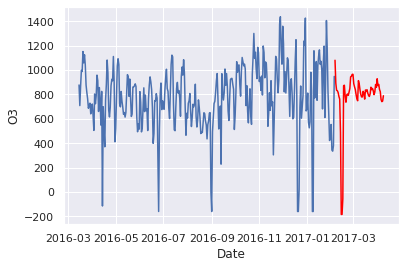

In [248]:
from datetime import datetime,timedelta
result,want=experiment_result(cdata,testdf,['CO','HC','NO2','O3'],parameter,['T','RH'])

In [249]:
exportdf=pd.DataFrame(result,columns=['Value'])


In [250]:
exportdf['id']=exportdf.index


In [251]:
pd.DataFrame({'id':exportdf.index,'Value':result}).to_csv('./result.csv',index=False)



In [734]:
pd.DataFrame(want).to_csv('get.csv')
